# Importing

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model, clone_model
from keras.optimizers import SGD, adam, adagrad, rmsprop

Using TensorFlow backend.


## Importing own code

In [2]:
from generateSpace import *
from plotLattice import *
from potentialEnergy import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [3]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss (E/Ec)')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss (E/Ec)')
    ax2.set_ylabel('Validation loss (E/Ec)')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss (E/Ec)')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss (E/Ec)')
    ax4.set_ylabel('Validation loss (E/Ec)')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [4]:
def makeGradiantPlot(model, x, testData):
    y = [[],[]]
    for i in range(len(x)):
        y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
        #y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
        y[1].append(testData['potentialEnergy'][i])


    fig, ((ax1, ax2)) = plt.subplots( ncols=2, figsize=(16, 8))
    ax1.plot(list(x), y[0], label='Predicted potential energy')
    ax1.plot(list(x), y[1], label='Real potential energy')
    ax1.legend()
    ax1.set_xlabel('Position of atom (r/Rc)')
    ax1.set_ylabel('Potential energy (E/E0)')
    ax1.set_title('Predicted potential energy and real potential energy for different positions.')
    
    ax2.plot(list(x), np.gradient(y[0], x[1] - x[0]), label='Predicted gradiant')
    ax2.plot(list(x), np.gradient(y[1], x[1] - x[0]), label='Real gradiant')
    ax2.legend()
    ax2.set_xlabel('Position of atom (r/Rc)')
    ax2.set_ylabel('Gradiant')
    ax2.set_title('Predicted gradiant and real gradiant for different positions.')
    
    plt.show()

In [5]:
def makePredictionPlot(model, dataFrame, amountOfPoints=2500):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        #prediction.append(model.predict([[dataFrame['relativeDistances'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy (E/E0)')
    ax1.set_ylabel('Predicted energy (E/E0)')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [6]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    #prediction = model.predict([[dataFrame['relativeDistances'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [7]:
def testNetwork(trainingInput, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE', validationSplit=0.3, epochs=10000, verbose=1, callbacksNetwork=[], sampleSize=4):
    bestModel = makeDenseNetwork(settings, learningRate, kernalInitializer, lossFunction)
    if verbose>=1:
        bestModel.summary()
        print(bestModel.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
        for i in range(len(bestModel.layers)):
            print('Layer ' + str(i) + ': ', bestModel.layers[i].get_weights())
    
    bestEvaluation = bestModel.evaluate(trainingInput['input'], trainingInput['target'], verbose=0)
    bestFitDetails = bestModel.fit(trainingInput['input'], trainingInput['target'], validation_split=validationSplit, epochs=3, verbose=0, callbacks=callbacksNetwork)
    
    for i in range(sampleSize):
        model = makeDenseNetwork(settings, learningRate, kernalInitializer, lossFunction)
        fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=validationSplit, epochs=epochs, verbose=verbose, callbacks=callbacksNetwork)
        
        if fitDetails.history['val_loss'][-1]<=bestEvaluation:
            bestModel = model
            bestEvaluation = fitDetails.history['val_loss'][-1]
            bestFitDetails = fitDetails
            
        if verbose>=1:
            for j in range(len(model.layers)):
                print('Network' + str(i) + ' Layer ' + str(j) + ': ', model.layers[j].get_weights())
            history = plotHistory(fitDetails)
    
    return bestModel, bestFitDetails

In [8]:
def makeDenseNetwork(settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[1][1], input_dim=settings[0], use_bias=settings[1][3], activation=settings[1][2], kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(2, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2], kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

In [9]:
def makeLinearNet(learningRate, inputDim, loss):
    model = Sequential()
    opt = adam(lr=learningRate)
    model.add(Dense(1, activation="linear", use_bias=False, input_dim=inputDim))
    model.compile(loss=loss, optimizer=opt)
    return model

# Getting data

## Importing data and settings

In [10]:
filename = 'databasemin_cut0.9_widths1_5-5_25k_3-1_epoch40_maxDelta0.1_AdjustedPotential_M2M3Prepared'#'databaseModLen_min_cut0.90_widths86_Width5_data1k_3-1sur_epoch30_maxDelta0.1_1Prepared'
orderOfMatrix = [-2, -3]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize = 4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [11]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues,relativeDistances
0,0,"[[4.9936927977, 0.6566078249], [2.9659392897, ...",5,3,-0.810441,"[-582.0361257924, -174.577254841, 0.6580360736...","[5, 0.8520077175, 0.8552883535, 2.4721102587, ..."
1,1,"[[2.4232032829, 3.6931585885000002], [1.122533...",5,3,-1.600238,"[-517.6791162028, -326.9580586954, -21.2941491...","[5, 0.8688973935000001, 0.9475867564, 1.440153..."
2,2,"[[1.8536304391, 0.0022189623], [2.2928456582, ...",5,3,-1.983167,"[-591.7825437323, -314.1153338866, -75.4878772...","[5, 0.877252028, 0.9800522882, 1.2926266963, 1..."
3,3,"[[0.0617690783, 1.0201982292], [4.2465436587, ...",5,3,-0.145590,"[-406.8799885124, -238.692199593, 128.31857014...","[5, 0.9935194815, 8.7516140027, 9.940794887700..."
4,4,"[[2.1911234415, 3.283294694], [1.0977772707, 0...",5,3,-0.803409,"[-532.208063252, -229.5447895145, 19.016690861...","[5, 0.9563405207000001, 1.0212008816, 3.128720..."


In [12]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,22500.000000,22500.0,22500.0,22500.000000
mean,11249.500000,5.0,3.0,-0.910727
std,6495.334864,0.0,0.0,1.890898
min,0.000000,5.0,3.0,-4.012309
25%,5624.750000,5.0,3.0,-1.702477
50%,11249.500000,5.0,3.0,-1.114572
75%,16874.250000,5.0,3.0,-0.401548
max,22499.000000,5.0,3.0,16.976324


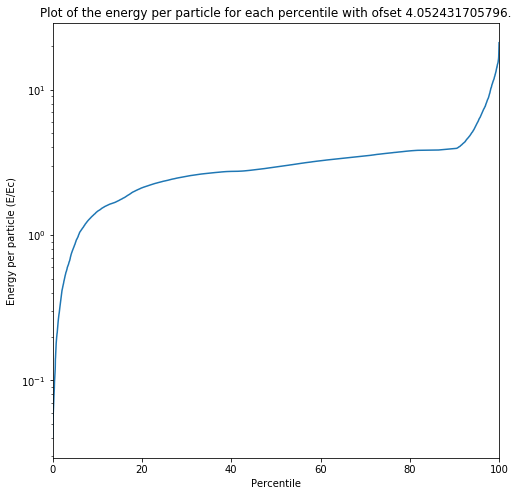

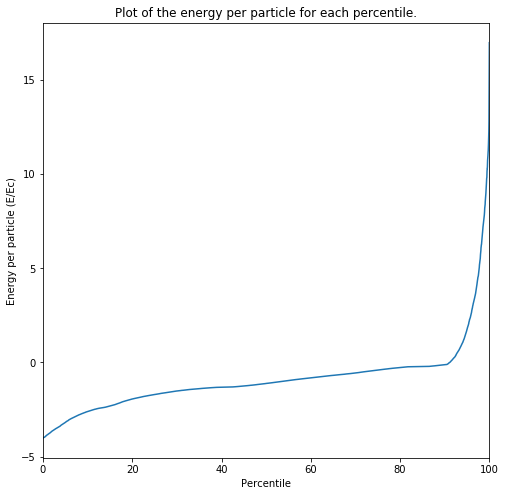

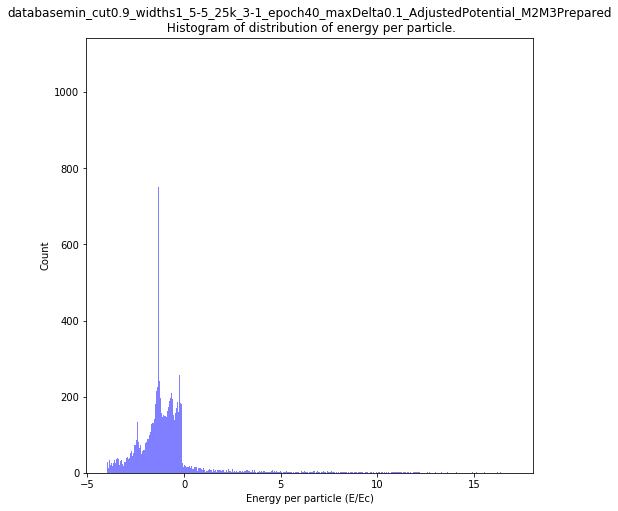

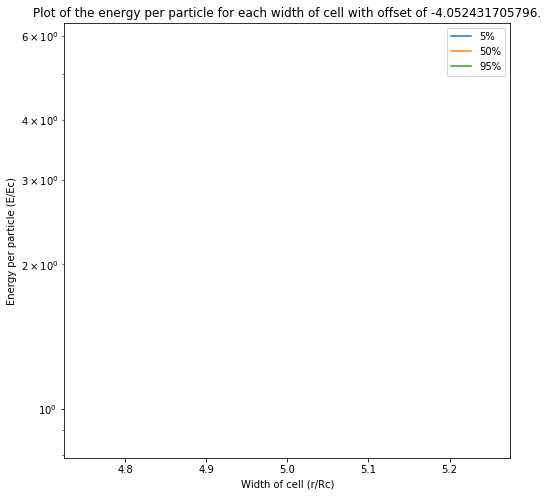

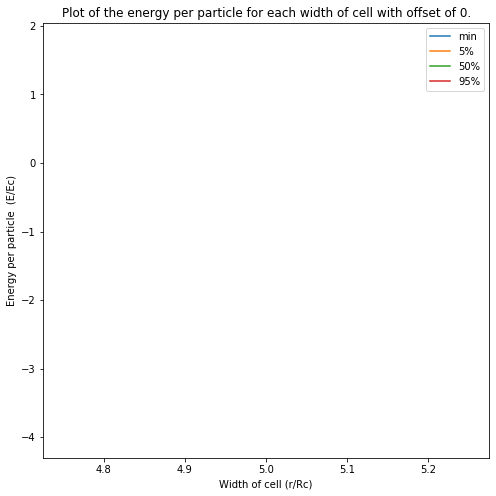

In [13]:

#"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile with ofset ' + str(-1.01 * min(x)) + '.')
ax.set_ylabel('Energy per particle (E/Ec)')
ax.set_xlabel('Percentile')
plt.show()

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle (E/Ec)')
ax.set_xlabel('Percentile')
plt.show()


#"""


#"""
numBins = 1000
fig, ax = plt.subplots(figsize=(8, 8))
n, bins, patches = ax.hist(x, numBins, facecolor='blue', alpha=0.5)
ax.set_title(filename + '\n Histogram of distribution of energy per particle.')
ax.set_xlabel('Energy per particle (E/Ec)')
ax.set_ylabel('Count')
plt.show()
#"""

#"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle (E/Ec)')
ax.set_xlabel('Width of cell (r/Rc)')
plt.show()
#"""

#"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
#plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle  (E/Ec)')
ax.set_xlabel('Width of cell (r/Rc)')
plt.show()
#"""


## Preparing data

In [14]:
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(np.array(trainingData['eigenvalues'][i]))
    #inputData.append(np.array(trainingData['relativeDistances'][i]))
    targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))
    #targetData.append([sum(trainingData['relativeDistances'][i])])

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(np.array(validationData['eigenvalues'][i]))
    #inputData.append(np.array(validationData['relativeDistances'][i]))
    targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])
    #targetData.append([sum(validationData['relativeDistances'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[ -413.870209    -388.05036854   251.01670425   980.33293311
 -8101.535527   -7775.67397016  6851.81389935 10237.74341077] -0.2191870906 

[ -437.43866362   -92.5289023    -50.61481826  1010.01144401
 -8769.64207956  -754.1454894   -222.81488292 10958.95026485] -0.28030411040000003 

[  -761.58579507   -355.32176308    -46.7980407    1593.13465868
 -20337.38247956  -6572.0056447    -284.53376898  28406.26970621] 2.3588342657 

(18000, 8)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(18000,)
<class 'numpy.ndarray'>
Results validation input:
[-6.08653178e+02 -3.81318429e+02 -5.44214035e+00  1.42484281e+03
 -1.42357649e+04 -7.21359624e+03  1.55567064e+03  2.11060383e+04] -1.9705457235 

[  -578.5300033    -362.86484968   -142.22100936   1513.04492217
 -12961.99857035  -6690.37971588  -1534.91672555  22399.64282475] -3.221141253 

[  -657.31059966   -299.19967782    -93.65302177   1479.59235908
 -15657.95198016  -5078.02889354   -469.08020058  22417.40888725] -2.

## Preparing test data

No handles with labels found to put in legend.


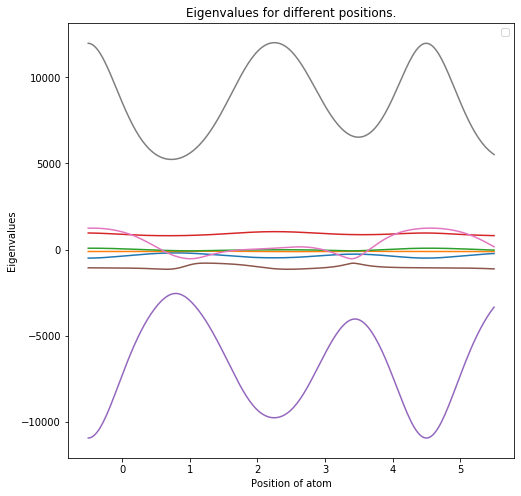

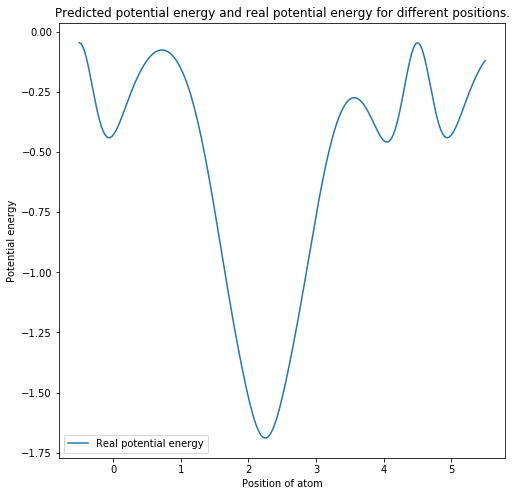

In [15]:
#"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(-0.1, 1.1, 2*120)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.3, 0.5]), np.array([0.68, 0.9]), np.array([0.7, 0.4]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerSet) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(0, len(testData['eigenvalues']))])
#ax1.plot(list(x), [testData['relativeDistances'][i] for i in range(0, len(testData['relativeDistances']))])
ax1.legend()
#ax1.set_ylim(-50, 50)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
#ax1.set_ylabel('Relative distances')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [16]:
def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))

models = []
prefixName = 0
saveFolder = 'M2M3Bias'
lossMetric = MAE#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))


## Model 0: Linear network

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
18000/18000 [==============================] - 0s 9us/step
4716.523307725694
Layer 0:  [array([[-0.2916801 ],
       [-0.37879154],
       [-0.47667423],
       [-0.7267929 ],
       [-0.30771053],
       [ 0.25759822],
       [-0.57320535],
       [-0.32519025]], dtype=float32), array([0.], dtype=float32)]
Train on 14400 samples, validate on 3600 samples
Epoch 1/20000
14400/14400 [==============================] - 0s 24us/step - loss: 8105.0017 - val_loss: 7994.4836
Epoch 2/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7929.1846 - val_loss: 7818.5647
Epoch 3/20000
14400/14400 [==============================] - 0s 20us

14400/14400 [==============================] - 0s 19us/step - loss: 459.0005 - val_loss: 472.3481
Epoch 66/20000
14400/14400 [==============================] - 0s 19us/step - loss: 450.5125 - val_loss: 463.6147
Epoch 67/20000
14400/14400 [==============================] - 0s 19us/step - loss: 442.1504 - val_loss: 454.9630
Epoch 68/20000
14400/14400 [==============================] - 0s 19us/step - loss: 433.9369 - val_loss: 446.4114
Epoch 69/20000
14400/14400 [==============================] - 0s 19us/step - loss: 425.7939 - val_loss: 437.9403
Epoch 70/20000
14400/14400 [==============================] - 0s 19us/step - loss: 417.7387 - val_loss: 429.5492
Epoch 71/20000
14400/14400 [==============================] - 0s 19us/step - loss: 409.7561 - val_loss: 421.1635
Epoch 72/20000
14400/14400 [==============================] - 0s 19us/step - loss: 401.8637 - val_loss: 412.9129
Epoch 73/20000
14400/14400 [==============================] - 0s 19us/step - loss: 394.0435 - val_loss: 404.725

14400/14400 [==============================] - 0s 20us/step - loss: 145.0859 - val_loss: 143.6568
Epoch 138/20000
14400/14400 [==============================] - 0s 20us/step - loss: 144.7238 - val_loss: 143.3886
Epoch 139/20000
14400/14400 [==============================] - 0s 20us/step - loss: 144.3906 - val_loss: 143.0238
Epoch 140/20000
14400/14400 [==============================] - 0s 20us/step - loss: 144.0555 - val_loss: 142.6557
Epoch 141/20000
14400/14400 [==============================] - 0s 20us/step - loss: 143.7204 - val_loss: 142.3631
Epoch 142/20000
14400/14400 [==============================] - 0s 19us/step - loss: 143.3681 - val_loss: 142.0474
Epoch 143/20000
14400/14400 [==============================] - 0s 19us/step - loss: 143.0257 - val_loss: 141.7052
Epoch 144/20000
14400/14400 [==============================] - 0s 19us/step - loss: 142.6940 - val_loss: 141.3066
Epoch 145/20000
14400/14400 [==============================] - 0s 20us/step - loss: 142.3501 - val_loss:

14400/14400 [==============================] - 0s 20us/step - loss: 120.7055 - val_loss: 119.7003
Epoch 210/20000
14400/14400 [==============================] - 0s 20us/step - loss: 120.3583 - val_loss: 119.3378
Epoch 211/20000
14400/14400 [==============================] - 0s 20us/step - loss: 120.0361 - val_loss: 119.0209
Epoch 212/20000
14400/14400 [==============================] - 0s 19us/step - loss: 119.6889 - val_loss: 118.7217
Epoch 213/20000
14400/14400 [==============================] - 0s 19us/step - loss: 119.3542 - val_loss: 118.3435
Epoch 214/20000
14400/14400 [==============================] - 0s 20us/step - loss: 119.0106 - val_loss: 118.0279
Epoch 215/20000
14400/14400 [==============================] - 0s 19us/step - loss: 118.6721 - val_loss: 117.6828
Epoch 216/20000
14400/14400 [==============================] - 0s 19us/step - loss: 118.3397 - val_loss: 117.3440
Epoch 217/20000
14400/14400 [==============================] - 0s 19us/step - loss: 118.0081 - val_loss:

Epoch 281/20000
14400/14400 [==============================] - 0s 20us/step - loss: 96.9155 - val_loss: 96.2263
Epoch 282/20000
14400/14400 [==============================] - 0s 19us/step - loss: 96.6013 - val_loss: 95.9019
Epoch 283/20000
14400/14400 [==============================] - 0s 20us/step - loss: 96.2593 - val_loss: 95.5822
Epoch 284/20000
14400/14400 [==============================] - 0s 20us/step - loss: 95.9454 - val_loss: 95.2518
Epoch 285/20000
14400/14400 [==============================] - 0s 19us/step - loss: 95.6197 - val_loss: 94.9286
Epoch 286/20000
14400/14400 [==============================] - 0s 20us/step - loss: 95.2649 - val_loss: 94.6509
Epoch 287/20000
14400/14400 [==============================] - 0s 19us/step - loss: 94.9591 - val_loss: 94.2859
Epoch 288/20000
14400/14400 [==============================] - 0s 20us/step - loss: 94.6185 - val_loss: 94.0122
Epoch 289/20000
14400/14400 [==============================] - 0s 19us/step - loss: 94.2955 - val_loss: 

14400/14400 [==============================] - 0s 22us/step - loss: 73.8808 - val_loss: 73.5359
Epoch 354/20000
14400/14400 [==============================] - 0s 21us/step - loss: 73.5697 - val_loss: 73.2170
Epoch 355/20000
14400/14400 [==============================] - 0s 21us/step - loss: 73.2566 - val_loss: 72.9069
Epoch 356/20000
14400/14400 [==============================] - 0s 21us/step - loss: 72.9368 - val_loss: 72.6332
Epoch 357/20000
14400/14400 [==============================] - 0s 21us/step - loss: 72.6326 - val_loss: 72.2760
Epoch 358/20000
14400/14400 [==============================] - 0s 22us/step - loss: 72.3192 - val_loss: 71.9747
Epoch 359/20000
14400/14400 [==============================] - 0s 21us/step - loss: 72.0135 - val_loss: 71.6613
Epoch 360/20000
14400/14400 [==============================] - 0s 21us/step - loss: 71.6973 - val_loss: 71.3666
Epoch 361/20000
14400/14400 [==============================] - 0s 21us/step - loss: 71.3591 - val_loss: 71.0557
Epoch 36

Epoch 426/20000
14400/14400 [==============================] - 0s 21us/step - loss: 51.7148 - val_loss: 51.7511
Epoch 427/20000
14400/14400 [==============================] - 0s 21us/step - loss: 51.4245 - val_loss: 51.4424
Epoch 428/20000
14400/14400 [==============================] - 0s 21us/step - loss: 51.1367 - val_loss: 51.1764
Epoch 429/20000
14400/14400 [==============================] - 0s 21us/step - loss: 50.8370 - val_loss: 50.8532
Epoch 430/20000
14400/14400 [==============================] - 0s 21us/step - loss: 50.5585 - val_loss: 50.6247
Epoch 431/20000
14400/14400 [==============================] - 0s 21us/step - loss: 50.2671 - val_loss: 50.2756
Epoch 432/20000
14400/14400 [==============================] - 0s 21us/step - loss: 49.9706 - val_loss: 50.0061
Epoch 433/20000
14400/14400 [==============================] - 0s 20us/step - loss: 49.6706 - val_loss: 49.7006
Epoch 434/20000
14400/14400 [==============================] - 0s 20us/step - loss: 49.3879 - val_loss: 

14400/14400 [==============================] - 0s 21us/step - loss: 31.8151 - val_loss: 32.0415
Epoch 500/20000
14400/14400 [==============================] - 0s 21us/step - loss: 31.5702 - val_loss: 31.7717
Epoch 501/20000
14400/14400 [==============================] - 0s 21us/step - loss: 31.3315 - val_loss: 31.5268
Epoch 502/20000
14400/14400 [==============================] - 0s 20us/step - loss: 31.0821 - val_loss: 31.2776
Epoch 503/20000
14400/14400 [==============================] - 0s 21us/step - loss: 30.8360 - val_loss: 31.0687
Epoch 504/20000
14400/14400 [==============================] - 0s 21us/step - loss: 30.6034 - val_loss: 30.7969
Epoch 505/20000
14400/14400 [==============================] - 0s 21us/step - loss: 30.3597 - val_loss: 30.5623
Epoch 506/20000
14400/14400 [==============================] - 0s 21us/step - loss: 30.1284 - val_loss: 30.3201
Epoch 507/20000
14400/14400 [==============================] - 0s 21us/step - loss: 29.8921 - val_loss: 30.0902
Epoch 50

14400/14400 [==============================] - 0s 19us/step - loss: 18.7120 - val_loss: 18.8832
Epoch 573/20000
14400/14400 [==============================] - 0s 19us/step - loss: 18.6043 - val_loss: 18.7513
Epoch 574/20000
14400/14400 [==============================] - 0s 20us/step - loss: 18.4828 - val_loss: 18.6458
Epoch 575/20000
14400/14400 [==============================] - 0s 19us/step - loss: 18.3764 - val_loss: 18.5336
Epoch 576/20000
14400/14400 [==============================] - 0s 19us/step - loss: 18.2682 - val_loss: 18.4267
Epoch 577/20000
14400/14400 [==============================] - 0s 19us/step - loss: 18.1683 - val_loss: 18.3327
Epoch 578/20000
14400/14400 [==============================] - 0s 19us/step - loss: 18.0637 - val_loss: 18.2149
Epoch 579/20000
14400/14400 [==============================] - 0s 19us/step - loss: 17.9622 - val_loss: 18.1216
Epoch 580/20000
14400/14400 [==============================] - 0s 19us/step - loss: 17.8588 - val_loss: 18.0084
Epoch 58

14400/14400 [==============================] - 0s 19us/step - loss: 13.8262 - val_loss: 13.9767
Epoch 646/20000
14400/14400 [==============================] - 0s 19us/step - loss: 13.7906 - val_loss: 13.9281
Epoch 647/20000
14400/14400 [==============================] - 0s 19us/step - loss: 13.7577 - val_loss: 13.9899
Epoch 648/20000
14400/14400 [==============================] - 0s 20us/step - loss: 13.7256 - val_loss: 13.8683
Epoch 649/20000
14400/14400 [==============================] - 0s 20us/step - loss: 13.6920 - val_loss: 13.8300
Epoch 650/20000
14400/14400 [==============================] - 0s 20us/step - loss: 13.6615 - val_loss: 13.8095
Epoch 651/20000
14400/14400 [==============================] - 0s 20us/step - loss: 13.6281 - val_loss: 13.7726
Epoch 652/20000
14400/14400 [==============================] - 0s 19us/step - loss: 13.5988 - val_loss: 13.7475
Epoch 653/20000
14400/14400 [==============================] - 0s 19us/step - loss: 13.5659 - val_loss: 13.7013
Epoch 65

14400/14400 [==============================] - 0s 19us/step - loss: 12.3715 - val_loss: 12.4457
Epoch 719/20000
14400/14400 [==============================] - 0s 19us/step - loss: 12.3703 - val_loss: 12.4428
Epoch 720/20000
14400/14400 [==============================] - 0s 19us/step - loss: 12.3644 - val_loss: 12.4724
Epoch 721/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.3496 - val_loss: 12.4278
Epoch 722/20000
14400/14400 [==============================] - 0s 19us/step - loss: 12.3374 - val_loss: 12.4864
Epoch 723/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.3315 - val_loss: 12.4000
Epoch 724/20000
14400/14400 [==============================] - 0s 19us/step - loss: 12.3222 - val_loss: 12.3932
Epoch 725/20000
14400/14400 [==============================] - 0s 19us/step - loss: 12.3200 - val_loss: 12.3900
Epoch 726/20000
14400/14400 [==============================] - 0s 19us/step - loss: 12.3047 - val_loss: 12.3812
Epoch 72

14400/14400 [==============================] - 0s 20us/step - loss: 12.0351 - val_loss: 12.0512
Epoch 792/20000
14400/14400 [==============================] - 0s 21us/step - loss: 12.0502 - val_loss: 12.0452
Epoch 793/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0395 - val_loss: 12.0513
Epoch 794/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0428 - val_loss: 12.0457
Epoch 795/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0375 - val_loss: 12.0730
Epoch 796/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0325 - val_loss: 12.0335
Epoch 797/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0305 - val_loss: 12.0426
Epoch 798/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0377 - val_loss: 12.0314
Epoch 799/20000
14400/14400 [==============================] - 0s 20us/step - loss: 12.0310 - val_loss: 12.0253
Epoch 80

14400/14400 [==============================] - 0s 19us/step - loss: 11.9297 - val_loss: 11.9065
Epoch 865/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9260 - val_loss: 11.9370
Epoch 866/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9203 - val_loss: 11.9281
Epoch 867/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9226 - val_loss: 11.9086
Epoch 868/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9226 - val_loss: 11.9041
Epoch 869/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9203 - val_loss: 11.9216
Epoch 870/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9121 - val_loss: 11.9135
Epoch 871/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9189 - val_loss: 11.9194
Epoch 872/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.9155 - val_loss: 11.9530
Epoch 87

14400/14400 [==============================] - 0s 19us/step - loss: 11.8391 - val_loss: 11.8067
Epoch 938/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8380 - val_loss: 11.8182
Epoch 939/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8301 - val_loss: 11.8342
Epoch 940/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.8295 - val_loss: 11.8128
Epoch 941/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8265 - val_loss: 11.8060
Epoch 942/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8288 - val_loss: 11.8123
Epoch 943/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8244 - val_loss: 11.8252
Epoch 944/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8259 - val_loss: 11.8872
Epoch 945/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.8313 - val_loss: 11.8086
Epoch 94

Epoch 1010/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7448 - val_loss: 11.7227
Epoch 1011/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7453 - val_loss: 11.7199
Epoch 1012/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7433 - val_loss: 11.7193
Epoch 1013/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7408 - val_loss: 11.7259
Epoch 1014/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7381 - val_loss: 11.7140
Epoch 1015/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7381 - val_loss: 11.7462
Epoch 1016/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7429 - val_loss: 11.7200
Epoch 1017/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7507 - val_loss: 11.7126
Epoch 1018/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.7394 - v

14400/14400 [==============================] - 0s 19us/step - loss: 11.6660 - val_loss: 11.6325
Epoch 1083/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6697 - val_loss: 11.6510
Epoch 1084/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6675 - val_loss: 11.6502
Epoch 1085/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6648 - val_loss: 11.6302
Epoch 1086/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6577 - val_loss: 11.6941
Epoch 1087/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6633 - val_loss: 11.6366
Epoch 1088/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6566 - val_loss: 11.6476
Epoch 1089/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6476 - val_loss: 11.6638
Epoch 1090/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.6566 - val_loss: 11.6563


14400/14400 [==============================] - 0s 19us/step - loss: 11.5793 - val_loss: 11.5588
Epoch 1155/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5807 - val_loss: 11.5709
Epoch 1156/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5781 - val_loss: 11.5509
Epoch 1157/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5712 - val_loss: 11.5712
Epoch 1158/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5779 - val_loss: 11.5983
Epoch 1159/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5656 - val_loss: 11.5470
Epoch 1160/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5729 - val_loss: 11.5777
Epoch 1161/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5687 - val_loss: 11.5447
Epoch 1162/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.5685 - val_loss: 11.6046


14400/14400 [==============================] - 0s 19us/step - loss: 11.4955 - val_loss: 11.4690
Epoch 1227/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.4966 - val_loss: 11.4669
Epoch 1228/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4894 - val_loss: 11.4625
Epoch 1229/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4864 - val_loss: 11.4747
Epoch 1230/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4918 - val_loss: 11.5014
Epoch 1231/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4908 - val_loss: 11.4776
Epoch 1232/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.4895 - val_loss: 11.5568
Epoch 1233/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4862 - val_loss: 11.5118
Epoch 1234/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4855 - val_loss: 11.4562


14400/14400 [==============================] - 0s 20us/step - loss: 11.4092 - val_loss: 11.3878
Epoch 1299/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.4114 - val_loss: 11.4112
Epoch 1300/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4114 - val_loss: 11.3829
Epoch 1301/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3999 - val_loss: 11.4184
Epoch 1302/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4075 - val_loss: 11.3932
Epoch 1303/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4048 - val_loss: 11.3882
Epoch 1304/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4000 - val_loss: 11.3942
Epoch 1305/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4036 - val_loss: 11.3961
Epoch 1306/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.4037 - val_loss: 11.3854


14400/14400 [==============================] - 0s 20us/step - loss: 11.3329 - val_loss: 11.3813
Epoch 1371/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.3339 - val_loss: 11.2985
Epoch 1372/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3227 - val_loss: 11.2971
Epoch 1373/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3332 - val_loss: 11.3210
Epoch 1374/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3255 - val_loss: 11.3123
Epoch 1375/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3165 - val_loss: 11.2921
Epoch 1376/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.3246 - val_loss: 11.3210
Epoch 1377/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3281 - val_loss: 11.3066
Epoch 1378/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.3117 - val_loss: 11.2987


14400/14400 [==============================] - ETA: 0s - loss: 11.12 - 0s 20us/step - loss: 11.2375 - val_loss: 11.2402
Epoch 1443/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.2458 - val_loss: 11.2290
Epoch 1444/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.2477 - val_loss: 11.2134
Epoch 1445/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.2377 - val_loss: 11.2547
Epoch 1446/20000
14400/14400 [==============================] - 0s 21us/step - loss: 11.2389 - val_loss: 11.2253
Epoch 1447/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.2392 - val_loss: 11.2431
Epoch 1448/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.2356 - val_loss: 11.2091
Epoch 1449/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.2402 - val_loss: 11.2098
Epoch 1450/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.2

14400/14400 [==============================] - 0s 19us/step - loss: 11.1683 - val_loss: 11.1354
Epoch 1515/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.1542 - val_loss: 11.1380
Epoch 1516/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.1548 - val_loss: 11.1617
Epoch 1517/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.1535 - val_loss: 11.1532
Epoch 1518/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.1587 - val_loss: 11.1282
Epoch 1519/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.1575 - val_loss: 11.1414
Epoch 1520/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.1523 - val_loss: 11.1323
Epoch 1521/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.1517 - val_loss: 11.1301
Epoch 1522/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.1503 - val_loss: 11.1310


14400/14400 [==============================] - 0s 19us/step - loss: 11.0817 - val_loss: 11.0518
Epoch 1587/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0770 - val_loss: 11.0738
Epoch 1588/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0771 - val_loss: 11.0609
Epoch 1589/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0738 - val_loss: 11.0434
Epoch 1590/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0748 - val_loss: 11.0640
Epoch 1591/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0779 - val_loss: 11.0473
Epoch 1592/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0739 - val_loss: 11.0800
Epoch 1593/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0670 - val_loss: 11.0431
Epoch 1594/20000
14400/14400 [==============================] - 0s 19us/step - loss: 11.0711 - val_loss: 11.0438


14400/14400 [==============================] - 0s 19us/step - loss: 10.9973 - val_loss: 11.0356
Epoch 1659/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.0008 - val_loss: 10.9949
Epoch 1660/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.9872 - val_loss: 10.9799
Epoch 1661/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9958 - val_loss: 10.9779
Epoch 1662/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9910 - val_loss: 10.9643
Epoch 1663/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9869 - val_loss: 10.9688
Epoch 1664/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9934 - val_loss: 10.9702
Epoch 1665/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.9842 - val_loss: 11.0300
Epoch 1666/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9915 - val_loss: 10.9781


14400/14400 [==============================] - 0s 19us/step - loss: 10.9178 - val_loss: 10.9598
Epoch 1731/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.9144 - val_loss: 10.8834
Epoch 1732/20000
14400/14400 [==============================] - 0s 21us/step - loss: 10.9093 - val_loss: 10.8874
Epoch 1733/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.9119 - val_loss: 10.8823
Epoch 1734/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.9086 - val_loss: 10.8990
Epoch 1735/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.9020 - val_loss: 10.8775
Epoch 1736/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9054 - val_loss: 10.8807
Epoch 1737/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9083 - val_loss: 10.8768
Epoch 1738/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.9021 - val_loss: 10.8761


14400/14400 [==============================] - 0s 20us/step - loss: 10.8286 - val_loss: 10.7993
Epoch 1803/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.8294 - val_loss: 10.8128
Epoch 1804/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.8294 - val_loss: 10.8043
Epoch 1805/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.8297 - val_loss: 10.7966
Epoch 1806/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.8255 - val_loss: 10.8032
Epoch 1807/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.8217 - val_loss: 10.8808
Epoch 1808/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.8207 - val_loss: 10.8016
Epoch 1809/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.8233 - val_loss: 10.8172
Epoch 1810/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.8222 - val_loss: 10.7950


14400/14400 [==============================] - 0s 19us/step - loss: 10.7483 - val_loss: 10.7181
Epoch 1875/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7432 - val_loss: 10.7168
Epoch 1876/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7488 - val_loss: 10.7188
Epoch 1877/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7438 - val_loss: 10.7244
Epoch 1878/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7479 - val_loss: 10.7279
Epoch 1879/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7550 - val_loss: 10.7316
Epoch 1880/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7409 - val_loss: 10.7350
Epoch 1881/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.7408 - val_loss: 10.7139
Epoch 1882/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.7372 - val_loss: 10.7090


14400/14400 [==============================] - 0s 19us/step - loss: 10.6644 - val_loss: 10.6360
Epoch 1947/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6548 - val_loss: 10.6339
Epoch 1948/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6681 - val_loss: 10.6401
Epoch 1949/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6688 - val_loss: 10.6317
Epoch 1950/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6630 - val_loss: 10.6419
Epoch 1951/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6587 - val_loss: 10.6291
Epoch 1952/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6597 - val_loss: 10.6389
Epoch 1953/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6525 - val_loss: 10.6306
Epoch 1954/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.6499 - val_loss: 10.6607


14400/14400 [==============================] - 0s 19us/step - loss: 10.5823 - val_loss: 10.5610
Epoch 2019/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5763 - val_loss: 10.5514
Epoch 2020/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5758 - val_loss: 10.5524
Epoch 2021/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5807 - val_loss: 10.6398
Epoch 2022/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5812 - val_loss: 10.5469
Epoch 2023/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5751 - val_loss: 10.5458
Epoch 2024/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.5750 - val_loss: 10.5470
Epoch 2025/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5702 - val_loss: 10.5509
Epoch 2026/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.5783 - val_loss: 10.5424


14400/14400 [==============================] - 0s 19us/step - loss: 10.5011 - val_loss: 10.5179
Epoch 2091/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.4996 - val_loss: 10.4699
Epoch 2092/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4969 - val_loss: 10.4741
Epoch 2093/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4960 - val_loss: 10.4672
Epoch 2094/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4922 - val_loss: 10.4678
Epoch 2095/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.4964 - val_loss: 10.4969
Epoch 2096/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4934 - val_loss: 10.4858
Epoch 2097/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4943 - val_loss: 10.4655
Epoch 2098/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4860 - val_loss: 10.4908


14400/14400 [==============================] - 0s 19us/step - loss: 10.4149 - val_loss: 10.4054
Epoch 2163/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4174 - val_loss: 10.3895
Epoch 2164/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4184 - val_loss: 10.3845
Epoch 2165/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4223 - val_loss: 10.3832
Epoch 2166/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4166 - val_loss: 10.4033
Epoch 2167/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.4033 - val_loss: 10.3881
Epoch 2168/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.4057 - val_loss: 10.3880
Epoch 2169/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.4124 - val_loss: 10.3896
Epoch 2170/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.4070 - val_loss: 10.3866


14400/14400 [==============================] - 0s 19us/step - loss: 10.3362 - val_loss: 10.3042
Epoch 2235/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.3351 - val_loss: 10.3440
Epoch 2236/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.3342 - val_loss: 10.3239
Epoch 2237/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.3348 - val_loss: 10.3049
Epoch 2238/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.3371 - val_loss: 10.3031
Epoch 2239/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.3336 - val_loss: 10.3188
Epoch 2240/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.3285 - val_loss: 10.3100
Epoch 2241/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.3264 - val_loss: 10.2974
Epoch 2242/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.3211 - val_loss: 10.3180


14400/14400 [==============================] - 0s 19us/step - loss: 10.2551 - val_loss: 10.2242
Epoch 2307/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2504 - val_loss: 10.2264
Epoch 2308/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2561 - val_loss: 10.2262
Epoch 2309/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2494 - val_loss: 10.2176
Epoch 2310/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.2439 - val_loss: 10.2475
Epoch 2311/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2509 - val_loss: 10.2191
Epoch 2312/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2469 - val_loss: 10.2214
Epoch 2313/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2425 - val_loss: 10.2243
Epoch 2314/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.2472 - val_loss: 10.2136


14400/14400 [==============================] - 0s 19us/step - loss: 10.1730 - val_loss: 10.1533
Epoch 2379/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1665 - val_loss: 10.2270
Epoch 2380/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1693 - val_loss: 10.1529
Epoch 2381/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1752 - val_loss: 10.2165
Epoch 2382/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1698 - val_loss: 10.1385
Epoch 2383/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1675 - val_loss: 10.1495
Epoch 2384/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1623 - val_loss: 10.1387
Epoch 2385/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1630 - val_loss: 10.1538
Epoch 2386/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.1607 - val_loss: 10.1381


14400/14400 [==============================] - 0s 20us/step - loss: 10.0962 - val_loss: 10.0588
Epoch 2451/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.0889 - val_loss: 10.0773
Epoch 2452/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.0884 - val_loss: 10.0564
Epoch 2453/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0802 - val_loss: 10.0618
Epoch 2454/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0905 - val_loss: 10.0849
Epoch 2455/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0896 - val_loss: 10.0537
Epoch 2456/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0846 - val_loss: 10.0988
Epoch 2457/20000
14400/14400 [==============================] - 0s 20us/step - loss: 10.0765 - val_loss: 10.0545
Epoch 2458/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0838 - val_loss: 10.0544


14400/14400 [==============================] - 0s 19us/step - loss: 10.0165 - val_loss: 9.9901
Epoch 2523/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0024 - val_loss: 9.9755
Epoch 2524/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0004 - val_loss: 9.9916
Epoch 2525/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0032 - val_loss: 9.9987
Epoch 2526/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0038 - val_loss: 9.9724
Epoch 2527/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9992 - val_loss: 9.9920
Epoch 2528/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0024 - val_loss: 9.9861
Epoch 2529/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9961 - val_loss: 9.9830
Epoch 2530/20000
14400/14400 [==============================] - 0s 19us/step - loss: 10.0010 - val_loss: 9.9680
Epoch 2531/

Epoch 2596/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9217 - val_loss: 9.8966
Epoch 2597/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9258 - val_loss: 9.9015
Epoch 2598/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9176 - val_loss: 9.8946
Epoch 2599/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9162 - val_loss: 9.9279
Epoch 2600/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9177 - val_loss: 9.8934
Epoch 2601/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9147 - val_loss: 9.8881
Epoch 2602/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9137 - val_loss: 9.8907
Epoch 2603/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9156 - val_loss: 9.8978
Epoch 2604/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.9198 - val_loss: 9.8896
E

Epoch 2670/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.8470 - val_loss: 9.8107
Epoch 2671/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.8375 - val_loss: 9.8270
Epoch 2672/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.8369 - val_loss: 9.8099
Epoch 2673/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.8297 - val_loss: 9.8137
Epoch 2674/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.8304 - val_loss: 9.8055
Epoch 2675/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.8310 - val_loss: 9.8154
Epoch 2676/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.8354 - val_loss: 9.8065
Epoch 2677/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.8263 - val_loss: 9.8096
Epoch 2678/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.8321 - val_loss: 9.8655
E

Epoch 2744/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7567 - val_loss: 9.7362
Epoch 2745/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7567 - val_loss: 9.7265
Epoch 2746/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7571 - val_loss: 9.7306
Epoch 2747/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7598 - val_loss: 9.7768
Epoch 2748/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7531 - val_loss: 9.7248
Epoch 2749/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7476 - val_loss: 9.7278
Epoch 2750/20000
14400/14400 [==============================] - 0s 18us/step - loss: 9.7481 - val_loss: 9.7206
Epoch 2751/20000
14400/14400 [==============================] - 0s 18us/step - loss: 9.7449 - val_loss: 9.7371
Epoch 2752/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.7501 - val_loss: 9.7323
E

Epoch 2818/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6722 - val_loss: 9.6423
Epoch 2819/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6733 - val_loss: 9.6462
Epoch 2820/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6688 - val_loss: 9.6509
Epoch 2821/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6665 - val_loss: 9.6511
Epoch 2822/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6629 - val_loss: 9.6550
Epoch 2823/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6675 - val_loss: 9.6503
Epoch 2824/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6605 - val_loss: 9.6350
Epoch 2825/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.6657 - val_loss: 9.6408
Epoch 2826/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.6627 - val_loss: 9.6790
E

Epoch 2892/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5853 - val_loss: 9.6183
Epoch 2893/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5879 - val_loss: 9.5570
Epoch 2894/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5856 - val_loss: 9.5629
Epoch 2895/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5744 - val_loss: 9.5660
Epoch 2896/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5803 - val_loss: 9.5604
Epoch 2897/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5818 - val_loss: 9.6298
Epoch 2898/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5819 - val_loss: 9.5610
Epoch 2899/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5802 - val_loss: 9.5573
Epoch 2900/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5767 - val_loss: 9.5525
E

14400/14400 [==============================] - 0s 19us/step - loss: 9.5084 - val_loss: 9.4763
Epoch 2966/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4998 - val_loss: 9.4806
Epoch 2967/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5064 - val_loss: 9.4747
Epoch 2968/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5057 - val_loss: 9.4720
Epoch 2969/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4989 - val_loss: 9.4738
Epoch 2970/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4995 - val_loss: 9.4701
Epoch 2971/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.5037 - val_loss: 9.4727
Epoch 2972/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4929 - val_loss: 9.4671
Epoch 2973/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4957 - val_loss: 9.4670
Epoch 2974/20000
1

Epoch 3039/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.4222 - val_loss: 9.4193
Epoch 3040/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.4137 - val_loss: 9.3893
Epoch 3041/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4220 - val_loss: 9.4248
Epoch 3042/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4213 - val_loss: 9.4111
Epoch 3043/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4164 - val_loss: 9.4072
Epoch 3044/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4219 - val_loss: 9.4519
Epoch 3045/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4136 - val_loss: 9.4003
Epoch 3046/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4148 - val_loss: 9.3861
Epoch 3047/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.4093 - val_loss: 9.3822
E

Epoch 3113/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3315 - val_loss: 9.3069
Epoch 3114/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3313 - val_loss: 9.3723
Epoch 3115/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3293 - val_loss: 9.4053
Epoch 3116/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3350 - val_loss: 9.3332
Epoch 3117/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.3334 - val_loss: 9.3048
Epoch 3118/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3364 - val_loss: 9.3035
Epoch 3119/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3325 - val_loss: 9.3203
Epoch 3120/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3264 - val_loss: 9.3037
Epoch 3121/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.3300 - val_loss: 9.3215
E

Epoch 3187/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2532 - val_loss: 9.2298
Epoch 3188/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2534 - val_loss: 9.2526
Epoch 3189/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2526 - val_loss: 9.2264
Epoch 3190/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2503 - val_loss: 9.2248
Epoch 3191/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2485 - val_loss: 9.2249
Epoch 3192/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2547 - val_loss: 9.2272
Epoch 3193/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2454 - val_loss: 9.2263
Epoch 3194/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2511 - val_loss: 9.2186
Epoch 3195/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.2384 - val_loss: 9.2164
E

14400/14400 [==============================] - 0s 19us/step - loss: 9.1736 - val_loss: 9.1681
Epoch 3261/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1662 - val_loss: 9.1970
Epoch 3262/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1713 - val_loss: 9.1712
Epoch 3263/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1653 - val_loss: 9.1393
Epoch 3264/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1672 - val_loss: 9.1384
Epoch 3265/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1690 - val_loss: 9.1382
Epoch 3266/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1605 - val_loss: 9.1558
Epoch 3267/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.1613 - val_loss: 9.1348
Epoch 3268/20000
14400/14400 [==============================] - 0s 24us/step - loss: 9.1597 - val_loss: 9.2175
Epoch 3269/20000
1

Epoch 3334/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0859 - val_loss: 9.0630
Epoch 3335/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0909 - val_loss: 9.0769
Epoch 3336/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0813 - val_loss: 9.0599
Epoch 3337/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0870 - val_loss: 9.0603
Epoch 3338/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0816 - val_loss: 9.0884
Epoch 3339/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0843 - val_loss: 9.0719
Epoch 3340/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0793 - val_loss: 9.1264
Epoch 3341/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0783 - val_loss: 9.0811
Epoch 3342/20000
14400/14400 [==============================] - 0s 20us/step - loss: 9.0807 - val_loss: 9.0491
E

Epoch 3408/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0062 - val_loss: 9.0177
Epoch 3409/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0001 - val_loss: 8.9841
Epoch 3410/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0025 - val_loss: 8.9782
Epoch 3411/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0026 - val_loss: 8.9765
Epoch 3412/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.9976 - val_loss: 8.9729
Epoch 3413/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0007 - val_loss: 8.9707
Epoch 3414/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9984 - val_loss: 8.9721
Epoch 3415/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9984 - val_loss: 8.9894
Epoch 3416/20000
14400/14400 [==============================] - 0s 19us/step - loss: 9.0000 - val_loss: 8.9652
E

Epoch 3482/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9183 - val_loss: 8.9002
Epoch 3483/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9249 - val_loss: 8.9052
Epoch 3484/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9286 - val_loss: 8.8908
Epoch 3485/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9168 - val_loss: 8.9212
Epoch 3486/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9158 - val_loss: 8.9300
Epoch 3487/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9153 - val_loss: 8.9084
Epoch 3488/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9129 - val_loss: 8.9251
Epoch 3489/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9152 - val_loss: 8.8857
Epoch 3490/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.9229 - val_loss: 8.8986
E

Epoch 3556/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8423 - val_loss: 8.8103
Epoch 3557/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8381 - val_loss: 8.8109
Epoch 3558/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8382 - val_loss: 8.8169
Epoch 3559/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8338 - val_loss: 8.8172
Epoch 3560/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8280 - val_loss: 8.8070
Epoch 3561/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8311 - val_loss: 8.8721
Epoch 3562/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8274 - val_loss: 8.8149
Epoch 3563/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8254 - val_loss: 8.8453
Epoch 3564/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.8229 - val_loss: 8.8119
E

Epoch 3630/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7540 - val_loss: 8.7317
Epoch 3631/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7555 - val_loss: 8.7251
Epoch 3632/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7537 - val_loss: 8.7325
Epoch 3633/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7523 - val_loss: 8.7298
Epoch 3634/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7497 - val_loss: 8.7254
Epoch 3635/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7503 - val_loss: 8.7340
Epoch 3636/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7455 - val_loss: 8.7441
Epoch 3637/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7543 - val_loss: 8.7318
Epoch 3638/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.7460 - val_loss: 8.8240
E

Epoch 3704/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6753 - val_loss: 8.6737
Epoch 3705/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6668 - val_loss: 8.7014
Epoch 3706/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6744 - val_loss: 8.6500
Epoch 3707/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6660 - val_loss: 8.6406
Epoch 3708/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6700 - val_loss: 8.6437
Epoch 3709/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6602 - val_loss: 8.6522
Epoch 3710/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6714 - val_loss: 8.6424
Epoch 3711/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6602 - val_loss: 8.6565
Epoch 3712/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.6651 - val_loss: 8.6360
E

Epoch 3778/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5846 - val_loss: 8.5629
Epoch 3779/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5884 - val_loss: 8.5656
Epoch 3780/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5847 - val_loss: 8.5777
Epoch 3781/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5835 - val_loss: 8.5714
Epoch 3782/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5892 - val_loss: 8.5578
Epoch 3783/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5851 - val_loss: 8.5660
Epoch 3784/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5768 - val_loss: 8.5758
Epoch 3785/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5796 - val_loss: 8.5598
Epoch 3786/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5837 - val_loss: 8.5543
E

Epoch 3852/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5056 - val_loss: 8.4819
Epoch 3853/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5108 - val_loss: 8.4793
Epoch 3854/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5004 - val_loss: 8.5064
Epoch 3855/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5120 - val_loss: 8.4775
Epoch 3856/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5057 - val_loss: 8.5044
Epoch 3857/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.5000 - val_loss: 8.5068
Epoch 3858/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4987 - val_loss: 8.4769
Epoch 3859/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4993 - val_loss: 8.4826
Epoch 3860/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4990 - val_loss: 8.4696
E

Epoch 3926/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.4223 - val_loss: 8.3981
Epoch 3927/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.4299 - val_loss: 8.4075
Epoch 3928/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4213 - val_loss: 8.4012
Epoch 3929/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.4215 - val_loss: 8.4528
Epoch 3930/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.4201 - val_loss: 8.3916
Epoch 3931/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.4168 - val_loss: 8.4065
Epoch 3932/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4186 - val_loss: 8.4024
Epoch 3933/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4211 - val_loss: 8.3865
Epoch 3934/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.4142 - val_loss: 8.3914
E

Epoch 4000/20000
14400/14400 [==============================] - 0s 22us/step - loss: 8.3428 - val_loss: 8.3195
Epoch 4001/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.3399 - val_loss: 8.3148
Epoch 4002/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.3319 - val_loss: 8.3496
Epoch 4003/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.3349 - val_loss: 8.3123
Epoch 4004/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.3326 - val_loss: 8.3459
Epoch 4005/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.3349 - val_loss: 8.3156
Epoch 4006/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.3310 - val_loss: 8.3069
Epoch 4007/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.3264 - val_loss: 8.3150
Epoch 4008/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.3306 - val_loss: 8.3078
E

Epoch 4074/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2682 - val_loss: 8.2410
Epoch 4075/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2558 - val_loss: 8.2627
Epoch 4076/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2602 - val_loss: 8.2318
Epoch 4077/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2478 - val_loss: 8.2270
Epoch 4078/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2549 - val_loss: 8.2256
Epoch 4079/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2485 - val_loss: 8.2434
Epoch 4080/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2600 - val_loss: 8.2650
Epoch 4081/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2452 - val_loss: 8.2394
Epoch 4082/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.2458 - val_loss: 8.2455
E

Epoch 4148/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.1737 - val_loss: 8.1519
Epoch 4149/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.1727 - val_loss: 8.1528
Epoch 4150/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.1706 - val_loss: 8.1730
Epoch 4151/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.1654 - val_loss: 8.3293
Epoch 4152/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.1676 - val_loss: 8.1449
Epoch 4153/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.1656 - val_loss: 8.1496
Epoch 4154/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.1665 - val_loss: 8.1433
Epoch 4155/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.1654 - val_loss: 8.1765
Epoch 4156/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.1669 - val_loss: 8.1572
E

Epoch 4222/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.0979 - val_loss: 8.0746
Epoch 4223/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.0943 - val_loss: 8.1113
Epoch 4224/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.0904 - val_loss: 8.0717
Epoch 4225/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.0909 - val_loss: 8.0726
Epoch 4226/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.0912 - val_loss: 8.0834
Epoch 4227/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.0847 - val_loss: 8.0713
Epoch 4228/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.0856 - val_loss: 8.0813
Epoch 4229/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.0854 - val_loss: 8.0888
Epoch 4230/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.0872 - val_loss: 8.0615
E

Epoch 4296/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0159 - val_loss: 7.9844
Epoch 4297/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0123 - val_loss: 8.0487
Epoch 4298/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0027 - val_loss: 8.0867
Epoch 4299/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0055 - val_loss: 7.9825
Epoch 4300/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0099 - val_loss: 8.0026
Epoch 4301/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0038 - val_loss: 7.9860
Epoch 4302/20000
14400/14400 [==============================] - 0s 19us/step - loss: 8.0044 - val_loss: 8.0224
Epoch 4303/20000
14400/14400 [==============================] - 0s 18us/step - loss: 8.0032 - val_loss: 7.9882
Epoch 4304/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9998 - val_loss: 7.9893
E

Epoch 4370/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9315 - val_loss: 7.9643
Epoch 4371/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9272 - val_loss: 7.9338
Epoch 4372/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9239 - val_loss: 7.9064
Epoch 4373/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9214 - val_loss: 7.9221
Epoch 4374/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9306 - val_loss: 7.8958
Epoch 4375/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.9394 - val_loss: 7.9043
Epoch 4376/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9157 - val_loss: 7.8943
Epoch 4377/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9180 - val_loss: 7.9021
Epoch 4378/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.9231 - val_loss: 7.8949
E

Epoch 4444/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8411 - val_loss: 7.8389
Epoch 4445/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8444 - val_loss: 7.8382
Epoch 4446/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8440 - val_loss: 7.8217
Epoch 4447/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8424 - val_loss: 7.9925
Epoch 4448/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8376 - val_loss: 7.8174
Epoch 4449/20000
14400/14400 [==============================] - 0s 18us/step - loss: 7.8424 - val_loss: 7.8161
Epoch 4450/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8364 - val_loss: 7.8120
Epoch 4451/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8433 - val_loss: 7.8197
Epoch 4452/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.8338 - val_loss: 7.8160
E

Epoch 4518/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7650 - val_loss: 7.7497
Epoch 4519/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7635 - val_loss: 7.7432
Epoch 4520/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7564 - val_loss: 7.7846
Epoch 4521/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7682 - val_loss: 7.7386
Epoch 4522/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7533 - val_loss: 7.7461
Epoch 4523/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7644 - val_loss: 7.7768
Epoch 4524/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7556 - val_loss: 7.7491
Epoch 4525/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7529 - val_loss: 7.7333
Epoch 4526/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.7539 - val_loss: 7.7313
E

Epoch 4592/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6834 - val_loss: 7.6751
Epoch 4593/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6797 - val_loss: 7.6686
Epoch 4594/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.6774 - val_loss: 7.6540
Epoch 4595/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.6769 - val_loss: 7.6548
Epoch 4596/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6739 - val_loss: 7.6484
Epoch 4597/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.6706 - val_loss: 7.6792
Epoch 4598/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.6744 - val_loss: 7.6509
Epoch 4599/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.6764 - val_loss: 7.6552
Epoch 4600/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6687 - val_loss: 7.6481
E

Epoch 4666/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5916 - val_loss: 7.5713
Epoch 4667/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5989 - val_loss: 7.5697
Epoch 4668/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5920 - val_loss: 7.5782
Epoch 4669/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.5970 - val_loss: 7.5854
Epoch 4670/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.5920 - val_loss: 7.5691
Epoch 4671/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5929 - val_loss: 7.5889
Epoch 4672/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5897 - val_loss: 7.5659
Epoch 4673/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5887 - val_loss: 7.5643
Epoch 4674/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5847 - val_loss: 7.5733
E

14400/14400 [==============================] - 0s 20us/step - loss: 7.5208 - val_loss: 7.4939
Epoch 4740/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.5208 - val_loss: 7.5034
Epoch 4741/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5153 - val_loss: 7.4930
Epoch 4742/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5111 - val_loss: 7.5047
Epoch 4743/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5147 - val_loss: 7.4949
Epoch 4744/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5170 - val_loss: 7.4911
Epoch 4745/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5100 - val_loss: 7.4835
Epoch 4746/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5143 - val_loss: 7.4852
Epoch 4747/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.5035 - val_loss: 7.4854
Epoch 4748/20000
1

Epoch 4813/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4308 - val_loss: 7.4532
Epoch 4814/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4318 - val_loss: 7.4087
Epoch 4815/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4304 - val_loss: 7.4335
Epoch 4816/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4342 - val_loss: 7.4208
Epoch 4817/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4374 - val_loss: 7.4067
Epoch 4818/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4382 - val_loss: 7.4078
Epoch 4819/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.4253 - val_loss: 7.4105
Epoch 4820/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4239 - val_loss: 7.4111
Epoch 4821/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.4430 - val_loss: 7.4102
E

Epoch 4887/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3539 - val_loss: 7.3815
Epoch 4888/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3567 - val_loss: 7.3339
Epoch 4889/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3573 - val_loss: 7.3319
Epoch 4890/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3500 - val_loss: 7.3251
Epoch 4891/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3535 - val_loss: 7.3829
Epoch 4892/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3440 - val_loss: 7.3232
Epoch 4893/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.3441 - val_loss: 7.4602
Epoch 4894/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3460 - val_loss: 7.3216
Epoch 4895/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.3435 - val_loss: 7.3379
E

Epoch 4961/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2708 - val_loss: 7.2488
Epoch 4962/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2758 - val_loss: 7.2533
Epoch 4963/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2712 - val_loss: 7.2532
Epoch 4964/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.2681 - val_loss: 7.2534
Epoch 4965/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2712 - val_loss: 7.3257
Epoch 4966/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2659 - val_loss: 7.3045
Epoch 4967/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2627 - val_loss: 7.2417
Epoch 4968/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2602 - val_loss: 7.2387
Epoch 4969/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.2675 - val_loss: 7.2812
E

Epoch 5035/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1936 - val_loss: 7.1722
Epoch 5036/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1855 - val_loss: 7.1625
Epoch 5037/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1878 - val_loss: 7.1615
Epoch 5038/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1894 - val_loss: 7.1589
Epoch 5039/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1874 - val_loss: 7.1589
Epoch 5040/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1861 - val_loss: 7.1612
Epoch 5041/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1856 - val_loss: 7.1591
Epoch 5042/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1866 - val_loss: 7.1569
Epoch 5043/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1832 - val_loss: 7.1698
E

14400/14400 [==============================] - 0s 19us/step - loss: 7.1106 - val_loss: 7.0881
Epoch 5109/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0970 - val_loss: 7.1629
Epoch 5110/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1138 - val_loss: 7.1080
Epoch 5111/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1010 - val_loss: 7.1199
Epoch 5112/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1053 - val_loss: 7.1236
Epoch 5113/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1042 - val_loss: 7.0789
Epoch 5114/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1029 - val_loss: 7.0868
Epoch 5115/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1006 - val_loss: 7.0799
Epoch 5116/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.1009 - val_loss: 7.0905
Epoch 5117/20000
1

Epoch 5182/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0324 - val_loss: 7.0206
Epoch 5183/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0283 - val_loss: 7.0019
Epoch 5184/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0278 - val_loss: 6.9992
Epoch 5185/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0216 - val_loss: 7.0047
Epoch 5186/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0220 - val_loss: 6.9986
Epoch 5187/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0212 - val_loss: 7.0025
Epoch 5188/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0201 - val_loss: 6.9988
Epoch 5189/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0167 - val_loss: 6.9961
Epoch 5190/20000
14400/14400 [==============================] - 0s 19us/step - loss: 7.0231 - val_loss: 7.0327
E

Epoch 5256/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.9428 - val_loss: 6.9432
Epoch 5257/20000
14400/14400 [==============================] - 0s 18us/step - loss: 6.9436 - val_loss: 6.9249
Epoch 5258/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.9461 - val_loss: 6.9214
Epoch 5259/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.9349 - val_loss: 7.1160
Epoch 5260/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.9545 - val_loss: 6.9649
Epoch 5261/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.9443 - val_loss: 6.9438
Epoch 5262/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.9441 - val_loss: 6.9271
Epoch 5263/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.9361 - val_loss: 6.9146
Epoch 5264/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.9410 - val_loss: 6.9725
E

Epoch 5330/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8723 - val_loss: 6.9040
Epoch 5331/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8728 - val_loss: 6.8383
Epoch 5332/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8601 - val_loss: 6.8381
Epoch 5333/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8656 - val_loss: 6.8397
Epoch 5334/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8611 - val_loss: 6.8429
Epoch 5335/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8588 - val_loss: 6.8323
Epoch 5336/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8557 - val_loss: 6.8441
Epoch 5337/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.8622 - val_loss: 6.8580
Epoch 5338/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.8557 - val_loss: 6.8344
E

Epoch 5404/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7872 - val_loss: 6.8261
Epoch 5405/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7796 - val_loss: 6.7582
Epoch 5406/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7864 - val_loss: 6.7741
Epoch 5407/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7833 - val_loss: 6.7564
Epoch 5408/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7816 - val_loss: 6.7603
Epoch 5409/20000
14400/14400 [==============================] - 0s 18us/step - loss: 6.7858 - val_loss: 6.7523
Epoch 5410/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7827 - val_loss: 6.8291
Epoch 5411/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7818 - val_loss: 6.7521
Epoch 5412/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7720 - val_loss: 6.7552
E

Epoch 5478/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.7042 - val_loss: 6.6811
Epoch 5479/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.7080 - val_loss: 6.6736
Epoch 5480/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.7004 - val_loss: 6.7501
Epoch 5481/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6915 - val_loss: 6.6767
Epoch 5482/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7066 - val_loss: 6.7900
Epoch 5483/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6973 - val_loss: 6.7228
Epoch 5484/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7000 - val_loss: 6.6900
Epoch 5485/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6920 - val_loss: 6.6868
Epoch 5486/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.7004 - val_loss: 6.6718
E

Epoch 5552/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6198 - val_loss: 6.7056
Epoch 5553/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6262 - val_loss: 6.6044
Epoch 5554/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6189 - val_loss: 6.5927
Epoch 5555/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6174 - val_loss: 6.5983
Epoch 5556/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6137 - val_loss: 6.5962
Epoch 5557/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6103 - val_loss: 6.6062
Epoch 5558/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6185 - val_loss: 6.5884
Epoch 5559/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6138 - val_loss: 6.5940
Epoch 5560/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.6083 - val_loss: 6.5889
E

Epoch 5626/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.5415 - val_loss: 6.5164
Epoch 5627/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.5425 - val_loss: 6.5664
Epoch 5628/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.5302 - val_loss: 6.5188
Epoch 5629/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.5338 - val_loss: 6.5267
Epoch 5630/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.5341 - val_loss: 6.5109
Epoch 5631/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.5304 - val_loss: 6.5162
Epoch 5632/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.5356 - val_loss: 6.5548
Epoch 5633/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.5385 - val_loss: 6.5311
Epoch 5634/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.5338 - val_loss: 6.6047
E

Epoch 5700/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4569 - val_loss: 6.4449
Epoch 5701/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.4609 - val_loss: 6.4427
Epoch 5702/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4615 - val_loss: 6.4391
Epoch 5703/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.4547 - val_loss: 6.4454
Epoch 5704/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.4522 - val_loss: 6.4341
Epoch 5705/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.4567 - val_loss: 6.4714
Epoch 5706/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.4545 - val_loss: 6.4385
Epoch 5707/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.4519 - val_loss: 6.4243
Epoch 5708/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.4460 - val_loss: 6.4298
E

Epoch 5774/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.3741 - val_loss: 6.3764
Epoch 5775/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3827 - val_loss: 6.3558
Epoch 5776/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.3748 - val_loss: 6.3543
Epoch 5777/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3800 - val_loss: 6.3706
Epoch 5778/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3744 - val_loss: 6.3707
Epoch 5779/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3704 - val_loss: 6.3733
Epoch 5780/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3743 - val_loss: 6.3479
Epoch 5781/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3697 - val_loss: 6.3501
Epoch 5782/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.3688 - val_loss: 6.3497
E

Epoch 5848/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2939 - val_loss: 6.2871
Epoch 5849/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2986 - val_loss: 6.2787
Epoch 5850/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.2973 - val_loss: 6.2714
Epoch 5851/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2890 - val_loss: 6.2770
Epoch 5852/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2950 - val_loss: 6.3398
Epoch 5853/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2970 - val_loss: 6.2754
Epoch 5854/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2943 - val_loss: 6.2691
Epoch 5855/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2949 - val_loss: 6.2992
Epoch 5856/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2836 - val_loss: 6.2718
E

Epoch 5922/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2151 - val_loss: 6.1984
Epoch 5923/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.2193 - val_loss: 6.2140
Epoch 5924/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2108 - val_loss: 6.2223
Epoch 5925/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2126 - val_loss: 6.1945
Epoch 5926/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2102 - val_loss: 6.1884
Epoch 5927/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2135 - val_loss: 6.1921
Epoch 5928/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2138 - val_loss: 6.1852
Epoch 5929/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2146 - val_loss: 6.1848
Epoch 5930/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.2126 - val_loss: 6.1884
E

Epoch 5996/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1360 - val_loss: 6.1629
Epoch 5997/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1403 - val_loss: 6.1163
Epoch 5998/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1307 - val_loss: 6.1088
Epoch 5999/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1381 - val_loss: 6.1100
Epoch 6000/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1306 - val_loss: 6.1257
Epoch 6001/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1366 - val_loss: 6.1385
Epoch 6002/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1265 - val_loss: 6.1038
Epoch 6003/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1270 - val_loss: 6.1098
Epoch 6004/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.1276 - val_loss: 6.1050
E

Epoch 6070/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0539 - val_loss: 6.0438
Epoch 6071/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0517 - val_loss: 6.0447
Epoch 6072/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0589 - val_loss: 6.0369
Epoch 6073/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0512 - val_loss: 6.0299
Epoch 6074/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0468 - val_loss: 6.0717
Epoch 6075/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0584 - val_loss: 6.0246
Epoch 6076/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0484 - val_loss: 6.0317
Epoch 6077/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0424 - val_loss: 6.0266
Epoch 6078/20000
14400/14400 [==============================] - 0s 19us/step - loss: 6.0443 - val_loss: 6.0531
E

14400/14400 [==============================] - 0s 19us/step - loss: 5.9788 - val_loss: 5.9705
Epoch 6144/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.9776 - val_loss: 5.9715
Epoch 6145/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.9792 - val_loss: 5.9481
Epoch 6146/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.9721 - val_loss: 5.9501
Epoch 6147/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.9694 - val_loss: 5.9501
Epoch 6148/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.9696 - val_loss: 5.9506
Epoch 6149/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.9683 - val_loss: 5.9677
Epoch 6150/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.9670 - val_loss: 5.9976
Epoch 6151/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.9674 - val_loss: 5.9429
Epoch 6152/20000
1

Epoch 6217/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.8933 - val_loss: 5.8796
Epoch 6218/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8891 - val_loss: 5.8764
Epoch 6219/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.8910 - val_loss: 5.8803
Epoch 6220/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8941 - val_loss: 5.8939
Epoch 6221/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.8928 - val_loss: 5.8681
Epoch 6222/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.9084 - val_loss: 5.9012
Epoch 6223/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8887 - val_loss: 5.8689
Epoch 6224/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8951 - val_loss: 5.8789
Epoch 6225/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8839 - val_loss: 5.8810
E

Epoch 6291/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8119 - val_loss: 5.7883
Epoch 6292/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.8143 - val_loss: 5.7880
Epoch 6293/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8093 - val_loss: 5.8015
Epoch 6294/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8187 - val_loss: 5.7903
Epoch 6295/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8123 - val_loss: 5.8341
Epoch 6296/20000
14400/14400 [==============================] - 0s 22us/step - loss: 5.8074 - val_loss: 5.7958
Epoch 6297/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8153 - val_loss: 5.7931
Epoch 6298/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8037 - val_loss: 5.8134
Epoch 6299/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.8040 - val_loss: 5.7888
E

Epoch 6365/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7351 - val_loss: 5.7102
Epoch 6366/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7339 - val_loss: 5.7071
Epoch 6367/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7270 - val_loss: 5.7114
Epoch 6368/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7282 - val_loss: 5.7265
Epoch 6369/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7226 - val_loss: 5.7120
Epoch 6370/20000
14400/14400 [==============================] - 0s 18us/step - loss: 5.7301 - val_loss: 5.7054
Epoch 6371/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7239 - val_loss: 5.7074
Epoch 6372/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.7268 - val_loss: 5.7249
Epoch 6373/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.7284 - val_loss: 5.7381
E

Epoch 6439/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.6541 - val_loss: 5.6665
Epoch 6440/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6516 - val_loss: 5.6390
Epoch 6441/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.6487 - val_loss: 5.6661
Epoch 6442/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.6518 - val_loss: 5.6631
Epoch 6443/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.6558 - val_loss: 5.6594
Epoch 6444/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6507 - val_loss: 5.6245
Epoch 6445/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.6539 - val_loss: 5.6234
Epoch 6446/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.6493 - val_loss: 5.6281
Epoch 6447/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6453 - val_loss: 5.6907
E

Epoch 6513/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5803 - val_loss: 5.5506
Epoch 6514/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5778 - val_loss: 5.5478
Epoch 6515/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5691 - val_loss: 5.5791
Epoch 6516/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5708 - val_loss: 5.5619
Epoch 6517/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5689 - val_loss: 5.5454
Epoch 6518/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5697 - val_loss: 5.6090
Epoch 6519/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5642 - val_loss: 5.5451
Epoch 6520/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5612 - val_loss: 5.5453
Epoch 6521/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.5649 - val_loss: 5.5544
E

Epoch 6587/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.4916 - val_loss: 5.4919
Epoch 6588/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4937 - val_loss: 5.4784
Epoch 6589/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5003 - val_loss: 5.5106
Epoch 6590/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4814 - val_loss: 5.4863
Epoch 6591/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4915 - val_loss: 5.4837
Epoch 6592/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4975 - val_loss: 5.4736
Epoch 6593/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4830 - val_loss: 5.4847
Epoch 6594/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4883 - val_loss: 5.4692
Epoch 6595/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4856 - val_loss: 5.4610
E

Epoch 6661/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4153 - val_loss: 5.4046
Epoch 6662/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4185 - val_loss: 5.3941
Epoch 6663/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4133 - val_loss: 5.3970
Epoch 6664/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4107 - val_loss: 5.3880
Epoch 6665/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4087 - val_loss: 5.4161
Epoch 6666/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4060 - val_loss: 5.3937
Epoch 6667/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.4141 - val_loss: 5.3875
Epoch 6668/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4116 - val_loss: 5.3856
Epoch 6669/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.4022 - val_loss: 5.3837
E

Epoch 6735/20000
14400/14400 [==============================] - 0s 24us/step - loss: 5.3328 - val_loss: 5.3183
Epoch 6736/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.3304 - val_loss: 5.3080
Epoch 6737/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.3310 - val_loss: 5.3120
Epoch 6738/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.3401 - val_loss: 5.3088
Epoch 6739/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3340 - val_loss: 5.3120
Epoch 6740/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.3293 - val_loss: 5.3105
Epoch 6741/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.3323 - val_loss: 5.3254
Epoch 6742/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.3272 - val_loss: 5.3114
Epoch 6743/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3252 - val_loss: 5.3012
E

14400/14400 [==============================] - 0s 20us/step - loss: 5.2555 - val_loss: 5.2536
Epoch 6809/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2526 - val_loss: 5.2580
Epoch 6810/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2504 - val_loss: 5.2294
Epoch 6811/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2559 - val_loss: 5.2417
Epoch 6812/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2511 - val_loss: 5.2523
Epoch 6813/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2451 - val_loss: 5.2311
Epoch 6814/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2525 - val_loss: 5.2616
Epoch 6815/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2425 - val_loss: 5.2449
Epoch 6816/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.2495 - val_loss: 5.2305
Epoch 6817/20000
1

Epoch 6882/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1771 - val_loss: 5.1590
Epoch 6883/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1779 - val_loss: 5.1519
Epoch 6884/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1791 - val_loss: 5.1723
Epoch 6885/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1719 - val_loss: 5.1580
Epoch 6886/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.1730 - val_loss: 5.2081
Epoch 6887/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.1731 - val_loss: 5.1697
Epoch 6888/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1644 - val_loss: 5.1461
Epoch 6889/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1773 - val_loss: 5.1813
Epoch 6890/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.1707 - val_loss: 5.1482
E

Epoch 6956/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0939 - val_loss: 5.0736
Epoch 6957/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0997 - val_loss: 5.0839
Epoch 6958/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0956 - val_loss: 5.0982
Epoch 6959/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0939 - val_loss: 5.0789
Epoch 6960/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0952 - val_loss: 5.1016
Epoch 6961/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0926 - val_loss: 5.0776
Epoch 6962/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0874 - val_loss: 5.0729
Epoch 6963/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0873 - val_loss: 5.1077
Epoch 6964/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0844 - val_loss: 5.0652
E

Epoch 7030/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0117 - val_loss: 4.9948
Epoch 7031/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0154 - val_loss: 4.9997
Epoch 7032/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0078 - val_loss: 5.0007
Epoch 7033/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0072 - val_loss: 4.9891
Epoch 7034/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0190 - val_loss: 4.9902
Epoch 7035/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0087 - val_loss: 5.0113
Epoch 7036/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0038 - val_loss: 5.0143
Epoch 7037/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0098 - val_loss: 4.9905
Epoch 7038/20000
14400/14400 [==============================] - 0s 19us/step - loss: 5.0239 - val_loss: 5.0251
E

Epoch 7104/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9338 - val_loss: 4.9295
Epoch 7105/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9318 - val_loss: 4.9476
Epoch 7106/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9347 - val_loss: 4.9254
Epoch 7107/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9346 - val_loss: 4.9178
Epoch 7108/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9263 - val_loss: 4.9087
Epoch 7109/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9332 - val_loss: 4.9168
Epoch 7110/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9321 - val_loss: 4.9374
Epoch 7111/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9267 - val_loss: 4.9474
Epoch 7112/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.9305 - val_loss: 4.9268
E

Epoch 7178/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8563 - val_loss: 4.8369
Epoch 7179/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8531 - val_loss: 4.8329
Epoch 7180/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.8617 - val_loss: 4.8374
Epoch 7181/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8568 - val_loss: 4.8494
Epoch 7182/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8546 - val_loss: 4.8867
Epoch 7183/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8525 - val_loss: 4.8321
Epoch 7184/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8466 - val_loss: 4.8529
Epoch 7185/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8480 - val_loss: 4.8680
Epoch 7186/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.8510 - val_loss: 4.8272
E

Epoch 7252/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7764 - val_loss: 4.7824
Epoch 7253/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7832 - val_loss: 4.7552
Epoch 7254/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7746 - val_loss: 4.8203
Epoch 7255/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7751 - val_loss: 4.7561
Epoch 7256/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7763 - val_loss: 4.7649
Epoch 7257/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7708 - val_loss: 4.7554
Epoch 7258/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7774 - val_loss: 4.7480
Epoch 7259/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7677 - val_loss: 4.7490
Epoch 7260/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7673 - val_loss: 4.7810
E

Epoch 7326/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6975 - val_loss: 4.7011
Epoch 7327/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6916 - val_loss: 4.6770
Epoch 7328/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7043 - val_loss: 4.6995
Epoch 7329/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7012 - val_loss: 4.7216
Epoch 7330/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7000 - val_loss: 4.6789
Epoch 7331/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6962 - val_loss: 4.6776
Epoch 7332/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6858 - val_loss: 4.6724
Epoch 7333/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6895 - val_loss: 4.6706
Epoch 7334/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6894 - val_loss: 4.6930
E

14400/14400 [==============================] - 0s 19us/step - loss: 4.6232 - val_loss: 4.6386
Epoch 7400/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6202 - val_loss: 4.6785
Epoch 7401/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6212 - val_loss: 4.6124
Epoch 7402/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6200 - val_loss: 4.5988
Epoch 7403/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6216 - val_loss: 4.6017
Epoch 7404/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6094 - val_loss: 4.6013
Epoch 7405/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6137 - val_loss: 4.6083
Epoch 7406/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6146 - val_loss: 4.6159
Epoch 7407/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.6158 - val_loss: 4.6251
Epoch 7408/20000
1

Epoch 7473/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5414 - val_loss: 4.5896
Epoch 7474/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5438 - val_loss: 4.5765
Epoch 7475/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5420 - val_loss: 4.5260
Epoch 7476/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5341 - val_loss: 4.5201
Epoch 7477/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5367 - val_loss: 4.6162
Epoch 7478/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5480 - val_loss: 4.5428
Epoch 7479/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5307 - val_loss: 4.5204
Epoch 7480/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5339 - val_loss: 4.5152
Epoch 7481/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.5280 - val_loss: 4.5214
E

Epoch 7547/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4617 - val_loss: 4.5031
Epoch 7548/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4652 - val_loss: 4.4616
Epoch 7549/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4631 - val_loss: 4.4554
Epoch 7550/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4576 - val_loss: 4.4418
Epoch 7551/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4620 - val_loss: 4.4400
Epoch 7552/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4552 - val_loss: 4.4479
Epoch 7553/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4579 - val_loss: 4.4910
Epoch 7554/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4571 - val_loss: 4.4594
Epoch 7555/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.4484 - val_loss: 4.4527
E

Epoch 7621/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3809 - val_loss: 4.3734
Epoch 7622/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3901 - val_loss: 4.3843
Epoch 7623/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3815 - val_loss: 4.3619
Epoch 7624/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3802 - val_loss: 4.3643
Epoch 7625/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3842 - val_loss: 4.3601
Epoch 7626/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3795 - val_loss: 4.3578
Epoch 7627/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3780 - val_loss: 4.3705
Epoch 7628/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3801 - val_loss: 4.3903
Epoch 7629/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3776 - val_loss: 4.3531
E

14400/14400 [==============================] - 0s 19us/step - loss: 4.3023 - val_loss: 4.2924
Epoch 7695/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3045 - val_loss: 4.3373
Epoch 7696/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3085 - val_loss: 4.2826
Epoch 7697/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3025 - val_loss: 4.2844
Epoch 7698/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3115 - val_loss: 4.3553
Epoch 7699/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.3150 - val_loss: 4.2939
Epoch 7700/20000
14400/14400 [==============================] - 0s 18us/step - loss: 4.2981 - val_loss: 4.3383
Epoch 7701/20000
14400/14400 [==============================] - 0s 18us/step - loss: 4.3029 - val_loss: 4.2823
Epoch 7702/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2948 - val_loss: 4.2787
Epoch 7703/20000
1

Epoch 7768/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2291 - val_loss: 4.2900
Epoch 7769/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2364 - val_loss: 4.2532
Epoch 7770/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2282 - val_loss: 4.2055
Epoch 7771/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2220 - val_loss: 4.2141
Epoch 7772/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2261 - val_loss: 4.2031
Epoch 7773/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2300 - val_loss: 4.2046
Epoch 7774/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2290 - val_loss: 4.2094
Epoch 7775/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2181 - val_loss: 4.2049
Epoch 7776/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.2233 - val_loss: 4.2037
E

Epoch 7842/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1479 - val_loss: 4.1337
Epoch 7843/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1493 - val_loss: 4.1414
Epoch 7844/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.1514 - val_loss: 4.1506
Epoch 7845/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1468 - val_loss: 4.1542
Epoch 7846/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.1488 - val_loss: 4.1602
Epoch 7847/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.1486 - val_loss: 4.1390
Epoch 7848/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1429 - val_loss: 4.1260
Epoch 7849/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.1433 - val_loss: 4.1278
Epoch 7850/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.1445 - val_loss: 4.1544
E

Epoch 7916/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0736 - val_loss: 4.0599
Epoch 7917/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0660 - val_loss: 4.0560
Epoch 7918/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0693 - val_loss: 4.0795
Epoch 7919/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0691 - val_loss: 4.0656
Epoch 7920/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0673 - val_loss: 4.0986
Epoch 7921/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0644 - val_loss: 4.0482
Epoch 7922/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0707 - val_loss: 4.0501
Epoch 7923/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0651 - val_loss: 4.0689
Epoch 7924/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0602 - val_loss: 4.0427
E

Epoch 7990/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.0013 - val_loss: 3.9730
Epoch 7991/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9908 - val_loss: 3.9740
Epoch 7992/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9945 - val_loss: 3.9713
Epoch 7993/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9967 - val_loss: 3.9901
Epoch 7994/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9861 - val_loss: 3.9934
Epoch 7995/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9842 - val_loss: 3.9719
Epoch 7996/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9935 - val_loss: 3.9791
Epoch 7997/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9833 - val_loss: 3.9704
Epoch 7998/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9891 - val_loss: 3.9802
E

Epoch 8064/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9160 - val_loss: 3.9048
Epoch 8065/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9191 - val_loss: 3.9246
Epoch 8066/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9183 - val_loss: 3.9212
Epoch 8067/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9153 - val_loss: 3.8941
Epoch 8068/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9106 - val_loss: 3.8998
Epoch 8069/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9191 - val_loss: 3.8924
Epoch 8070/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9133 - val_loss: 3.8914
Epoch 8071/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9054 - val_loss: 3.8946
Epoch 8072/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.9088 - val_loss: 3.8950
E

14400/14400 [==============================] - 0s 19us/step - loss: 3.8458 - val_loss: 3.8726
Epoch 8138/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8434 - val_loss: 3.8210
Epoch 8139/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8400 - val_loss: 3.8393
Epoch 8140/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8390 - val_loss: 3.8705
Epoch 8141/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8399 - val_loss: 3.8494
Epoch 8142/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8414 - val_loss: 3.8328
Epoch 8143/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8345 - val_loss: 3.8166
Epoch 8144/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8306 - val_loss: 3.8207
Epoch 8145/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.8375 - val_loss: 3.8128
Epoch 8146/20000
1

Epoch 8211/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.7701 - val_loss: 3.7580
Epoch 8212/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.7615 - val_loss: 3.7437
Epoch 8213/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7679 - val_loss: 3.7519
Epoch 8214/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7593 - val_loss: 3.7757
Epoch 8215/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7591 - val_loss: 3.7429
Epoch 8216/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7599 - val_loss: 3.7515
Epoch 8217/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7579 - val_loss: 3.7530
Epoch 8218/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7514 - val_loss: 3.7483
Epoch 8219/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7531 - val_loss: 3.7371
E

Epoch 8285/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6924 - val_loss: 3.6643
Epoch 8286/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6850 - val_loss: 3.6708
Epoch 8287/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6785 - val_loss: 3.6704
Epoch 8288/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6786 - val_loss: 3.6662
Epoch 8289/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6780 - val_loss: 3.6623
Epoch 8290/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6767 - val_loss: 3.7157
Epoch 8291/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6826 - val_loss: 3.6816
Epoch 8292/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6791 - val_loss: 3.6566
Epoch 8293/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6748 - val_loss: 3.6579
E

Epoch 8359/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6050 - val_loss: 3.6087
Epoch 8360/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6071 - val_loss: 3.5972
Epoch 8361/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6114 - val_loss: 3.5880
Epoch 8362/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6099 - val_loss: 3.6658
Epoch 8363/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6094 - val_loss: 3.5935
Epoch 8364/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6076 - val_loss: 3.5826
Epoch 8365/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6063 - val_loss: 3.5843
Epoch 8366/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6069 - val_loss: 3.5872
Epoch 8367/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6000 - val_loss: 3.6136
E

Epoch 8433/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5362 - val_loss: 3.5327
Epoch 8434/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5323 - val_loss: 3.5147
Epoch 8435/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5325 - val_loss: 3.5303
Epoch 8436/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5370 - val_loss: 3.5126
Epoch 8437/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5243 - val_loss: 3.5071
Epoch 8438/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5283 - val_loss: 3.5154
Epoch 8439/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5294 - val_loss: 3.5069
Epoch 8440/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5297 - val_loss: 3.5149
Epoch 8441/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.5221 - val_loss: 3.5088
E

Epoch 8507/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4594 - val_loss: 3.4400
Epoch 8508/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4614 - val_loss: 3.4641
Epoch 8509/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.4553 - val_loss: 3.4423
Epoch 8510/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.4564 - val_loss: 3.4353
Epoch 8511/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4498 - val_loss: 3.4321
Epoch 8512/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4552 - val_loss: 3.4505
Epoch 8513/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4437 - val_loss: 3.4533
Epoch 8514/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4528 - val_loss: 3.4308
Epoch 8515/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.4491 - val_loss: 3.4734
E

Epoch 8581/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3810 - val_loss: 3.3656
Epoch 8582/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3762 - val_loss: 3.3585
Epoch 8583/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3784 - val_loss: 3.3799
Epoch 8584/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3725 - val_loss: 3.3557
Epoch 8585/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3780 - val_loss: 3.3748
Epoch 8586/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3779 - val_loss: 3.3541
Epoch 8587/20000
14400/14400 [==============================] - 0s 18us/step - loss: 3.3740 - val_loss: 3.4231
Epoch 8588/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3729 - val_loss: 3.4676
Epoch 8589/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3725 - val_loss: 3.3536
E

Epoch 8655/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2995 - val_loss: 3.2837
Epoch 8656/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3021 - val_loss: 3.2837
Epoch 8657/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2989 - val_loss: 3.2822
Epoch 8658/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3066 - val_loss: 3.3007
Epoch 8659/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.3060 - val_loss: 3.2885
Epoch 8660/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3040 - val_loss: 3.2834
Epoch 8661/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2931 - val_loss: 3.2881
Epoch 8662/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2986 - val_loss: 3.2832
Epoch 8663/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.2967 - val_loss: 3.3136
E

Epoch 8729/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2349 - val_loss: 3.3146
Epoch 8730/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2254 - val_loss: 3.2376
Epoch 8731/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2291 - val_loss: 3.2094
Epoch 8732/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2312 - val_loss: 3.2267
Epoch 8733/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2204 - val_loss: 3.2145
Epoch 8734/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2197 - val_loss: 3.2360
Epoch 8735/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2175 - val_loss: 3.2150
Epoch 8736/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.2184 - val_loss: 3.2058
Epoch 8737/20000
14400/14400 [==============================] - 0s 18us/step - loss: 3.2172 - val_loss: 3.2345
E

Epoch 8803/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1470 - val_loss: 3.1824
Epoch 8804/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1645 - val_loss: 3.1314
Epoch 8805/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1505 - val_loss: 3.1558
Epoch 8806/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1500 - val_loss: 3.1327
Epoch 8807/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1472 - val_loss: 3.1290
Epoch 8808/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1439 - val_loss: 3.1371
Epoch 8809/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1500 - val_loss: 3.1991
Epoch 8810/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1442 - val_loss: 3.1465
Epoch 8811/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.1441 - val_loss: 3.1238
E

Epoch 8877/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0797 - val_loss: 3.0771
Epoch 8878/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0753 - val_loss: 3.0805
Epoch 8879/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0775 - val_loss: 3.0539
Epoch 8880/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.0739 - val_loss: 3.0793
Epoch 8881/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0776 - val_loss: 3.0674
Epoch 8882/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.0750 - val_loss: 3.0756
Epoch 8883/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0667 - val_loss: 3.0515
Epoch 8884/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.0713 - val_loss: 3.0558
Epoch 8885/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.0674 - val_loss: 3.0965
E

Epoch 8951/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.0043 - val_loss: 2.9862
Epoch 8952/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9985 - val_loss: 3.0071
Epoch 8953/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9990 - val_loss: 2.9872
Epoch 8954/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9992 - val_loss: 2.9917
Epoch 8955/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.0003 - val_loss: 3.0108
Epoch 8956/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9929 - val_loss: 2.9770
Epoch 8957/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9948 - val_loss: 2.9804
Epoch 8958/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9920 - val_loss: 2.9783
Epoch 8959/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9951 - val_loss: 2.9917
E

Epoch 9025/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9235 - val_loss: 2.9133
Epoch 9026/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9283 - val_loss: 2.9163
Epoch 9027/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9310 - val_loss: 2.9190
Epoch 9028/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9260 - val_loss: 2.9347
Epoch 9029/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9238 - val_loss: 2.9048
Epoch 9030/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9221 - val_loss: 2.9044
Epoch 9031/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9231 - val_loss: 2.9025
Epoch 9032/20000
14400/14400 [==============================] - 0s 18us/step - loss: 2.9173 - val_loss: 2.9062
Epoch 9033/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.9251 - val_loss: 2.9026
E

Epoch 9099/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8541 - val_loss: 2.8385
Epoch 9100/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8536 - val_loss: 2.8431
Epoch 9101/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8572 - val_loss: 2.8416
Epoch 9102/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8542 - val_loss: 2.8730
Epoch 9103/20000
14400/14400 [==============================] - 0s 18us/step - loss: 2.8452 - val_loss: 2.8922
Epoch 9104/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8494 - val_loss: 2.8579
Epoch 9105/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8509 - val_loss: 2.8307
Epoch 9106/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8478 - val_loss: 2.8296
Epoch 9107/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.8496 - val_loss: 2.8359
E

Epoch 9173/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7774 - val_loss: 2.7746
Epoch 9174/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7805 - val_loss: 2.7724
Epoch 9175/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7757 - val_loss: 2.7572
Epoch 9176/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7759 - val_loss: 2.7882
Epoch 9177/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7829 - val_loss: 2.7639
Epoch 9178/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7758 - val_loss: 2.7739
Epoch 9179/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7731 - val_loss: 2.7514
Epoch 9180/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7707 - val_loss: 2.7634
Epoch 9181/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7752 - val_loss: 2.7596
E

Epoch 9247/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7059 - val_loss: 2.6834
Epoch 9248/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.7025 - val_loss: 2.6973
Epoch 9249/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7024 - val_loss: 2.6847
Epoch 9250/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6995 - val_loss: 2.7114
Epoch 9251/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7042 - val_loss: 2.6847
Epoch 9252/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6993 - val_loss: 2.6792
Epoch 9253/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7010 - val_loss: 2.6789
Epoch 9254/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6989 - val_loss: 2.6797
Epoch 9255/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6950 - val_loss: 2.6834
E

Epoch 9321/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6301 - val_loss: 2.6149
Epoch 9322/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6331 - val_loss: 2.6343
Epoch 9323/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6316 - val_loss: 2.6332
Epoch 9324/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6239 - val_loss: 2.6144
Epoch 9325/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6238 - val_loss: 2.6099
Epoch 9326/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6264 - val_loss: 2.6162
Epoch 9327/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6254 - val_loss: 2.6144
Epoch 9328/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6224 - val_loss: 2.6081
Epoch 9329/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6213 - val_loss: 2.6807
E

Epoch 9395/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.5540 - val_loss: 2.5409
Epoch 9396/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5614 - val_loss: 2.5567
Epoch 9397/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5551 - val_loss: 2.5367
Epoch 9398/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.5533 - val_loss: 2.5374
Epoch 9399/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.5541 - val_loss: 2.5383
Epoch 9400/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.5580 - val_loss: 2.5354
Epoch 9401/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5488 - val_loss: 2.5306
Epoch 9402/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5523 - val_loss: 2.5674
Epoch 9403/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5541 - val_loss: 2.5366
E

Epoch 9469/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4884 - val_loss: 2.4662
Epoch 9470/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4855 - val_loss: 2.4769
Epoch 9471/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4817 - val_loss: 2.4706
Epoch 9472/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4789 - val_loss: 2.4601
Epoch 9473/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4757 - val_loss: 2.4638
Epoch 9474/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4795 - val_loss: 2.4771
Epoch 9475/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4835 - val_loss: 2.4638
Epoch 9476/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4743 - val_loss: 2.4608
Epoch 9477/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4750 - val_loss: 2.4669
E

Epoch 9543/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4118 - val_loss: 2.3928
Epoch 9544/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4083 - val_loss: 2.4040
Epoch 9545/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4063 - val_loss: 2.4296
Epoch 9546/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4142 - val_loss: 2.4176
Epoch 9547/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4078 - val_loss: 2.3915
Epoch 9548/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4114 - val_loss: 2.4004
Epoch 9549/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4079 - val_loss: 2.4896
Epoch 9550/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4238 - val_loss: 2.4169
Epoch 9551/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.4052 - val_loss: 2.3837
E

14400/14400 [==============================] - 0s 19us/step - loss: 2.3479 - val_loss: 2.3726
Epoch 9617/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.3394 - val_loss: 2.3335
Epoch 9618/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.3397 - val_loss: 2.3273
Epoch 9619/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.3376 - val_loss: 2.3210
Epoch 9620/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.3351 - val_loss: 2.3166
Epoch 9621/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.3330 - val_loss: 2.3168
Epoch 9622/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.3356 - val_loss: 2.3209
Epoch 9623/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.3319 - val_loss: 2.3154
Epoch 9624/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.3294 - val_loss: 2.3354
Epoch 9625/20000
1

Epoch 9690/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2688 - val_loss: 2.3212
Epoch 9691/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2642 - val_loss: 2.2782
Epoch 9692/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2718 - val_loss: 2.2475
Epoch 9693/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2657 - val_loss: 2.2658
Epoch 9694/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2652 - val_loss: 2.2540
Epoch 9695/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2575 - val_loss: 2.2502
Epoch 9696/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2634 - val_loss: 2.2674
Epoch 9697/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2630 - val_loss: 2.2431
Epoch 9698/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2648 - val_loss: 2.2533
E

Epoch 9764/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1986 - val_loss: 2.2570
Epoch 9765/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2009 - val_loss: 2.1773
Epoch 9766/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1998 - val_loss: 2.2225
Epoch 9767/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1951 - val_loss: 2.1768
Epoch 9768/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2001 - val_loss: 2.1744
Epoch 9769/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1894 - val_loss: 2.1766
Epoch 9770/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1876 - val_loss: 2.1814
Epoch 9771/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1873 - val_loss: 2.1734
Epoch 9772/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1860 - val_loss: 2.2037
E

Epoch 9838/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1298 - val_loss: 2.1282
Epoch 9839/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1291 - val_loss: 2.1703
Epoch 9840/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1272 - val_loss: 2.1046
Epoch 9841/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1279 - val_loss: 2.1280
Epoch 9842/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1210 - val_loss: 2.1052
Epoch 9843/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1221 - val_loss: 2.1103
Epoch 9844/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1233 - val_loss: 2.1375
Epoch 9845/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1235 - val_loss: 2.1371
Epoch 9846/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.1219 - val_loss: 2.1599
E

Epoch 9912/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0670 - val_loss: 2.0365
Epoch 9913/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0585 - val_loss: 2.0504
Epoch 9914/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0534 - val_loss: 2.0366
Epoch 9915/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0508 - val_loss: 2.0431
Epoch 9916/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0554 - val_loss: 2.0642
Epoch 9917/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0557 - val_loss: 2.0333
Epoch 9918/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0525 - val_loss: 2.0388
Epoch 9919/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0548 - val_loss: 2.1132
Epoch 9920/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0443 - val_loss: 2.0299
E

Epoch 9986/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9931 - val_loss: 1.9740
Epoch 9987/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9841 - val_loss: 2.0205
Epoch 9988/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9888 - val_loss: 1.9766
Epoch 9989/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9873 - val_loss: 2.0140
Epoch 9990/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9831 - val_loss: 1.9707
Epoch 9991/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9810 - val_loss: 1.9685
Epoch 9992/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9860 - val_loss: 1.9683
Epoch 9993/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9818 - val_loss: 1.9634
Epoch 9994/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9776 - val_loss: 1.9623
E

14400/14400 [==============================] - 0s 19us/step - loss: 1.9194 - val_loss: 1.9170
Epoch 10060/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9178 - val_loss: 1.9020
Epoch 10061/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9187 - val_loss: 1.9009
Epoch 10062/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9150 - val_loss: 1.9030
Epoch 10063/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9176 - val_loss: 1.8963
Epoch 10064/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9157 - val_loss: 1.8947
Epoch 10065/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9146 - val_loss: 1.8931
Epoch 10066/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9138 - val_loss: 1.8984
Epoch 10067/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9118 - val_loss: 1.9017
Epoch 1006

14400/14400 [==============================] - 0s 19us/step - loss: 1.8501 - val_loss: 1.8512
Epoch 10133/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8477 - val_loss: 1.8307
Epoch 10134/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8540 - val_loss: 1.8981
Epoch 10135/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8523 - val_loss: 1.8297
Epoch 10136/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8489 - val_loss: 1.8498
Epoch 10137/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8490 - val_loss: 1.8278
Epoch 10138/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8517 - val_loss: 1.8509
Epoch 10139/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8452 - val_loss: 1.8256
Epoch 10140/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8447 - val_loss: 1.8290
Epoch 1014

14400/14400 [==============================] - 0s 19us/step - loss: 1.7879 - val_loss: 1.7673
Epoch 10206/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7852 - val_loss: 1.7794
Epoch 10207/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7853 - val_loss: 1.7737
Epoch 10208/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7817 - val_loss: 1.7678
Epoch 10209/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7799 - val_loss: 1.7801
Epoch 10210/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7835 - val_loss: 1.7693
Epoch 10211/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7800 - val_loss: 1.7631
Epoch 10212/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7815 - val_loss: 1.7620
Epoch 10213/20000
14400/14400 [==============================] - 0s 18us/step - loss: 1.7803 - val_loss: 1.7678
Epoch 1021

14400/14400 [==============================] - 0s 19us/step - loss: 1.7209 - val_loss: 1.7002
Epoch 10279/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7247 - val_loss: 1.7405
Epoch 10280/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7193 - val_loss: 1.7469
Epoch 10281/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7226 - val_loss: 1.7595
Epoch 10282/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7184 - val_loss: 1.7018
Epoch 10283/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7166 - val_loss: 1.6995
Epoch 10284/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7137 - val_loss: 1.7050
Epoch 10285/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7100 - val_loss: 1.6987
Epoch 10286/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7208 - val_loss: 1.6997
Epoch 1028

14400/14400 [==============================] - 0s 19us/step - loss: 1.6551 - val_loss: 1.6370
Epoch 10352/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6548 - val_loss: 1.6808
Epoch 10353/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6530 - val_loss: 1.6455
Epoch 10354/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6566 - val_loss: 1.6626
Epoch 10355/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6566 - val_loss: 1.6343
Epoch 10356/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6563 - val_loss: 1.6470
Epoch 10357/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6577 - val_loss: 1.6378
Epoch 10358/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6520 - val_loss: 1.6377
Epoch 10359/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6475 - val_loss: 1.6394
Epoch 1036

14400/14400 [==============================] - 0s 19us/step - loss: 1.5927 - val_loss: 1.5941
Epoch 10425/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5895 - val_loss: 1.5951
Epoch 10426/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5926 - val_loss: 1.5728
Epoch 10427/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5901 - val_loss: 1.5979
Epoch 10428/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5894 - val_loss: 1.5747
Epoch 10429/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5893 - val_loss: 1.5760
Epoch 10430/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5873 - val_loss: 1.6027
Epoch 10431/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5853 - val_loss: 1.5666
Epoch 10432/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5918 - val_loss: 1.5980
Epoch 1043

14400/14400 [==============================] - 0s 19us/step - loss: 1.5373 - val_loss: 1.5406
Epoch 10498/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5296 - val_loss: 1.5320
Epoch 10499/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5292 - val_loss: 1.5279
Epoch 10500/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5317 - val_loss: 1.5640
Epoch 10501/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5288 - val_loss: 1.5120
Epoch 10502/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5243 - val_loss: 1.5161
Epoch 10503/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5290 - val_loss: 1.5730
Epoch 10504/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5249 - val_loss: 1.5186
Epoch 10505/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5220 - val_loss: 1.5070
Epoch 1050

14400/14400 [==============================] - 0s 19us/step - loss: 1.4701 - val_loss: 1.4517
Epoch 10571/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4702 - val_loss: 1.4507
Epoch 10572/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4673 - val_loss: 1.4553
Epoch 10573/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4669 - val_loss: 1.4512
Epoch 10574/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4693 - val_loss: 1.4616
Epoch 10575/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4658 - val_loss: 1.4637
Epoch 10576/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4684 - val_loss: 1.5405
Epoch 10577/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4646 - val_loss: 1.4490
Epoch 10578/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4631 - val_loss: 1.4648
Epoch 1057

14400/14400 [==============================] - 0s 19us/step - loss: 1.4129 - val_loss: 1.3985
Epoch 10644/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4079 - val_loss: 1.4025
Epoch 10645/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4224 - val_loss: 1.3928
Epoch 10646/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4093 - val_loss: 1.3905
Epoch 10647/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4102 - val_loss: 1.3879
Epoch 10648/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4092 - val_loss: 1.4234
Epoch 10649/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4078 - val_loss: 1.3867
Epoch 10650/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4060 - val_loss: 1.3880
Epoch 10651/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4067 - val_loss: 1.3861
Epoch 1065

14400/14400 [==============================] - 0s 20us/step - loss: 1.3551 - val_loss: 1.3541
Epoch 10717/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3540 - val_loss: 1.3703
Epoch 10718/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3511 - val_loss: 1.3347
Epoch 10719/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3501 - val_loss: 1.3349
Epoch 10720/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3503 - val_loss: 1.3435
Epoch 10721/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3446 - val_loss: 1.3408
Epoch 10722/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3491 - val_loss: 1.3335
Epoch 10723/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3486 - val_loss: 1.3306
Epoch 10724/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.3517 - val_loss: 1.3429
Epoch 1072

14400/14400 [==============================] - 0s 19us/step - loss: 1.2954 - val_loss: 1.2838
Epoch 10790/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2971 - val_loss: 1.3070
Epoch 10791/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2963 - val_loss: 1.3131
Epoch 10792/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2964 - val_loss: 1.2757
Epoch 10793/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2939 - val_loss: 1.3091
Epoch 10794/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2896 - val_loss: 1.2900
Epoch 10795/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2866 - val_loss: 1.2736
Epoch 10796/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2941 - val_loss: 1.2727
Epoch 10797/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2878 - val_loss: 1.2728
Epoch 1079

14400/14400 [==============================] - 0s 19us/step - loss: 1.2492 - val_loss: 1.2248
Epoch 10863/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2380 - val_loss: 1.2355
Epoch 10864/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2369 - val_loss: 1.2476
Epoch 10865/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2417 - val_loss: 1.2301
Epoch 10866/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2406 - val_loss: 1.2222
Epoch 10867/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2355 - val_loss: 1.2184
Epoch 10868/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2383 - val_loss: 1.2328
Epoch 10869/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2306 - val_loss: 1.2249
Epoch 10870/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2395 - val_loss: 1.2368
Epoch 1087

14400/14400 [==============================] - 0s 19us/step - loss: 1.1865 - val_loss: 1.1727
Epoch 10936/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1862 - val_loss: 1.1971
Epoch 10937/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.1878 - val_loss: 1.1682
Epoch 10938/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1813 - val_loss: 1.1751
Epoch 10939/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1843 - val_loss: 1.2297
Epoch 10940/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1843 - val_loss: 1.1755
Epoch 10941/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1809 - val_loss: 1.1662
Epoch 10942/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.1820 - val_loss: 1.1665
Epoch 10943/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1790 - val_loss: 1.1641
Epoch 1094

14400/14400 [==============================] - 0s 19us/step - loss: 1.1340 - val_loss: 1.1367
Epoch 11009/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1389 - val_loss: 1.1178
Epoch 11010/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1345 - val_loss: 1.1203
Epoch 11011/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1345 - val_loss: 1.1815
Epoch 11012/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1321 - val_loss: 1.1166
Epoch 11013/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1334 - val_loss: 1.1221
Epoch 11014/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1277 - val_loss: 1.1846
Epoch 11015/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1344 - val_loss: 1.1349
Epoch 11016/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1262 - val_loss: 1.1229
Epoch 1101

14400/14400 [==============================] - 0s 19us/step - loss: 1.0857 - val_loss: 1.0723
Epoch 11082/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0850 - val_loss: 1.0821
Epoch 11083/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0835 - val_loss: 1.0773
Epoch 11084/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0884 - val_loss: 1.0712
Epoch 11085/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0836 - val_loss: 1.0844
Epoch 11086/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0831 - val_loss: 1.0748
Epoch 11087/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0821 - val_loss: 1.0665
Epoch 11088/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0817 - val_loss: 1.0722
Epoch 11089/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0832 - val_loss: 1.0642
Epoch 1109

14400/14400 [==============================] - 0s 19us/step - loss: 1.0383 - val_loss: 1.0244
Epoch 11155/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0379 - val_loss: 1.0199
Epoch 11156/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0377 - val_loss: 1.0233
Epoch 11157/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0341 - val_loss: 1.0205
Epoch 11158/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0342 - val_loss: 1.0230
Epoch 11159/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0309 - val_loss: 1.0209
Epoch 11160/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0306 - val_loss: 1.0320
Epoch 11161/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0342 - val_loss: 1.0411
Epoch 11162/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0310 - val_loss: 1.0446
Epoch 1116

14400/14400 [==============================] - 0s 19us/step - loss: 0.9953 - val_loss: 0.9759
Epoch 11228/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9895 - val_loss: 0.9773
Epoch 11229/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9915 - val_loss: 0.9806
Epoch 11230/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.9911 - val_loss: 0.9911
Epoch 11231/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9927 - val_loss: 0.9789
Epoch 11232/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9874 - val_loss: 0.9744
Epoch 11233/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9898 - val_loss: 0.9756
Epoch 11234/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.9842 - val_loss: 0.9726
Epoch 11235/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.9906 - val_loss: 0.9792
Epoch 1123

14400/14400 [==============================] - 0s 19us/step - loss: 0.9497 - val_loss: 0.9418
Epoch 11301/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9513 - val_loss: 0.9595
Epoch 11302/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9515 - val_loss: 0.9582
Epoch 11303/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9537 - val_loss: 0.9349
Epoch 11304/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9440 - val_loss: 0.9471
Epoch 11305/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9452 - val_loss: 0.9332
Epoch 11306/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9453 - val_loss: 0.9319
Epoch 11307/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9436 - val_loss: 0.9400
Epoch 11308/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9473 - val_loss: 0.9503
Epoch 1130

14400/14400 [==============================] - 0s 19us/step - loss: 0.9065 - val_loss: 0.9103
Epoch 11374/20000
14400/14400 [==============================] - 0s 18us/step - loss: 0.9086 - val_loss: 0.8995
Epoch 11375/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9110 - val_loss: 0.8973
Epoch 11376/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9062 - val_loss: 0.9264
Epoch 11377/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9092 - val_loss: 0.9126
Epoch 11378/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9105 - val_loss: 0.9182
Epoch 11379/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9030 - val_loss: 0.9180
Epoch 11380/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9097 - val_loss: 0.9042
Epoch 11381/20000
14400/14400 [==============================] - 0s 18us/step - loss: 0.9060 - val_loss: 0.8932
Epoch 1138

14400/14400 [==============================] - 0s 20us/step - loss: 0.8693 - val_loss: 0.8710
Epoch 11447/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8679 - val_loss: 0.8637
Epoch 11448/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8686 - val_loss: 0.8596
Epoch 11449/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8710 - val_loss: 0.9262
Epoch 11450/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8720 - val_loss: 0.8682
Epoch 11451/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8690 - val_loss: 0.9207
Epoch 11452/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8680 - val_loss: 0.8615
Epoch 11453/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8706 - val_loss: 0.8587
Epoch 11454/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8672 - val_loss: 0.8640
Epoch 1145

14400/14400 [==============================] - 0s 19us/step - loss: 0.8346 - val_loss: 0.8324
Epoch 11520/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8328 - val_loss: 0.8269
Epoch 11521/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8370 - val_loss: 0.8798
Epoch 11522/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8336 - val_loss: 0.8518
Epoch 11523/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8331 - val_loss: 0.8233
Epoch 11524/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8377 - val_loss: 0.8210
Epoch 11525/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8304 - val_loss: 0.8396
Epoch 11526/20000
14400/14400 [==============================] - 0s 18us/step - loss: 0.8362 - val_loss: 0.8248
Epoch 11527/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8297 - val_loss: 0.8450
Epoch 1152

14400/14400 [==============================] - 0s 19us/step - loss: 0.8045 - val_loss: 0.8198
Epoch 11593/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8004 - val_loss: 0.8039
Epoch 11594/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8043 - val_loss: 0.8235
Epoch 11595/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7997 - val_loss: 0.8501
Epoch 11596/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7997 - val_loss: 0.7918
Epoch 11597/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8038 - val_loss: 0.7956
Epoch 11598/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8013 - val_loss: 0.7898
Epoch 11599/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7983 - val_loss: 0.8111
Epoch 11600/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.8005 - val_loss: 0.8209
Epoch 1160

14400/14400 [==============================] - 0s 19us/step - loss: 0.7751 - val_loss: 0.7607
Epoch 11666/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7680 - val_loss: 0.7614
Epoch 11667/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7736 - val_loss: 0.7644
Epoch 11668/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7664 - val_loss: 0.7879
Epoch 11669/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7682 - val_loss: 0.7590
Epoch 11670/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7685 - val_loss: 0.8158
Epoch 11671/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7636 - val_loss: 0.7725
Epoch 11672/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7711 - val_loss: 0.7643
Epoch 11673/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7668 - val_loss: 0.7813
Epoch 1167

14400/14400 [==============================] - 0s 19us/step - loss: 0.7433 - val_loss: 0.7538
Epoch 11739/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7401 - val_loss: 0.7505
Epoch 11740/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7384 - val_loss: 0.7348
Epoch 11741/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7381 - val_loss: 0.7327
Epoch 11742/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7412 - val_loss: 0.7334
Epoch 11743/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7448 - val_loss: 0.7327
Epoch 11744/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7357 - val_loss: 0.7524
Epoch 11745/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7358 - val_loss: 0.7772
Epoch 11746/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7416 - val_loss: 0.7403
Epoch 1174

14400/14400 [==============================] - 0s 19us/step - loss: 0.7141 - val_loss: 0.7382
Epoch 11812/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7081 - val_loss: 0.7159
Epoch 11813/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7131 - val_loss: 0.7078
Epoch 11814/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7119 - val_loss: 0.7147
Epoch 11815/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7178 - val_loss: 0.7066
Epoch 11816/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7101 - val_loss: 0.7161
Epoch 11817/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7113 - val_loss: 0.7120
Epoch 11818/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7124 - val_loss: 0.7177
Epoch 11819/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.7099 - val_loss: 0.7108
Epoch 1182

14400/14400 [==============================] - 0s 19us/step - loss: 0.6866 - val_loss: 0.6988
Epoch 11885/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6908 - val_loss: 0.7197
Epoch 11886/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6891 - val_loss: 0.7148
Epoch 11887/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6936 - val_loss: 0.6835
Epoch 11888/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6868 - val_loss: 0.6883
Epoch 11889/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6881 - val_loss: 0.6979
Epoch 11890/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6908 - val_loss: 0.6854
Epoch 11891/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6830 - val_loss: 0.6817
Epoch 11892/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6844 - val_loss: 0.6965
Epoch 1189

14400/14400 [==============================] - 0s 20us/step - loss: 0.6630 - val_loss: 0.7388
Epoch 11958/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6624 - val_loss: 0.6673
Epoch 11959/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6658 - val_loss: 0.7675
Epoch 11960/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6651 - val_loss: 0.6961
Epoch 11961/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6597 - val_loss: 0.7252
Epoch 11962/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6657 - val_loss: 0.6851
Epoch 11963/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6576 - val_loss: 0.6621
Epoch 11964/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6649 - val_loss: 0.6786
Epoch 11965/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6627 - val_loss: 0.6632
Epoch 1196

14400/14400 [==============================] - 0s 19us/step - loss: 0.6433 - val_loss: 0.6489
Epoch 12031/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6426 - val_loss: 0.6815
Epoch 12032/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6432 - val_loss: 0.6519
Epoch 12033/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6430 - val_loss: 0.6531
Epoch 12034/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6415 - val_loss: 0.6519
Epoch 12035/20000
14400/14400 [==============================] - 0s 18us/step - loss: 0.6439 - val_loss: 0.6527
Epoch 12036/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6427 - val_loss: 0.6418
Epoch 12037/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6448 - val_loss: 0.6412
Epoch 12038/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6447 - val_loss: 0.6408
Epoch 1203

14400/14400 [==============================] - 0s 19us/step - loss: 0.6306 - val_loss: 0.6438
Epoch 12104/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6219 - val_loss: 0.6514
Epoch 12105/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6247 - val_loss: 0.6269
Epoch 12106/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6271 - val_loss: 0.6317
Epoch 12107/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6219 - val_loss: 0.6367
Epoch 12108/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6275 - val_loss: 0.6279
Epoch 12109/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6215 - val_loss: 0.6465
Epoch 12110/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6237 - val_loss: 0.6632
Epoch 12111/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6227 - val_loss: 0.6265
Epoch 1211

14400/14400 [==============================] - 0s 20us/step - loss: 0.6072 - val_loss: 0.6336
Epoch 12177/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6065 - val_loss: 0.6146
Epoch 12178/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6074 - val_loss: 0.6209
Epoch 12179/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6150 - val_loss: 0.6120
Epoch 12180/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6073 - val_loss: 0.6159
Epoch 12181/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6097 - val_loss: 0.6073
Epoch 12182/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6086 - val_loss: 0.6290
Epoch 12183/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6060 - val_loss: 0.6069
Epoch 12184/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6122 - val_loss: 0.6077
Epoch 1218

14400/14400 [==============================] - 0s 20us/step - loss: 0.5888 - val_loss: 0.6182
Epoch 12250/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5917 - val_loss: 0.5961
Epoch 12251/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5928 - val_loss: 0.6021
Epoch 12252/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5911 - val_loss: 0.5942
Epoch 12253/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5936 - val_loss: 0.5987
Epoch 12254/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.6000 - val_loss: 0.6597
Epoch 12255/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5911 - val_loss: 0.5950
Epoch 12256/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5925 - val_loss: 0.6223
Epoch 12257/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5959 - val_loss: 0.5992
Epoch 1225

14400/14400 [==============================] - 0s 19us/step - loss: 0.5777 - val_loss: 0.5860
Epoch 12323/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5775 - val_loss: 0.5815
Epoch 12324/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5803 - val_loss: 0.5817
Epoch 12325/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5791 - val_loss: 0.5881
Epoch 12326/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5759 - val_loss: 0.6027
Epoch 12327/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5822 - val_loss: 0.5905
Epoch 12328/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5799 - val_loss: 0.6213
Epoch 12329/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5757 - val_loss: 0.5869
Epoch 12330/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5753 - val_loss: 0.5852
Epoch 1233

14400/14400 [==============================] - 0s 20us/step - loss: 0.5693 - val_loss: 0.5693
Epoch 12396/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5704 - val_loss: 0.5753
Epoch 12397/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5675 - val_loss: 0.5700
Epoch 12398/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5678 - val_loss: 0.5730
Epoch 12399/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5684 - val_loss: 0.6005
Epoch 12400/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5664 - val_loss: 0.5704
Epoch 12401/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5645 - val_loss: 0.5689
Epoch 12402/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5665 - val_loss: 0.5694
Epoch 12403/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5649 - val_loss: 0.5693
Epoch 1240

14400/14400 [==============================] - 0s 19us/step - loss: 0.5570 - val_loss: 0.6006
Epoch 12469/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5540 - val_loss: 0.5602
Epoch 12470/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5553 - val_loss: 0.5591
Epoch 12471/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5527 - val_loss: 0.5641
Epoch 12472/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5547 - val_loss: 0.5616
Epoch 12473/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5525 - val_loss: 0.5597
Epoch 12474/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5556 - val_loss: 0.5578
Epoch 12475/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5556 - val_loss: 0.5731
Epoch 12476/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5570 - val_loss: 0.5654
Epoch 1247

14400/14400 [==============================] - 0s 19us/step - loss: 0.5442 - val_loss: 0.5508
Epoch 12542/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5432 - val_loss: 0.5705
Epoch 12543/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5461 - val_loss: 0.5793
Epoch 12544/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5473 - val_loss: 0.5507
Epoch 12545/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5426 - val_loss: 0.5627
Epoch 12546/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5471 - val_loss: 0.5514
Epoch 12547/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5487 - val_loss: 0.5551
Epoch 12548/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5497 - val_loss: 0.5763
Epoch 12549/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5449 - val_loss: 0.6059
Epoch 1255

14400/14400 [==============================] - 0s 19us/step - loss: 0.5404 - val_loss: 0.5734
Epoch 12615/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5391 - val_loss: 0.6201
Epoch 12616/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5365 - val_loss: 0.5480
Epoch 12617/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5404 - val_loss: 0.5592
Epoch 12618/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5388 - val_loss: 0.5413
Epoch 12619/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5361 - val_loss: 0.5804
Epoch 12620/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5387 - val_loss: 0.5524
Epoch 12621/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5403 - val_loss: 0.5435
Epoch 12622/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5359 - val_loss: 0.5421
Epoch 1262

14400/14400 [==============================] - 0s 20us/step - loss: 0.5338 - val_loss: 0.5574
Epoch 12688/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5310 - val_loss: 0.5635
Epoch 12689/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5293 - val_loss: 0.5619
Epoch 12690/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5366 - val_loss: 0.5390
Epoch 12691/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5378 - val_loss: 0.5500
Epoch 12692/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5355 - val_loss: 0.5504
Epoch 12693/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5314 - val_loss: 0.5341
Epoch 12694/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5325 - val_loss: 0.5338
Epoch 12695/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5292 - val_loss: 0.5518
Epoch 1269

14400/14400 [==============================] - 0s 20us/step - loss: 0.5244 - val_loss: 0.5569
Epoch 12761/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5223 - val_loss: 0.5575
Epoch 12762/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5265 - val_loss: 0.5297
Epoch 12763/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5293 - val_loss: 0.5307
Epoch 12764/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.5266 - val_loss: 0.5349
Epoch 12765/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.5208 - val_loss: 0.5730
Epoch 12766/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5221 - val_loss: 0.5651
Epoch 12767/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5298 - val_loss: 0.5272
Epoch 12768/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5293 - val_loss: 0.5278
Epoch 1276

14400/14400 [==============================] - 0s 21us/step - loss: 0.5283 - val_loss: 0.5245
Epoch 12834/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5212 - val_loss: 0.5245
Epoch 12835/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5211 - val_loss: 0.5232
Epoch 12836/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5202 - val_loss: 0.5329
Epoch 12837/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.5181 - val_loss: 0.5284
Epoch 12838/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.5188 - val_loss: 0.5233
Epoch 12839/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5191 - val_loss: 0.5318
Epoch 12840/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5170 - val_loss: 0.5391
Epoch 12841/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.5201 - val_loss: 0.5853
Epoch 1284

14400/14400 [==============================] - 0s 19us/step - loss: 0.5151 - val_loss: 0.5383
Epoch 12907/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5154 - val_loss: 0.5385
Epoch 12908/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5122 - val_loss: 0.5911
Epoch 12909/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5169 - val_loss: 0.6064
Epoch 12910/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5148 - val_loss: 0.5295
Epoch 12911/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5144 - val_loss: 0.5198
Epoch 12912/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5130 - val_loss: 0.5276
Epoch 12913/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5104 - val_loss: 0.5172
Epoch 12914/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5151 - val_loss: 0.5190
Epoch 1291

14400/14400 [==============================] - 0s 20us/step - loss: 0.5101 - val_loss: 0.5142
Epoch 12980/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5114 - val_loss: 0.5145
Epoch 12981/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5080 - val_loss: 0.5420
Epoch 12982/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5108 - val_loss: 0.5616
Epoch 12983/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5095 - val_loss: 0.5292
Epoch 12984/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5108 - val_loss: 0.5196
Epoch 12985/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5083 - val_loss: 0.5149
Epoch 12986/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.5120 - val_loss: 0.5171
Epoch 12987/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5099 - val_loss: 0.5299
Epoch 1298

14400/14400 [==============================] - 0s 21us/step - loss: 0.5035 - val_loss: 0.5293
Epoch 13053/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5037 - val_loss: 0.5421
Epoch 13054/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5081 - val_loss: 0.5158
Epoch 13055/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5050 - val_loss: 0.5165
Epoch 13056/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5030 - val_loss: 0.5121
Epoch 13057/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5086 - val_loss: 0.5090
Epoch 13058/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5053 - val_loss: 0.5154
Epoch 13059/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5033 - val_loss: 0.5159
Epoch 13060/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5047 - val_loss: 0.5100
Epoch 1306

14400/14400 [==============================] - 0s 20us/step - loss: 0.5010 - val_loss: 0.5352
Epoch 13126/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5034 - val_loss: 0.5138
Epoch 13127/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5026 - val_loss: 0.5081
Epoch 13128/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4984 - val_loss: 0.5094
Epoch 13129/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5026 - val_loss: 0.5151
Epoch 13130/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5033 - val_loss: 0.5132
Epoch 13131/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5034 - val_loss: 0.5068
Epoch 13132/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5013 - val_loss: 0.5079
Epoch 13133/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5013 - val_loss: 0.5099
Epoch 1313

14400/14400 [==============================] - 0s 20us/step - loss: 0.4996 - val_loss: 0.5646
Epoch 13199/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4999 - val_loss: 0.5281
Epoch 13200/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4998 - val_loss: 0.5096
Epoch 13201/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4989 - val_loss: 0.5097
Epoch 13202/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5031 - val_loss: 0.5033
Epoch 13203/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4994 - val_loss: 0.5221
Epoch 13204/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5056 - val_loss: 0.5186
Epoch 13205/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5039 - val_loss: 0.5036
Epoch 13206/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.5040 - val_loss: 0.5084
Epoch 1320

14400/14400 [==============================] - 0s 20us/step - loss: 0.4960 - val_loss: 0.5053
Epoch 13272/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4984 - val_loss: 0.5053
Epoch 13273/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4985 - val_loss: 0.5212
Epoch 13274/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5049 - val_loss: 0.5158
Epoch 13275/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5002 - val_loss: 0.5045
Epoch 13276/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4970 - val_loss: 0.5049
Epoch 13277/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4992 - val_loss: 0.5161
Epoch 13278/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4956 - val_loss: 0.5089
Epoch 13279/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4980 - val_loss: 0.5078
Epoch 1328

14400/14400 [==============================] - 0s 19us/step - loss: 0.4951 - val_loss: 0.5048
Epoch 13345/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4963 - val_loss: 0.5004
Epoch 13346/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4950 - val_loss: 0.4996
Epoch 13347/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4971 - val_loss: 0.5125
Epoch 13348/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4981 - val_loss: 0.4990
Epoch 13349/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4960 - val_loss: 0.5002
Epoch 13350/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4968 - val_loss: 0.5086
Epoch 13351/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4976 - val_loss: 0.5142
Epoch 13352/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.5016 - val_loss: 0.5085
Epoch 1335

14400/14400 [==============================] - 0s 19us/step - loss: 0.4937 - val_loss: 0.4964
Epoch 13418/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4953 - val_loss: 0.5061
Epoch 13419/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4955 - val_loss: 0.5473
Epoch 13420/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4982 - val_loss: 0.5049
Epoch 13421/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4932 - val_loss: 0.5017
Epoch 13422/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4961 - val_loss: 0.5187
Epoch 13423/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4945 - val_loss: 0.4964
Epoch 13424/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4961 - val_loss: 0.5315
Epoch 13425/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4986 - val_loss: 0.4959
Epoch 1342

14400/14400 [==============================] - 0s 19us/step - loss: 0.4920 - val_loss: 0.5079
Epoch 13491/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4952 - val_loss: 0.4956
Epoch 13492/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4964 - val_loss: 0.5095
Epoch 13493/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.5013 - val_loss: 0.4946
Epoch 13494/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4983 - val_loss: 0.4989
Epoch 13495/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4920 - val_loss: 0.4977
Epoch 13496/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4952 - val_loss: 0.5075
Epoch 13497/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4969 - val_loss: 0.4948
Epoch 13498/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4997 - val_loss: 0.5200
Epoch 1349

14400/14400 [==============================] - 0s 20us/step - loss: 0.4971 - val_loss: 0.4942
Epoch 13564/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4919 - val_loss: 0.4937
Epoch 13565/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4931 - val_loss: 0.5384
Epoch 13566/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4925 - val_loss: 0.5911
Epoch 13567/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4942 - val_loss: 0.5020
Epoch 13568/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4987 - val_loss: 0.5346
Epoch 13569/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4935 - val_loss: 0.4950
Epoch 13570/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4975 - val_loss: 0.5339
Epoch 13571/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4925 - val_loss: 0.4945
Epoch 1357

14400/14400 [==============================] - 0s 19us/step - loss: 0.4941 - val_loss: 0.4986
Epoch 13637/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4904 - val_loss: 0.4938
Epoch 13638/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4921 - val_loss: 0.4993
Epoch 13639/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4908 - val_loss: 0.4937
Epoch 13640/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4966 - val_loss: 0.4931
Epoch 13641/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4941 - val_loss: 0.5054
Epoch 13642/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.5092
Epoch 13643/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4936 - val_loss: 0.4949
Epoch 13644/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4922 - val_loss: 0.5030
Epoch 1364

14400/14400 [==============================] - 0s 19us/step - loss: 0.4925 - val_loss: 0.5019
Epoch 13710/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4949 - val_loss: 0.5115
Epoch 13711/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4910 - val_loss: 0.5123
Epoch 13712/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4918 - val_loss: 0.4941
Epoch 13713/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4880 - val_loss: 0.4946
Epoch 13714/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4929 - val_loss: 0.4941
Epoch 13715/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4936 - val_loss: 0.4966
Epoch 13716/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4932 - val_loss: 0.5573
Epoch 13717/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4936 - val_loss: 0.4976
Epoch 1371

14400/14400 [==============================] - 0s 20us/step - loss: 0.4925 - val_loss: 0.4922
Epoch 13783/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4925 - val_loss: 0.4960
Epoch 13784/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4884 - val_loss: 0.4901
Epoch 13785/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4948 - val_loss: 0.5251
Epoch 13786/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4898 - val_loss: 0.4928
Epoch 13787/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4960 - val_loss: 0.5201
Epoch 13788/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4934 - val_loss: 0.5142
Epoch 13789/20000
14400/14400 [==============================] - 0s 18us/step - loss: 0.4912 - val_loss: 0.4902
Epoch 13790/20000
14400/14400 [==============================] - 0s 18us/step - loss: 0.4937 - val_loss: 0.4919
Epoch 1379

14400/14400 [==============================] - 0s 19us/step - loss: 0.4961 - val_loss: 0.5343
Epoch 13856/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4938
Epoch 13857/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4895 - val_loss: 0.4920
Epoch 13858/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4934 - val_loss: 0.5119
Epoch 13859/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.4996
Epoch 13860/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4905 - val_loss: 0.4986
Epoch 13861/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4897 - val_loss: 0.5143
Epoch 13862/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4929 - val_loss: 0.4971
Epoch 13863/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4953 - val_loss: 0.4890
Epoch 1386

14400/14400 [==============================] - 0s 20us/step - loss: 0.4926 - val_loss: 0.4959
Epoch 13929/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4954 - val_loss: 0.4886
Epoch 13930/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4932 - val_loss: 0.4888
Epoch 13931/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4912 - val_loss: 0.5020
Epoch 13932/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4914 - val_loss: 0.4885
Epoch 13933/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4902 - val_loss: 0.4947
Epoch 13934/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4911 - val_loss: 0.4955
Epoch 13935/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4908 - val_loss: 0.4914
Epoch 13936/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4910 - val_loss: 0.4883
Epoch 1393

14400/14400 [==============================] - 0s 19us/step - loss: 0.4955 - val_loss: 0.6141
Epoch 14002/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4892 - val_loss: 0.5062
Epoch 14003/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.4924
Epoch 14004/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4930 - val_loss: 0.4877
Epoch 14005/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4882 - val_loss: 0.5124
Epoch 14006/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4932 - val_loss: 0.4929
Epoch 14007/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4906 - val_loss: 0.4909
Epoch 14008/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4943 - val_loss: 0.4982
Epoch 14009/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4922 - val_loss: 0.5198
Epoch 1401

Epoch 14074/20000
14400/14400 [==============================] - ETA: 0s - loss: 0.490 - 0s 19us/step - loss: 0.4884 - val_loss: 0.4876
Epoch 14075/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4879 - val_loss: 0.5251
Epoch 14076/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4905 - val_loss: 0.5081
Epoch 14077/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4877 - val_loss: 0.4888
Epoch 14078/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4967 - val_loss: 0.4893
Epoch 14079/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4919 - val_loss: 0.5019
Epoch 14080/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4893 - val_loss: 0.5075
Epoch 14081/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4907 - val_loss: 0.5037
Epoch 14082/20000
14400/14400 [==============================] - 0s 19us/step - 

Epoch 14147/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4894 - val_loss: 0.5142
Epoch 14148/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.4898
Epoch 14149/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4904 - val_loss: 0.4911
Epoch 14150/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4900 - val_loss: 0.4922
Epoch 14151/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4901 - val_loss: 0.5080
Epoch 14152/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.4904
Epoch 14153/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4857 - val_loss: 0.4916
Epoch 14154/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4895 - val_loss: 0.4894
Epoch 14155/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4868 - val_loss:

14400/14400 [==============================] - 0s 19us/step - loss: 0.4882 - val_loss: 0.4928
Epoch 14221/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4893 - val_loss: 0.5318
Epoch 14222/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4940 - val_loss: 0.5030
Epoch 14223/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4875 - val_loss: 0.4871
Epoch 14224/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4891 - val_loss: 0.4906
Epoch 14225/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4895 - val_loss: 0.4928
Epoch 14226/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4904
Epoch 14227/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4913 - val_loss: 0.5650
Epoch 14228/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4924 - val_loss: 0.4877
Epoch 1422

14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.5633
Epoch 14294/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4930 - val_loss: 0.5053
Epoch 14295/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4885 - val_loss: 0.4871
Epoch 14296/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4858 - val_loss: 0.4898
Epoch 14297/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4872 - val_loss: 0.4875
Epoch 14298/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4863 - val_loss: 0.4891
Epoch 14299/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4891 - val_loss: 0.4940
Epoch 14300/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4891 - val_loss: 0.4900
Epoch 14301/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4861 - val_loss: 0.5019
Epoch 1430

14400/14400 [==============================] - 0s 20us/step - loss: 0.4896 - val_loss: 0.4869
Epoch 14367/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4987
Epoch 14368/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.4858
Epoch 14369/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4895 - val_loss: 0.4967
Epoch 14370/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4893 - val_loss: 0.4937
Epoch 14371/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4858 - val_loss: 0.4928
Epoch 14372/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4863 - val_loss: 0.4866
Epoch 14373/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4900 - val_loss: 0.4935
Epoch 14374/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4849 - val_loss: 0.5046
Epoch 1437

14400/14400 [==============================] - 0s 19us/step - loss: 0.4903 - val_loss: 0.4938
Epoch 14440/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4861 - val_loss: 0.4884
Epoch 14441/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4875 - val_loss: 0.5418
Epoch 14442/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4913 - val_loss: 0.4887
Epoch 14443/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.4957
Epoch 14444/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.4937
Epoch 14445/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4887 - val_loss: 0.5298
Epoch 14446/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4951 - val_loss: 0.5124
Epoch 14447/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4876 - val_loss: 0.4882
Epoch 1444

14400/14400 [==============================] - 0s 19us/step - loss: 0.4869 - val_loss: 0.5008
Epoch 14513/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4867
Epoch 14514/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4893 - val_loss: 0.4873
Epoch 14515/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4859 - val_loss: 0.5002
Epoch 14516/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4869 - val_loss: 0.5461
Epoch 14517/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4881 - val_loss: 0.4868
Epoch 14518/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4902 - val_loss: 0.4876
Epoch 14519/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4888
Epoch 14520/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4915 - val_loss: 0.4903
Epoch 1452

14400/14400 [==============================] - 0s 19us/step - loss: 0.4872 - val_loss: 0.4952
Epoch 14586/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4882 - val_loss: 0.4864
Epoch 14587/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4897 - val_loss: 0.4862
Epoch 14588/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4872 - val_loss: 0.5223
Epoch 14589/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4914 - val_loss: 0.4986
Epoch 14590/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4897 - val_loss: 0.4919
Epoch 14591/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4946 - val_loss: 0.4904
Epoch 14592/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4863 - val_loss: 0.5041
Epoch 14593/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4882 - val_loss: 0.4892
Epoch 1459

14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.4884
Epoch 14659/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4882 - val_loss: 0.4858
Epoch 14660/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4869 - val_loss: 0.5030
Epoch 14661/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4870 - val_loss: 0.4952
Epoch 14662/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4855 - val_loss: 0.4856
Epoch 14663/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.4878 - val_loss: 0.4882
Epoch 14664/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4881 - val_loss: 0.4849
Epoch 14665/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4899 - val_loss: 0.4863
Epoch 14666/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4852 - val_loss: 0.4864
Epoch 1466

14400/14400 [==============================] - 0s 23us/step - loss: 0.4872 - val_loss: 0.4971
Epoch 14732/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4881 - val_loss: 0.4872
Epoch 14733/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4850 - val_loss: 0.4871
Epoch 14734/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4884 - val_loss: 0.5143
Epoch 14735/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4908 - val_loss: 0.4949
Epoch 14736/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4916 - val_loss: 0.4871
Epoch 14737/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4879 - val_loss: 0.4910
Epoch 14738/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4905 - val_loss: 0.4845
Epoch 14739/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4868
Epoch 1474

14400/14400 [==============================] - 0s 19us/step - loss: 0.4900 - val_loss: 0.4909
Epoch 14805/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4899 - val_loss: 0.5510
Epoch 14806/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4904 - val_loss: 0.4955
Epoch 14807/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4905 - val_loss: 0.4856
Epoch 14808/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4851 - val_loss: 0.4864
Epoch 14809/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4917 - val_loss: 0.5191
Epoch 14810/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4898 - val_loss: 0.4891
Epoch 14811/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4870 - val_loss: 0.4852
Epoch 14812/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4850 - val_loss: 0.4855
Epoch 1481

14400/14400 [==============================] - 0s 20us/step - loss: 0.4972 - val_loss: 0.4876
Epoch 14878/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4857 - val_loss: 0.4860
Epoch 14879/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4877 - val_loss: 0.5371
Epoch 14880/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4862 - val_loss: 0.4897
Epoch 14881/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4873 - val_loss: 0.4876
Epoch 14882/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4908 - val_loss: 0.5007
Epoch 14883/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4967 - val_loss: 0.5220
Epoch 14884/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4911 - val_loss: 0.4994
Epoch 14885/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4939 - val_loss: 0.4928
Epoch 1488

14400/14400 [==============================] - 0s 19us/step - loss: 0.4872 - val_loss: 0.4872
Epoch 14951/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.4853
Epoch 14952/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4903 - val_loss: 0.4898
Epoch 14953/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4862 - val_loss: 0.4903
Epoch 14954/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4891 - val_loss: 0.4858
Epoch 14955/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4861 - val_loss: 0.4855
Epoch 14956/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4846 - val_loss: 0.4893
Epoch 14957/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4881 - val_loss: 0.4915
Epoch 14958/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4916 - val_loss: 0.5053
Epoch 1495

14400/14400 [==============================] - 0s 19us/step - loss: 0.4857 - val_loss: 0.4875
Epoch 15024/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4836 - val_loss: 0.4906
Epoch 15025/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4928 - val_loss: 0.4943
Epoch 15026/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4870 - val_loss: 0.4847
Epoch 15027/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4914 - val_loss: 0.4927
Epoch 15028/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4932 - val_loss: 0.4888
Epoch 15029/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4932
Epoch 15030/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4881 - val_loss: 0.4854
Epoch 15031/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4856 - val_loss: 0.4943
Epoch 1503

14400/14400 [==============================] - 0s 19us/step - loss: 0.4898 - val_loss: 0.4964
Epoch 15097/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4873 - val_loss: 0.4856
Epoch 15098/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4890
Epoch 15099/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4877 - val_loss: 0.4961
Epoch 15100/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4908 - val_loss: 0.4871
Epoch 15101/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4887 - val_loss: 0.5095
Epoch 15102/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4872 - val_loss: 0.4985
Epoch 15103/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4922 - val_loss: 0.5007
Epoch 15104/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4864 - val_loss: 0.5165
Epoch 1510

14400/14400 [==============================] - 0s 19us/step - loss: 0.4887 - val_loss: 0.4879
Epoch 15170/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4843 - val_loss: 0.5108
Epoch 15171/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4925 - val_loss: 0.4860
Epoch 15172/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4883 - val_loss: 0.4949
Epoch 15173/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4860 - val_loss: 0.4837
Epoch 15174/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4924 - val_loss: 0.5144
Epoch 15175/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4836 - val_loss: 0.4894
Epoch 15176/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4911 - val_loss: 0.5039
Epoch 15177/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4868 - val_loss: 0.4850
Epoch 1517

14400/14400 [==============================] - 0s 19us/step - loss: 0.4861 - val_loss: 0.4863
Epoch 15243/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4913 - val_loss: 0.4896
Epoch 15244/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4860 - val_loss: 0.5028
Epoch 15245/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4887 - val_loss: 0.5035
Epoch 15246/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4936 - val_loss: 0.4875
Epoch 15247/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.4942
Epoch 15248/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4841 - val_loss: 0.5101
Epoch 15249/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4885
Epoch 15250/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4877 - val_loss: 0.4923
Epoch 1525

14400/14400 [==============================] - 0s 19us/step - loss: 0.4904 - val_loss: 0.4981
Epoch 15316/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4847 - val_loss: 0.4875
Epoch 15317/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4883 - val_loss: 0.4847
Epoch 15318/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4837 - val_loss: 0.4848
Epoch 15319/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4907 - val_loss: 0.4894
Epoch 15320/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4897 - val_loss: 0.4937
Epoch 15321/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4834 - val_loss: 0.5850
Epoch 15322/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4897 - val_loss: 0.4856
Epoch 15323/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4861 - val_loss: 0.4879
Epoch 1532

14400/14400 [==============================] - 0s 20us/step - loss: 0.4845 - val_loss: 0.4977
Epoch 15389/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4899 - val_loss: 0.5036
Epoch 15390/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4861 - val_loss: 0.4949
Epoch 15391/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4898 - val_loss: 0.5011
Epoch 15392/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.4966
Epoch 15393/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4880 - val_loss: 0.4839
Epoch 15394/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4849
Epoch 15395/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4877 - val_loss: 0.4872
Epoch 15396/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4860 - val_loss: 0.5027
Epoch 1539

14400/14400 [==============================] - 0s 19us/step - loss: 0.4858 - val_loss: 0.4938
Epoch 15462/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4881 - val_loss: 0.5028
Epoch 15463/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4927 - val_loss: 0.4841
Epoch 15464/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4886 - val_loss: 0.5175
Epoch 15465/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4877 - val_loss: 0.5127
Epoch 15466/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4883 - val_loss: 0.4881
Epoch 15467/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4888 - val_loss: 0.4950
Epoch 15468/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4881
Epoch 15469/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.5028
Epoch 1547

14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.4860
Epoch 15535/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4922 - val_loss: 0.4887
Epoch 15536/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4886 - val_loss: 0.5423
Epoch 15537/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4916 - val_loss: 0.4881
Epoch 15538/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4849 - val_loss: 0.4870
Epoch 15539/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4889 - val_loss: 0.5092
Epoch 15540/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4883 - val_loss: 0.4833
Epoch 15541/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4845 - val_loss: 0.4840
Epoch 15542/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4915 - val_loss: 0.4877
Epoch 1554

14400/14400 [==============================] - 0s 20us/step - loss: 0.4917 - val_loss: 0.4839
Epoch 15608/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4876 - val_loss: 0.4894
Epoch 15609/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4917 - val_loss: 0.4876
Epoch 15610/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4916 - val_loss: 0.5155
Epoch 15611/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.4873
Epoch 15612/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.5031
Epoch 15613/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4863 - val_loss: 0.4880
Epoch 15614/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4870 - val_loss: 0.5427
Epoch 15615/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4911 - val_loss: 0.4901
Epoch 1561

14400/14400 [==============================] - 0s 19us/step - loss: 0.4896 - val_loss: 0.4885
Epoch 15681/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4854 - val_loss: 0.4881
Epoch 15682/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4895 - val_loss: 0.4838
Epoch 15683/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4864 - val_loss: 0.4994
Epoch 15684/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4917 - val_loss: 0.4840
Epoch 15685/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4850 - val_loss: 0.5256
Epoch 15686/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.5885
Epoch 15687/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4909 - val_loss: 0.4882
Epoch 15688/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4884 - val_loss: 0.4868
Epoch 1568

14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.4864
Epoch 15754/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4857 - val_loss: 0.4919
Epoch 15755/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4861
Epoch 15756/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4870 - val_loss: 0.4976
Epoch 15757/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4881 - val_loss: 0.4890
Epoch 15758/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4896 - val_loss: 0.4964
Epoch 15759/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4880 - val_loss: 0.4916
Epoch 15760/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4869 - val_loss: 0.4970
Epoch 15761/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4889 - val_loss: 0.5194
Epoch 1576

14400/14400 [==============================] - 0s 20us/step - loss: 0.4892 - val_loss: 0.5664
Epoch 15827/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4933 - val_loss: 0.4861
Epoch 15828/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4862 - val_loss: 0.4865
Epoch 15829/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4889 - val_loss: 0.4840
Epoch 15830/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4883 - val_loss: 0.4851
Epoch 15831/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4909 - val_loss: 0.4943
Epoch 15832/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4866 - val_loss: 0.5011
Epoch 15833/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4880 - val_loss: 0.4846
Epoch 15834/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4888 - val_loss: 0.4869
Epoch 1583

14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4860
Epoch 15900/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4894 - val_loss: 0.4860
Epoch 15901/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4907 - val_loss: 0.4852
Epoch 15902/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4873 - val_loss: 0.4926
Epoch 15903/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4830 - val_loss: 0.4860
Epoch 15904/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4841 - val_loss: 0.5096
Epoch 15905/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4864 - val_loss: 0.4967
Epoch 15906/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4928 - val_loss: 0.4853
Epoch 15907/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4858 - val_loss: 0.5023
Epoch 1590

14400/14400 [==============================] - 0s 19us/step - loss: 0.4883 - val_loss: 0.4967
Epoch 15973/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4902 - val_loss: 0.4840
Epoch 15974/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.5026
Epoch 15975/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4857
Epoch 15976/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4850 - val_loss: 0.5077
Epoch 15977/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4885 - val_loss: 0.4990
Epoch 15978/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4939 - val_loss: 0.4851
Epoch 15979/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.4860
Epoch 15980/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4873 - val_loss: 0.4915
Epoch 1598

14400/14400 [==============================] - 0s 21us/step - loss: 0.4884 - val_loss: 0.5177
Epoch 16046/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4873 - val_loss: 0.5189
Epoch 16047/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4863 - val_loss: 0.4842
Epoch 16048/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4886 - val_loss: 0.4950
Epoch 16049/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4900 - val_loss: 0.4904
Epoch 16050/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4863 - val_loss: 0.4862
Epoch 16051/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4898 - val_loss: 0.4988
Epoch 16052/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4896 - val_loss: 0.5074
Epoch 16053/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4890 - val_loss: 0.4890
Epoch 1605

14400/14400 [==============================] - 0s 20us/step - loss: 0.4883 - val_loss: 0.5086
Epoch 16119/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4888 - val_loss: 0.5096
Epoch 16120/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4902 - val_loss: 0.5738
Epoch 16121/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.4945
Epoch 16122/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4873 - val_loss: 0.4858
Epoch 16123/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4882
Epoch 16124/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.4859
Epoch 16125/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4903 - val_loss: 0.4878
Epoch 16126/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4885 - val_loss: 0.4923
Epoch 1612

14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.5246
Epoch 16192/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4845 - val_loss: 0.4834
Epoch 16193/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.5223
Epoch 16194/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4876 - val_loss: 0.4845
Epoch 16195/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4895 - val_loss: 0.4871
Epoch 16196/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4902 - val_loss: 0.4933
Epoch 16197/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4908 - val_loss: 0.4923
Epoch 16198/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4886 - val_loss: 0.4872
Epoch 16199/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4876 - val_loss: 0.4850
Epoch 1620

14400/14400 [==============================] - 0s 21us/step - loss: 0.4905 - val_loss: 0.5318
Epoch 16265/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4928 - val_loss: 0.5008
Epoch 16266/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4895 - val_loss: 0.4985
Epoch 16267/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4891 - val_loss: 0.4916
Epoch 16268/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4867 - val_loss: 0.4939
Epoch 16269/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4866 - val_loss: 0.4837
Epoch 16270/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4866 - val_loss: 0.4931
Epoch 16271/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4852 - val_loss: 0.4871
Epoch 16272/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4846 - val_loss: 0.4911
Epoch 1627

14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.4963
Epoch 16338/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4891 - val_loss: 0.4846
Epoch 16339/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4889 - val_loss: 0.4859
Epoch 16340/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4864 - val_loss: 0.4844
Epoch 16341/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4861
Epoch 16342/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4853 - val_loss: 0.4858
Epoch 16343/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4872 - val_loss: 0.5151
Epoch 16344/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4875 - val_loss: 0.4866
Epoch 16345/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4909 - val_loss: 0.5208
Epoch 1634

14400/14400 [==============================] - 0s 22us/step - loss: 0.4860 - val_loss: 0.5440
Epoch 16411/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4878 - val_loss: 0.6039
Epoch 16412/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4897 - val_loss: 0.5073
Epoch 16413/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4880 - val_loss: 0.4995
Epoch 16414/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4861 - val_loss: 0.5005
Epoch 16415/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4887 - val_loss: 0.4851
Epoch 16416/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4851 - val_loss: 0.5533
Epoch 16417/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4895 - val_loss: 0.5047
Epoch 16418/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4937 - val_loss: 0.5619
Epoch 1641

14400/14400 [==============================] - 0s 20us/step - loss: 0.5003 - val_loss: 0.4982
Epoch 16484/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4885 - val_loss: 0.4997
Epoch 16485/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4845 - val_loss: 0.4919
Epoch 16486/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4892 - val_loss: 0.4848
Epoch 16487/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.4928
Epoch 16488/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4890 - val_loss: 0.5859
Epoch 16489/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4872 - val_loss: 0.4915
Epoch 16490/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4967
Epoch 16491/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4921 - val_loss: 0.5375
Epoch 1649

14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.5021
Epoch 16557/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4895 - val_loss: 0.5264
Epoch 16558/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4913 - val_loss: 0.4848
Epoch 16559/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4862 - val_loss: 0.5135
Epoch 16560/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4937 - val_loss: 0.5127
Epoch 16561/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4908 - val_loss: 0.4870
Epoch 16562/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4836 - val_loss: 0.4842
Epoch 16563/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4868 - val_loss: 0.4872
Epoch 16564/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4924 - val_loss: 0.4968
Epoch 1656

14400/14400 [==============================] - 0s 21us/step - loss: 0.4875 - val_loss: 0.5026
Epoch 16630/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.4964
Epoch 16631/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4878 - val_loss: 0.4926
Epoch 16632/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4927 - val_loss: 0.5014
Epoch 16633/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4888 - val_loss: 0.4845
Epoch 16634/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4913 - val_loss: 0.5531
Epoch 16635/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4875 - val_loss: 0.4989
Epoch 16636/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4864 - val_loss: 0.4964
Epoch 16637/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4906 - val_loss: 0.4891
Epoch 1663

14400/14400 [==============================] - 0s 19us/step - loss: 0.4896 - val_loss: 0.4837
Epoch 16703/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4894 - val_loss: 0.5297
Epoch 16704/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4885 - val_loss: 0.5059
Epoch 16705/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4909 - val_loss: 0.5804
Epoch 16706/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4861 - val_loss: 0.4982
Epoch 16707/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4887 - val_loss: 0.4859
Epoch 16708/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4845 - val_loss: 0.4858
Epoch 16709/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4889 - val_loss: 0.5096
Epoch 16710/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4924 - val_loss: 0.4955
Epoch 1671

14400/14400 [==============================] - 0s 19us/step - loss: 0.4880 - val_loss: 0.4847
Epoch 16776/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4866 - val_loss: 0.5068
Epoch 16777/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4876 - val_loss: 0.4914
Epoch 16778/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4841 - val_loss: 0.4951
Epoch 16779/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4921 - val_loss: 0.4866
Epoch 16780/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4882 - val_loss: 0.4880
Epoch 16781/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4880 - val_loss: 0.5074
Epoch 16782/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4907 - val_loss: 0.4874
Epoch 16783/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4887 - val_loss: 0.4831
Epoch 1678

14400/14400 [==============================] - 0s 23us/step - loss: 0.4912 - val_loss: 0.4861
Epoch 16849/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4867 - val_loss: 0.5482
Epoch 16850/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4861 - val_loss: 0.4883
Epoch 16851/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4897 - val_loss: 0.5207
Epoch 16852/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4910 - val_loss: 0.5243
Epoch 16853/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4863
Epoch 16854/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4899 - val_loss: 0.4926
Epoch 16855/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4890 - val_loss: 0.5069
Epoch 16856/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4848 - val_loss: 0.5018
Epoch 1685

14400/14400 [==============================] - 0s 19us/step - loss: 0.4935 - val_loss: 0.4871
Epoch 16922/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4870 - val_loss: 0.4850
Epoch 16923/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4883 - val_loss: 0.4930
Epoch 16924/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4844 - val_loss: 0.5203
Epoch 16925/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4909 - val_loss: 0.4853
Epoch 16926/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4872 - val_loss: 0.4829
Epoch 16927/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4873 - val_loss: 0.4834
Epoch 16928/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4923 - val_loss: 0.4866
Epoch 16929/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4847 - val_loss: 0.4849
Epoch 1693

14400/14400 [==============================] - 0s 19us/step - loss: 0.4940 - val_loss: 0.4887
Epoch 16995/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4873 - val_loss: 0.4894
Epoch 16996/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4884 - val_loss: 0.5753
Epoch 16997/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.5191
Epoch 16998/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4907 - val_loss: 0.5041
Epoch 16999/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4840 - val_loss: 0.4900
Epoch 17000/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4896 - val_loss: 0.5013
Epoch 17001/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4859 - val_loss: 0.4855
Epoch 17002/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4924 - val_loss: 0.4856
Epoch 1700

14400/14400 [==============================] - 0s 19us/step - loss: 0.4894 - val_loss: 0.4857
Epoch 17068/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4828 - val_loss: 0.5031
Epoch 17069/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4887 - val_loss: 0.4844
Epoch 17070/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4915 - val_loss: 0.4878
Epoch 17071/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4883 - val_loss: 0.5170
Epoch 17072/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4869 - val_loss: 0.4895
Epoch 17073/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4898 - val_loss: 0.5090
Epoch 17074/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.4978
Epoch 17075/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4840 - val_loss: 0.4876
Epoch 1707

14400/14400 [==============================] - 0s 22us/step - loss: 0.4881 - val_loss: 0.4853
Epoch 17141/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4888 - val_loss: 0.4840
Epoch 17142/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4872 - val_loss: 0.5100
Epoch 17143/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4867 - val_loss: 0.4895
Epoch 17144/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4899 - val_loss: 0.5148
Epoch 17145/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4871 - val_loss: 0.4883
Epoch 17146/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4854 - val_loss: 0.5164
Epoch 17147/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4900 - val_loss: 0.4840
Epoch 17148/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4859 - val_loss: 0.4922
Epoch 1714

14400/14400 [==============================] - 0s 19us/step - loss: 0.4880 - val_loss: 0.5242
Epoch 17214/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4909 - val_loss: 0.4843
Epoch 17215/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4832
Epoch 17216/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4857 - val_loss: 0.4927
Epoch 17217/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4867 - val_loss: 0.4881
Epoch 17218/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4876 - val_loss: 0.5275
Epoch 17219/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4862 - val_loss: 0.4831
Epoch 17220/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4901 - val_loss: 0.4841
Epoch 17221/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4876 - val_loss: 0.4890
Epoch 1722

14400/14400 [==============================] - 0s 21us/step - loss: 0.4880 - val_loss: 0.5126
Epoch 17287/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4907 - val_loss: 0.5030
Epoch 17288/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4873 - val_loss: 0.4846
Epoch 17289/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4873 - val_loss: 0.4835
Epoch 17290/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4879 - val_loss: 0.4926
Epoch 17291/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.4931 - val_loss: 0.5195
Epoch 17292/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4868 - val_loss: 0.4861
Epoch 17293/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.4951
Epoch 17294/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4867 - val_loss: 0.4852
Epoch 1729

14400/14400 [==============================] - 0s 19us/step - loss: 0.4886 - val_loss: 0.4939
Epoch 17360/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4893 - val_loss: 0.4927
Epoch 17361/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4932 - val_loss: 0.4841
Epoch 17362/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4879 - val_loss: 0.4861
Epoch 17363/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4829 - val_loss: 0.5022
Epoch 17364/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4935 - val_loss: 0.4978
Epoch 17365/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4941 - val_loss: 0.4937
Epoch 17366/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4882 - val_loss: 0.4831
Epoch 17367/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4919 - val_loss: 0.4957
Epoch 1736

14400/14400 [==============================] - 0s 19us/step - loss: 0.4829 - val_loss: 0.4888
Epoch 17433/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.5098
Epoch 17434/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4937 - val_loss: 0.4860
Epoch 17435/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4865 - val_loss: 0.4837
Epoch 17436/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4855 - val_loss: 0.5236
Epoch 17437/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4886 - val_loss: 0.4855
Epoch 17438/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4888 - val_loss: 0.4845
Epoch 17439/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4956
Epoch 17440/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4874 - val_loss: 0.4886
Epoch 1744

14400/14400 [==============================] - 0s 21us/step - loss: 0.4880 - val_loss: 0.4849
Epoch 17506/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4925 - val_loss: 0.5011
Epoch 17507/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4897 - val_loss: 0.4979
Epoch 17508/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4867 - val_loss: 0.4851
Epoch 17509/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4903 - val_loss: 0.4995
Epoch 17510/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4919 - val_loss: 0.4886
Epoch 17511/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4871 - val_loss: 0.4903
Epoch 17512/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4891 - val_loss: 0.4867
Epoch 17513/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4870 - val_loss: 0.4909
Epoch 1751

14400/14400 [==============================] - 0s 19us/step - loss: 0.4893 - val_loss: 0.5141
Epoch 17579/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4883 - val_loss: 0.4834
Epoch 17580/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4875 - val_loss: 0.5038
Epoch 17581/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4926 - val_loss: 0.4937
Epoch 17582/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4886 - val_loss: 0.4955
Epoch 17583/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4892 - val_loss: 0.4971
Epoch 17584/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4873 - val_loss: 0.5005
Epoch 17585/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4871 - val_loss: 0.5007
Epoch 17586/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4872 - val_loss: 0.4895
Epoch 1758

14400/14400 [==============================] - 0s 19us/step - loss: 0.4862 - val_loss: 0.4852
Epoch 17652/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4880 - val_loss: 0.4875
Epoch 17653/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4885 - val_loss: 0.4843
Epoch 17654/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4902 - val_loss: 0.4842
Epoch 17655/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4834 - val_loss: 0.4954
Epoch 17656/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4858 - val_loss: 0.4862
Epoch 17657/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.4885 - val_loss: 0.4847
Epoch 17658/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.4866
Epoch 17659/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4840 - val_loss: 0.4939
Epoch 1766

14400/14400 [==============================] - 0s 20us/step - loss: 0.4833 - val_loss: 0.4890
Epoch 17725/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.4856 - val_loss: 0.4837
Epoch 17726/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4854 - val_loss: 0.4915
Epoch 17727/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4851 - val_loss: 0.4839
Epoch 17728/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4894 - val_loss: 0.5288
Epoch 17729/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4874 - val_loss: 0.5027
Epoch 17730/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4877 - val_loss: 0.4866
Epoch 17731/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.4886 - val_loss: 0.4842
Epoch 17732/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.4879 - val_loss: 0.4852
Epoch 1773

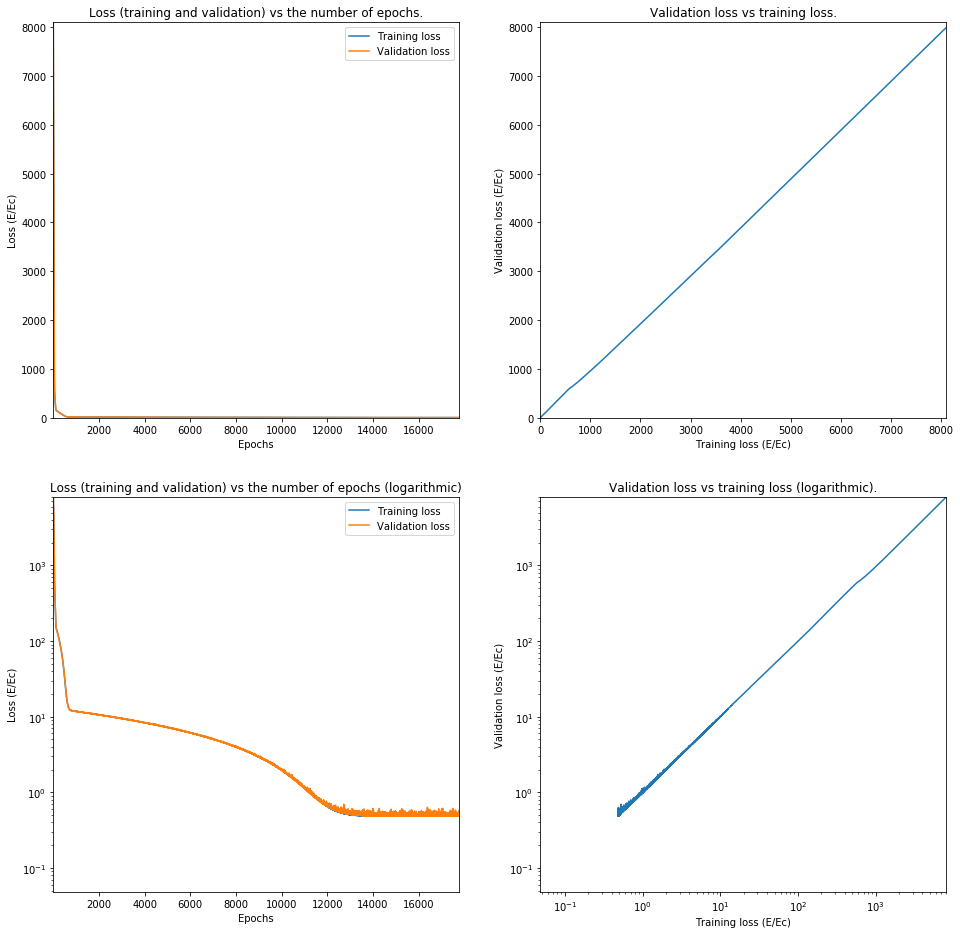

Train on 14400 samples, validate on 3600 samples
Epoch 1/20000
14400/14400 [==============================] - 0s 26us/step - loss: 2296.6727 - val_loss: 2220.4295
Epoch 2/20000
14400/14400 [==============================] - 0s 23us/step - loss: 2188.1145 - val_loss: 2117.5262
Epoch 3/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2090.6729 - val_loss: 2024.2892
Epoch 4/20000
14400/14400 [==============================] - 0s 23us/step - loss: 2002.6030 - val_loss: 1940.3527
Epoch 5/20000
14400/14400 [==============================] - 0s 22us/step - loss: 1923.6095 - val_loss: 1866.2429
Epoch 6/20000
14400/14400 [==============================] - 0s 22us/step - loss: 1853.6849 - val_loss: 1801.0355
Epoch 7/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1792.3035 - val_loss: 1744.0917
Epoch 8/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1739.4516 - val_loss: 1696.0995
Epoch 9/20000
14400/14400 [============

Epoch 72/20000
14400/14400 [==============================] - 0s 22us/step - loss: 953.0417 - val_loss: 936.4293
Epoch 73/20000
14400/14400 [==============================] - 0s 23us/step - loss: 942.9838 - val_loss: 926.5071
Epoch 74/20000
14400/14400 [==============================] - 0s 22us/step - loss: 932.9012 - val_loss: 916.5758
Epoch 75/20000
14400/14400 [==============================] - 0s 23us/step - loss: 922.9004 - val_loss: 906.6853
Epoch 76/20000
14400/14400 [==============================] - 0s 22us/step - loss: 912.8887 - val_loss: 896.7680
Epoch 77/20000
14400/14400 [==============================] - 0s 22us/step - loss: 902.9272 - val_loss: 886.9318
Epoch 78/20000
14400/14400 [==============================] - 0s 22us/step - loss: 892.9580 - val_loss: 877.0995
Epoch 79/20000
14400/14400 [==============================] - 0s 23us/step - loss: 883.0261 - val_loss: 867.2516
Epoch 80/20000
14400/14400 [==============================] - 0s 22us/step - loss: 873.0825 - va

14400/14400 [==============================] - 0s 21us/step - loss: 249.2490 - val_loss: 239.6446
Epoch 145/20000
14400/14400 [==============================] - 0s 21us/step - loss: 240.1428 - val_loss: 230.5573
Epoch 146/20000
14400/14400 [==============================] - 0s 21us/step - loss: 231.0634 - val_loss: 221.5776
Epoch 147/20000
14400/14400 [==============================] - 0s 22us/step - loss: 222.0588 - val_loss: 212.6879
Epoch 148/20000
14400/14400 [==============================] - 0s 21us/step - loss: 213.1094 - val_loss: 203.8231
Epoch 149/20000
14400/14400 [==============================] - 0s 21us/step - loss: 204.3085 - val_loss: 195.2161
Epoch 150/20000
14400/14400 [==============================] - 0s 22us/step - loss: 195.6444 - val_loss: 186.7537
Epoch 151/20000
14400/14400 [==============================] - 0s 21us/step - loss: 187.2626 - val_loss: 178.7705
Epoch 152/20000
14400/14400 [==============================] - 0s 21us/step - loss: 179.2492 - val_loss:

Epoch 217/20000
14400/14400 [==============================] - 0s 21us/step - loss: 64.7197 - val_loss: 64.2191
Epoch 218/20000
14400/14400 [==============================] - 0s 20us/step - loss: 64.3988 - val_loss: 64.0039
Epoch 219/20000
14400/14400 [==============================] - 0s 20us/step - loss: 64.0929 - val_loss: 63.6324
Epoch 220/20000
14400/14400 [==============================] - 0s 21us/step - loss: 63.7865 - val_loss: 63.3498
Epoch 221/20000
14400/14400 [==============================] - 0s 20us/step - loss: 63.4786 - val_loss: 62.9989
Epoch 222/20000
14400/14400 [==============================] - 0s 20us/step - loss: 63.1670 - val_loss: 62.6860
Epoch 223/20000
14400/14400 [==============================] - 0s 21us/step - loss: 62.8583 - val_loss: 62.3845
Epoch 224/20000
14400/14400 [==============================] - 0s 20us/step - loss: 62.5428 - val_loss: 62.0777
Epoch 225/20000
14400/14400 [==============================] - 0s 20us/step - loss: 62.2322 - val_loss: 

14400/14400 [==============================] - 0s 22us/step - loss: 42.6497 - val_loss: 42.4379
Epoch 291/20000
14400/14400 [==============================] - 0s 21us/step - loss: 42.3673 - val_loss: 42.1485
Epoch 292/20000
14400/14400 [==============================] - 0s 22us/step - loss: 42.0707 - val_loss: 41.8796
Epoch 293/20000
14400/14400 [==============================] - 0s 21us/step - loss: 41.7960 - val_loss: 41.5724
Epoch 294/20000
14400/14400 [==============================] - 0s 22us/step - loss: 41.4898 - val_loss: 41.2898
Epoch 295/20000
14400/14400 [==============================] - 0s 23us/step - loss: 41.2104 - val_loss: 41.0266
Epoch 296/20000
14400/14400 [==============================] - 0s 21us/step - loss: 40.9198 - val_loss: 40.7529
Epoch 297/20000
14400/14400 [==============================] - 0s 21us/step - loss: 40.6477 - val_loss: 40.4868
Epoch 298/20000
14400/14400 [==============================] - 0s 22us/step - loss: 40.3662 - val_loss: 40.1686
Epoch 29

14400/14400 [==============================] - 0s 20us/step - loss: 23.3641 - val_loss: 23.2876
Epoch 364/20000
14400/14400 [==============================] - 0s 20us/step - loss: 23.1291 - val_loss: 23.1037
Epoch 365/20000
14400/14400 [==============================] - 0s 20us/step - loss: 22.9030 - val_loss: 22.8537
Epoch 366/20000
14400/14400 [==============================] - 0s 20us/step - loss: 22.6728 - val_loss: 22.6518
Epoch 367/20000
14400/14400 [==============================] - 0s 21us/step - loss: 22.4457 - val_loss: 22.3806
Epoch 368/20000
14400/14400 [==============================] - 0s 21us/step - loss: 22.2204 - val_loss: 22.1663
Epoch 369/20000
14400/14400 [==============================] - 0s 21us/step - loss: 21.9866 - val_loss: 22.0357
Epoch 370/20000
14400/14400 [==============================] - 0s 20us/step - loss: 21.7579 - val_loss: 21.7267
Epoch 371/20000
14400/14400 [==============================] - 0s 22us/step - loss: 21.5424 - val_loss: 21.4828
Epoch 37

14400/14400 [==============================] - 0s 20us/step - loss: 11.7789 - val_loss: 11.8390
Epoch 437/20000
14400/14400 [==============================] - 0s 21us/step - loss: 11.6927 - val_loss: 11.6795
Epoch 438/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.6070 - val_loss: 11.5823
Epoch 439/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.5230 - val_loss: 11.5188
Epoch 440/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.4573 - val_loss: 11.4178
Epoch 441/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.3671 - val_loss: 11.3664
Epoch 442/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.2873 - val_loss: 11.2637
Epoch 443/20000
14400/14400 [==============================] - 0s 21us/step - loss: 11.2052 - val_loss: 11.1824
Epoch 444/20000
14400/14400 [==============================] - 0s 20us/step - loss: 11.1330 - val_loss: 11.1102
Epoch 44

14400/14400 [==============================] - 0s 20us/step - loss: 8.5954 - val_loss: 8.5787
Epoch 511/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.5808 - val_loss: 8.5462
Epoch 512/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.5697 - val_loss: 8.5278
Epoch 513/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.5460 - val_loss: 8.5147
Epoch 514/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.5344 - val_loss: 8.5103
Epoch 515/20000
14400/14400 [==============================] - 0s 21us/step - loss: 8.5235 - val_loss: 8.4872
Epoch 516/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.5047 - val_loss: 8.4762
Epoch 517/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.4978 - val_loss: 8.4611
Epoch 518/20000
14400/14400 [==============================] - 0s 20us/step - loss: 8.4865 - val_loss: 8.4587
Epoch 519/20000
14400/1440

14400/14400 [==============================] - 0s 20us/step - loss: 7.9694 - val_loss: 7.9648
Epoch 585/20000
14400/14400 [==============================] - 0s 23us/step - loss: 7.9655 - val_loss: 7.9671
Epoch 586/20000
14400/14400 [==============================] - 0s 23us/step - loss: 7.9699 - val_loss: 7.9559
Epoch 587/20000
14400/14400 [==============================] - 0s 22us/step - loss: 7.9560 - val_loss: 7.9664
Epoch 588/20000
14400/14400 [==============================] - 0s 24us/step - loss: 7.9572 - val_loss: 8.0109
Epoch 589/20000
14400/14400 [==============================] - 0s 22us/step - loss: 7.9514 - val_loss: 7.9764
Epoch 590/20000
14400/14400 [==============================] - 0s 23us/step - loss: 7.9443 - val_loss: 7.9356
Epoch 591/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.9367 - val_loss: 7.9936
Epoch 592/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.9339 - val_loss: 7.9498
Epoch 593/20000
14400/1440

14400/14400 [==============================] - 0s 20us/step - loss: 7.7010 - val_loss: 7.6924
Epoch 659/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.6977 - val_loss: 7.7053
Epoch 660/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.7045 - val_loss: 7.6977
Epoch 661/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.7027 - val_loss: 7.6896
Epoch 662/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.6904 - val_loss: 7.6865
Epoch 663/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6865 - val_loss: 7.6826
Epoch 664/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6936 - val_loss: 7.7219
Epoch 665/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6900 - val_loss: 7.6940
Epoch 666/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.6843 - val_loss: 7.6706
Epoch 667/20000
14400/1440

14400/14400 [==============================] - 0s 19us/step - loss: 7.4794 - val_loss: 7.5257
Epoch 733/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.4880 - val_loss: 7.4704
Epoch 734/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.4754 - val_loss: 7.4542
Epoch 735/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.4767 - val_loss: 7.4816
Epoch 736/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.4669 - val_loss: 7.4685
Epoch 737/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.4668 - val_loss: 7.4476
Epoch 738/20000
14400/14400 [==============================] - 0s 22us/step - loss: 7.4602 - val_loss: 7.4475
Epoch 739/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.4645 - val_loss: 7.4555
Epoch 740/20000
14400/14400 [==============================] - 0s 22us/step - loss: 7.4605 - val_loss: 7.4372
Epoch 741/20000
14400/1440

14400/14400 [==============================] - 0s 20us/step - loss: 7.2666 - val_loss: 7.2503
Epoch 807/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.2669 - val_loss: 7.2543
Epoch 808/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.2615 - val_loss: 7.2461
Epoch 809/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.2502 - val_loss: 7.2952
Epoch 810/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.2514 - val_loss: 7.2496
Epoch 811/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.2524 - val_loss: 7.2380
Epoch 812/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.2385 - val_loss: 7.2326
Epoch 813/20000
14400/14400 [==============================] - 0s 21us/step - loss: 7.2438 - val_loss: 7.2260
Epoch 814/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.2375 - val_loss: 7.2304
Epoch 815/20000
14400/1440

14400/14400 [==============================] - 0s 20us/step - loss: 7.0596 - val_loss: 7.0392
Epoch 881/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.0509 - val_loss: 7.0689
Epoch 882/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.0519 - val_loss: 7.0264
Epoch 883/20000
14400/14400 [==============================] - 0s 22us/step - loss: 7.0438 - val_loss: 7.0266
Epoch 884/20000
14400/14400 [==============================] - 0s 22us/step - loss: 7.0432 - val_loss: 7.0269
Epoch 885/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.0371 - val_loss: 7.0187
Epoch 886/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.0313 - val_loss: 7.0277
Epoch 887/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.0418 - val_loss: 7.0635
Epoch 888/20000
14400/14400 [==============================] - 0s 20us/step - loss: 7.0324 - val_loss: 7.0197
Epoch 889/20000
14400/1440

14400/14400 [==============================] - 0s 20us/step - loss: 6.8479 - val_loss: 6.9252
Epoch 955/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.8464 - val_loss: 6.8237
Epoch 956/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.8500 - val_loss: 6.8415
Epoch 957/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.8353 - val_loss: 6.8363
Epoch 958/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.8336 - val_loss: 6.8198
Epoch 959/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.8300 - val_loss: 6.8182
Epoch 960/20000
14400/14400 [==============================] - 0s 22us/step - loss: 6.8337 - val_loss: 6.8245
Epoch 961/20000
14400/14400 [==============================] - 0s 22us/step - loss: 6.8283 - val_loss: 6.8108
Epoch 962/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.8345 - val_loss: 6.8032
Epoch 963/20000
14400/1440

14400/14400 [==============================] - 0s 20us/step - loss: 6.6450 - val_loss: 6.6354
Epoch 1029/20000
14400/14400 [==============================] - 0s 22us/step - loss: 6.6385 - val_loss: 6.6396
Epoch 1030/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6375 - val_loss: 6.6159
Epoch 1031/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6329 - val_loss: 6.6115
Epoch 1032/20000
14400/14400 [==============================] - 0s 22us/step - loss: 6.6267 - val_loss: 6.6165
Epoch 1033/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.6325 - val_loss: 6.7112
Epoch 1034/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6265 - val_loss: 6.6043
Epoch 1035/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6232 - val_loss: 6.6038
Epoch 1036/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.6343 - val_loss: 6.6372
Epoch 1037/20000
1

Epoch 1102/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4467 - val_loss: 6.4193
Epoch 1103/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4445 - val_loss: 6.4518
Epoch 1104/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4379 - val_loss: 6.4248
Epoch 1105/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4453 - val_loss: 6.4142
Epoch 1106/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.4277 - val_loss: 6.4139
Epoch 1107/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4324 - val_loss: 6.4161
Epoch 1108/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4350 - val_loss: 6.4058
Epoch 1109/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4298 - val_loss: 6.4061
Epoch 1110/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.4227 - val_loss: 6.4015
E

Epoch 1176/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.2566 - val_loss: 6.2289
Epoch 1177/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.2509 - val_loss: 6.2209
Epoch 1178/20000
14400/14400 [==============================] - 0s 22us/step - loss: 6.2441 - val_loss: 6.2225
Epoch 1179/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.2449 - val_loss: 6.2334
Epoch 1180/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.2359 - val_loss: 6.2242
Epoch 1181/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.2447 - val_loss: 6.2177
Epoch 1182/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.2358 - val_loss: 6.2140
Epoch 1183/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.2323 - val_loss: 6.2123
Epoch 1184/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.2365 - val_loss: 6.2349
E

Epoch 1250/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.0636 - val_loss: 6.0493
Epoch 1251/20000
14400/14400 [==============================] - 0s 21us/step - loss: 6.0612 - val_loss: 6.0921
Epoch 1252/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0533 - val_loss: 6.0317
Epoch 1253/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0550 - val_loss: 6.0785
Epoch 1254/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0619 - val_loss: 6.1347
Epoch 1255/20000
14400/14400 [==============================] - 0s 22us/step - loss: 6.0653 - val_loss: 6.0290
Epoch 1256/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0505 - val_loss: 6.0302
Epoch 1257/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0412 - val_loss: 6.0215
Epoch 1258/20000
14400/14400 [==============================] - 0s 20us/step - loss: 6.0441 - val_loss: 6.0157
E

Epoch 1324/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8782 - val_loss: 5.9124
Epoch 1325/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8820 - val_loss: 5.8593
Epoch 1326/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8738 - val_loss: 5.8785
Epoch 1327/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.8778 - val_loss: 5.8625
Epoch 1328/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8756 - val_loss: 5.8600
Epoch 1329/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.8664 - val_loss: 5.8622
Epoch 1330/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8658 - val_loss: 5.8475
Epoch 1331/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8645 - val_loss: 5.8842
Epoch 1332/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.8685 - val_loss: 5.8459
E

Epoch 1398/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6992 - val_loss: 5.6830
Epoch 1399/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.7075 - val_loss: 5.6902
Epoch 1400/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.6982 - val_loss: 5.6847
Epoch 1401/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6958 - val_loss: 5.6919
Epoch 1402/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6986 - val_loss: 5.6676
Epoch 1403/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6951 - val_loss: 5.6867
Epoch 1404/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6988 - val_loss: 5.6590
Epoch 1405/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.6808 - val_loss: 5.6878
Epoch 1406/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.6796 - val_loss: 5.7272
E

Epoch 1472/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5279 - val_loss: 5.5048
Epoch 1473/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5340 - val_loss: 5.5152
Epoch 1474/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5263 - val_loss: 5.5243
Epoch 1475/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.5267 - val_loss: 5.5050
Epoch 1476/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5330 - val_loss: 5.5320
Epoch 1477/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5203 - val_loss: 5.5549
Epoch 1478/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5243 - val_loss: 5.5406
Epoch 1479/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.5143 - val_loss: 5.5184
Epoch 1480/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.5164 - val_loss: 5.4848
E

Epoch 1546/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3673 - val_loss: 5.3838
Epoch 1547/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3684 - val_loss: 5.3745
Epoch 1548/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.3549 - val_loss: 5.3435
Epoch 1549/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3600 - val_loss: 5.3315
Epoch 1550/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3531 - val_loss: 5.3262
Epoch 1551/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.3574 - val_loss: 5.3223
Epoch 1552/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.3619 - val_loss: 5.3449
Epoch 1553/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.3444 - val_loss: 5.3937
Epoch 1554/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.3507 - val_loss: 5.3332
E

14400/14400 [==============================] - 0s 20us/step - loss: 5.2108 - val_loss: 5.2274
Epoch 1620/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.2041 - val_loss: 5.1717
Epoch 1621/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.2097 - val_loss: 5.1687
Epoch 1622/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.1962 - val_loss: 5.1892
Epoch 1623/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.1972 - val_loss: 5.1673
Epoch 1624/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.1938 - val_loss: 5.1735
Epoch 1625/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.1934 - val_loss: 5.1636
Epoch 1626/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.1951 - val_loss: 5.1629
Epoch 1627/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.1885 - val_loss: 5.2161
Epoch 1628/20000
1

14400/14400 [==============================] - 0s 20us/step - loss: 5.0536 - val_loss: 5.0208
Epoch 1693/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0510 - val_loss: 5.0231
Epoch 1694/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0475 - val_loss: 5.0486
Epoch 1695/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0441 - val_loss: 5.1169
Epoch 1696/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.0467 - val_loss: 5.0163
Epoch 1697/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0420 - val_loss: 5.0137
Epoch 1698/20000
14400/14400 [==============================] - 0s 20us/step - loss: 5.0423 - val_loss: 5.0167
Epoch 1699/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.0380 - val_loss: 5.0217
Epoch 1700/20000
14400/14400 [==============================] - 0s 21us/step - loss: 5.0363 - val_loss: 5.0157
Epoch 1701/20000
1

14400/14400 [==============================] - 0s 23us/step - loss: 4.9050 - val_loss: 4.8721
Epoch 1766/20000
14400/14400 [==============================] - 0s 22us/step - loss: 4.9028 - val_loss: 4.8869
Epoch 1767/20000
14400/14400 [==============================] - 0s 22us/step - loss: 4.8999 - val_loss: 4.8714
Epoch 1768/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.9016 - val_loss: 4.8851
Epoch 1769/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.8929 - val_loss: 4.8658
Epoch 1770/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.8927 - val_loss: 4.8717
Epoch 1771/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.9027 - val_loss: 4.8634
Epoch 1772/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.8935 - val_loss: 4.8833
Epoch 1773/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.8857 - val_loss: 4.8780
Epoch 1774/20000
1

14400/14400 [==============================] - 0s 21us/step - loss: 4.7560 - val_loss: 4.7388
Epoch 1839/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.7528 - val_loss: 4.7270
Epoch 1840/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.7569 - val_loss: 4.7294
Epoch 1841/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.7494 - val_loss: 4.7288
Epoch 1842/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.7545 - val_loss: 4.7231
Epoch 1843/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7537 - val_loss: 4.7207
Epoch 1844/20000
14400/14400 [==============================] - 0s 19us/step - loss: 4.7500 - val_loss: 4.7208
Epoch 1845/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.7481 - val_loss: 4.7236
Epoch 1846/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.7428 - val_loss: 4.7232
Epoch 1847/20000
1

Epoch 1912/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6170 - val_loss: 4.6043
Epoch 1913/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6233 - val_loss: 4.6463
Epoch 1914/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6098 - val_loss: 4.6127
Epoch 1915/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.6140 - val_loss: 4.5839
Epoch 1916/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.6122 - val_loss: 4.5848
Epoch 1917/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6168 - val_loss: 4.5796
Epoch 1918/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6152 - val_loss: 4.5784
Epoch 1919/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.6085 - val_loss: 4.5809
Epoch 1920/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.6038 - val_loss: 4.5765
E

Epoch 1986/20000
14400/14400 [==============================] - 0s 23us/step - loss: 4.4893 - val_loss: 4.4813
Epoch 1987/20000
14400/14400 [==============================] - 0s 22us/step - loss: 4.4786 - val_loss: 4.5900
Epoch 1988/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.4832 - val_loss: 4.4529
Epoch 1989/20000
14400/14400 [==============================] - 0s 22us/step - loss: 4.4766 - val_loss: 4.5391
Epoch 1990/20000
14400/14400 [==============================] - 0s 22us/step - loss: 4.4804 - val_loss: 4.4534
Epoch 1991/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.4752 - val_loss: 4.4487
Epoch 1992/20000
14400/14400 [==============================] - 0s 22us/step - loss: 4.4724 - val_loss: 4.4855
Epoch 1993/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.4682 - val_loss: 4.4418
Epoch 1994/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.4698 - val_loss: 4.4416
E

Epoch 2060/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3529 - val_loss: 4.3330
Epoch 2061/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.3550 - val_loss: 4.3519
Epoch 2062/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3680 - val_loss: 4.3284
Epoch 2063/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3459 - val_loss: 4.3220
Epoch 2064/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3456 - val_loss: 4.3204
Epoch 2065/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3463 - val_loss: 4.3260
Epoch 2066/20000
14400/14400 [==============================] - 0s 21us/step - loss: 4.3402 - val_loss: 4.3387
Epoch 2067/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3402 - val_loss: 4.3120
Epoch 2068/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.3459 - val_loss: 4.3134
E

Epoch 2134/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2275 - val_loss: 4.2330
Epoch 2135/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2267 - val_loss: 4.2212
Epoch 2136/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2188 - val_loss: 4.1978
Epoch 2137/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2286 - val_loss: 4.1981
Epoch 2138/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2247 - val_loss: 4.2194
Epoch 2139/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2269 - val_loss: 4.1998
Epoch 2140/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2151 - val_loss: 4.1988
Epoch 2141/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2168 - val_loss: 4.2495
Epoch 2142/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.2141 - val_loss: 4.2265
E

Epoch 2208/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1161 - val_loss: 4.0820
Epoch 2209/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1047 - val_loss: 4.0822
Epoch 2210/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1059 - val_loss: 4.0909
Epoch 2211/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1077 - val_loss: 4.0840
Epoch 2212/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1026 - val_loss: 4.0774
Epoch 2213/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.0936 - val_loss: 4.0746
Epoch 2214/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.1019 - val_loss: 4.0706
Epoch 2215/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.0923 - val_loss: 4.0671
Epoch 2216/20000
14400/14400 [==============================] - 0s 20us/step - loss: 4.0981 - val_loss: 4.0684
E

Epoch 2282/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9925 - val_loss: 3.9991
Epoch 2283/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9896 - val_loss: 3.9651
Epoch 2284/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9827 - val_loss: 3.9612
Epoch 2285/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9855 - val_loss: 3.9702
Epoch 2286/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9915 - val_loss: 3.9913
Epoch 2287/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9929 - val_loss: 3.9782
Epoch 2288/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9806 - val_loss: 3.9588
Epoch 2289/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9756 - val_loss: 3.9591
Epoch 2290/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.9795 - val_loss: 3.9617
E

Epoch 2356/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8773 - val_loss: 3.8622
Epoch 2357/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8775 - val_loss: 3.8516
Epoch 2358/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.8777 - val_loss: 3.8824
Epoch 2359/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8711 - val_loss: 3.8455
Epoch 2360/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8710 - val_loss: 3.8464
Epoch 2361/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8693 - val_loss: 3.8668
Epoch 2362/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8716 - val_loss: 3.8531
Epoch 2363/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8670 - val_loss: 3.8435
Epoch 2364/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.8692 - val_loss: 3.8413
E

14400/14400 [==============================] - 0s 20us/step - loss: 3.7676 - val_loss: 3.7493
Epoch 2430/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.7683 - val_loss: 3.7480
Epoch 2431/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.7685 - val_loss: 3.7466
Epoch 2432/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.7640 - val_loss: 3.7511
Epoch 2433/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.7624 - val_loss: 3.7603
Epoch 2434/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.7713 - val_loss: 3.7367
Epoch 2435/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.7639 - val_loss: 3.7334
Epoch 2436/20000
14400/14400 [==============================] - 0s 23us/step - loss: 3.7552 - val_loss: 3.7477
Epoch 2437/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.7548 - val_loss: 3.7286
Epoch 2438/20000
1

Epoch 2503/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6620 - val_loss: 3.6458
Epoch 2504/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6638 - val_loss: 3.6377
Epoch 2505/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6630 - val_loss: 3.6518
Epoch 2506/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6588 - val_loss: 3.6455
Epoch 2507/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6534 - val_loss: 3.6369
Epoch 2508/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6583 - val_loss: 3.6325
Epoch 2509/20000
14400/14400 [==============================] - 0s 19us/step - loss: 3.6531 - val_loss: 3.6841
Epoch 2510/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6571 - val_loss: 3.6329
Epoch 2511/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.6555 - val_loss: 3.6240
E

Epoch 2577/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5650 - val_loss: 3.5547
Epoch 2578/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5561 - val_loss: 3.5321
Epoch 2579/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5584 - val_loss: 3.5452
Epoch 2580/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.5537 - val_loss: 3.5324
Epoch 2581/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5563 - val_loss: 3.5957
Epoch 2582/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5527 - val_loss: 3.5321
Epoch 2583/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5508 - val_loss: 3.5344
Epoch 2584/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.5436 - val_loss: 3.5440
Epoch 2585/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.5479 - val_loss: 3.5292
E

14400/14400 [==============================] - 0s 20us/step - loss: 3.4624 - val_loss: 3.4495
Epoch 2651/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.4572 - val_loss: 3.4353
Epoch 2652/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.4555 - val_loss: 3.4640
Epoch 2653/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.4556 - val_loss: 3.4311
Epoch 2654/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.4600 - val_loss: 3.4330
Epoch 2655/20000
14400/14400 [==============================] - 0s 23us/step - loss: 3.4503 - val_loss: 3.4635
Epoch 2656/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.4543 - val_loss: 3.4632
Epoch 2657/20000
14400/14400 [==============================] - 0s 24us/step - loss: 3.4488 - val_loss: 3.4302
Epoch 2658/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.4492 - val_loss: 3.4523
Epoch 2659/20000
1

Epoch 2724/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3636 - val_loss: 3.3545
Epoch 2725/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3712 - val_loss: 3.3424
Epoch 2726/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3611 - val_loss: 3.3355
Epoch 2727/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3604 - val_loss: 3.3506
Epoch 2728/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3546 - val_loss: 3.3335
Epoch 2729/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3601 - val_loss: 3.3515
Epoch 2730/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3583 - val_loss: 3.3285
Epoch 2731/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3533 - val_loss: 3.3644
Epoch 2732/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.3492 - val_loss: 3.3339
E

Epoch 2798/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2665 - val_loss: 3.2663
Epoch 2799/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2688 - val_loss: 3.2410
Epoch 2800/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2619 - val_loss: 3.2399
Epoch 2801/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2621 - val_loss: 3.2453
Epoch 2802/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2610 - val_loss: 3.2429
Epoch 2803/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2567 - val_loss: 3.2462
Epoch 2804/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2583 - val_loss: 3.2665
Epoch 2805/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2593 - val_loss: 3.2426
Epoch 2806/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.2549 - val_loss: 3.2503
E

Epoch 2872/20000
14400/14400 [==============================] - 0s 22us/step - loss: 3.1822 - val_loss: 3.1994
Epoch 2873/20000
14400/14400 [==============================] - 0s 21us/step - loss: 3.1718 - val_loss: 3.1501
Epoch 2874/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1765 - val_loss: 3.1594
Epoch 2875/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1655 - val_loss: 3.1689
Epoch 2876/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1694 - val_loss: 3.1459
Epoch 2877/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1683 - val_loss: 3.1649
Epoch 2878/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1688 - val_loss: 3.1842
Epoch 2879/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1698 - val_loss: 3.2261
Epoch 2880/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.1699 - val_loss: 3.1502
E

14400/14400 [==============================] - 0s 20us/step - loss: 3.0938 - val_loss: 3.1039
Epoch 2946/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0870 - val_loss: 3.0859
Epoch 2947/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0828 - val_loss: 3.1062
Epoch 2948/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0834 - val_loss: 3.0932
Epoch 2949/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0825 - val_loss: 3.0721
Epoch 2950/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0855 - val_loss: 3.0591
Epoch 2951/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0755 - val_loss: 3.0912
Epoch 2952/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0762 - val_loss: 3.0852
Epoch 2953/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0779 - val_loss: 3.1903
Epoch 2954/20000
1

Epoch 3019/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0045 - val_loss: 3.0041
Epoch 3020/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0020 - val_loss: 2.9735
Epoch 3021/20000
14400/14400 [==============================] - 0s 20us/step - loss: 3.0025 - val_loss: 2.9812
Epoch 3022/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9947 - val_loss: 2.9707
Epoch 3023/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9980 - val_loss: 3.0377
Epoch 3024/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9928 - val_loss: 2.9694
Epoch 3025/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9914 - val_loss: 2.9692
Epoch 3026/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9915 - val_loss: 3.0414
Epoch 3027/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2.9924 - val_loss: 2.9699
E

14400/14400 [==============================] - 0s 19us/step - loss: 2.9122 - val_loss: 2.8943
Epoch 3093/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9118 - val_loss: 2.8972
Epoch 3094/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9137 - val_loss: 2.9117
Epoch 3095/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9134 - val_loss: 2.8889
Epoch 3096/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9091 - val_loss: 2.8942
Epoch 3097/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9119 - val_loss: 2.8876
Epoch 3098/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9061 - val_loss: 2.8848
Epoch 3099/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9112 - val_loss: 2.8857
Epoch 3100/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.9058 - val_loss: 2.8850
Epoch 3101/20000
1

Epoch 3166/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8281 - val_loss: 2.8078
Epoch 3167/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8376 - val_loss: 2.8105
Epoch 3168/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8351 - val_loss: 2.8084
Epoch 3169/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8335 - val_loss: 2.8028
Epoch 3170/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8228 - val_loss: 2.8117
Epoch 3171/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8275 - val_loss: 2.8027
Epoch 3172/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.8248 - val_loss: 2.8055
Epoch 3173/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8299 - val_loss: 2.8202
Epoch 3174/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.8181 - val_loss: 2.7983
E

Epoch 3240/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2.7474 - val_loss: 2.7360
Epoch 3241/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.7486 - val_loss: 2.7252
Epoch 3242/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.7499 - val_loss: 2.7481
Epoch 3243/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.7484 - val_loss: 2.7271
Epoch 3244/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.7434 - val_loss: 2.7559
Epoch 3245/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.7415 - val_loss: 2.7415
Epoch 3246/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7417 - val_loss: 2.7191
Epoch 3247/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.7422 - val_loss: 2.7177
Epoch 3248/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.7361 - val_loss: 2.8014
E

Epoch 3314/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.6652 - val_loss: 2.6792
Epoch 3315/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.6656 - val_loss: 2.7069
Epoch 3316/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6666 - val_loss: 2.6466
Epoch 3317/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6672 - val_loss: 2.6615
Epoch 3318/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6662 - val_loss: 2.6503
Epoch 3319/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6664 - val_loss: 2.6501
Epoch 3320/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6625 - val_loss: 2.6834
Epoch 3321/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6598 - val_loss: 2.6802
Epoch 3322/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.6571 - val_loss: 2.6573
E

Epoch 3388/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5872 - val_loss: 2.5656
Epoch 3389/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.5863 - val_loss: 2.5795
Epoch 3390/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.5836 - val_loss: 2.5679
Epoch 3391/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.5848 - val_loss: 2.5655
Epoch 3392/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5792 - val_loss: 2.5619
Epoch 3393/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5827 - val_loss: 2.5617
Epoch 3394/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5877 - val_loss: 2.5672
Epoch 3395/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5775 - val_loss: 2.5610
Epoch 3396/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5791 - val_loss: 2.5589
E

14400/14400 [==============================] - 0s 20us/step - loss: 2.5182 - val_loss: 2.5322
Epoch 3462/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5125 - val_loss: 2.4891
Epoch 3463/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5101 - val_loss: 2.6239
Epoch 3464/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5119 - val_loss: 2.5149
Epoch 3465/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5088 - val_loss: 2.4869
Epoch 3466/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5074 - val_loss: 2.5007
Epoch 3467/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5010 - val_loss: 2.4815
Epoch 3468/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5054 - val_loss: 2.5501
Epoch 3469/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.5005 - val_loss: 2.4821
Epoch 3470/20000
1

Epoch 3535/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4330 - val_loss: 2.4293
Epoch 3536/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4378 - val_loss: 2.4139
Epoch 3537/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4313 - val_loss: 2.4391
Epoch 3538/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4334 - val_loss: 2.4479
Epoch 3539/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4293 - val_loss: 2.4169
Epoch 3540/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4292 - val_loss: 2.4163
Epoch 3541/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4273 - val_loss: 2.4196
Epoch 3542/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.4364 - val_loss: 2.4674
Epoch 3543/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.4273 - val_loss: 2.4159
E

Epoch 3609/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.3578 - val_loss: 2.3493
Epoch 3610/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.3620 - val_loss: 2.3475
Epoch 3611/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.3617 - val_loss: 2.3544
Epoch 3612/20000
14400/14400 [==============================] - 0s 23us/step - loss: 2.3528 - val_loss: 2.3732
Epoch 3613/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2.3555 - val_loss: 2.3357
Epoch 3614/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2.3536 - val_loss: 2.3346
Epoch 3615/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.3510 - val_loss: 2.3391
Epoch 3616/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.3487 - val_loss: 2.3374
Epoch 3617/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2.3552 - val_loss: 2.3366
E

Epoch 3683/20000
14400/14400 [==============================] - 0s 25us/step - loss: 2.2809 - val_loss: 2.2771
Epoch 3684/20000
14400/14400 [==============================] - 0s 30us/step - loss: 2.2828 - val_loss: 2.2768
Epoch 3685/20000
14400/14400 [==============================] - 0s 24us/step - loss: 2.2869 - val_loss: 2.2981
Epoch 3686/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.2871 - val_loss: 2.3203
Epoch 3687/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.2900 - val_loss: 2.2607
Epoch 3688/20000
14400/14400 [==============================] - 0s 25us/step - loss: 2.2761 - val_loss: 2.2620
Epoch 3689/20000
14400/14400 [==============================] - 0s 30us/step - loss: 2.2768 - val_loss: 2.2978
Epoch 3690/20000
14400/14400 [==============================] - 0s 23us/step - loss: 2.2789 - val_loss: 2.3113
Epoch 3691/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.2784 - val_loss: 2.3054
E

Epoch 3757/20000
14400/14400 [==============================] - 0s 23us/step - loss: 2.2104 - val_loss: 2.2553
Epoch 3758/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.2104 - val_loss: 2.1967
Epoch 3759/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.2131 - val_loss: 2.1883
Epoch 3760/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.2071 - val_loss: 2.2373
Epoch 3761/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.2177 - val_loss: 2.2282
Epoch 3762/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.2083 - val_loss: 2.1845
Epoch 3763/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.2007 - val_loss: 2.1858
Epoch 3764/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.2050 - val_loss: 2.2634
Epoch 3765/20000
14400/14400 [==============================] - 0s 22us/step - loss: 2.2047 - val_loss: 2.2242
E

Epoch 3831/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1453 - val_loss: 2.1665
Epoch 3832/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1393 - val_loss: 2.1173
Epoch 3833/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1328 - val_loss: 2.1231
Epoch 3834/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1348 - val_loss: 2.1143
Epoch 3835/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1330 - val_loss: 2.1180
Epoch 3836/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1410 - val_loss: 2.1250
Epoch 3837/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1397 - val_loss: 2.1131
Epoch 3838/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1320 - val_loss: 2.1112
Epoch 3839/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.1315 - val_loss: 2.1101
E

Epoch 3905/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.0686 - val_loss: 2.0866
Epoch 3906/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.0681 - val_loss: 2.1911
Epoch 3907/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.0710 - val_loss: 2.1726
Epoch 3908/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.0687 - val_loss: 2.1108
Epoch 3909/20000
14400/14400 [==============================] - 0s 19us/step - loss: 2.0625 - val_loss: 2.0945
Epoch 3910/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.0642 - val_loss: 2.1002
Epoch 3911/20000
14400/14400 [==============================] - 0s 20us/step - loss: 2.0624 - val_loss: 2.0476
Epoch 3912/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.0615 - val_loss: 2.0830
Epoch 3913/20000
14400/14400 [==============================] - 0s 21us/step - loss: 2.0668 - val_loss: 2.0381
E

Epoch 3979/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9988 - val_loss: 1.9766
Epoch 3980/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9950 - val_loss: 1.9933
Epoch 3981/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9938 - val_loss: 1.9787
Epoch 3982/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9919 - val_loss: 1.9731
Epoch 3983/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9957 - val_loss: 1.9759
Epoch 3984/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9994 - val_loss: 1.9749
Epoch 3985/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9882 - val_loss: 1.9771
Epoch 3986/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9930 - val_loss: 2.0124
Epoch 3987/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9916 - val_loss: 2.0011
E

14400/14400 [==============================] - 0s 20us/step - loss: 1.9294 - val_loss: 1.9131
Epoch 4053/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9337 - val_loss: 1.9071
Epoch 4054/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9281 - val_loss: 1.9700
Epoch 4055/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9277 - val_loss: 1.9113
Epoch 4056/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9285 - val_loss: 1.9342
Epoch 4057/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9200 - val_loss: 1.9544
Epoch 4058/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9267 - val_loss: 1.9049
Epoch 4059/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.9182 - val_loss: 1.9036
Epoch 4060/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.9249 - val_loss: 1.9128
Epoch 4061/20000
1

Epoch 4126/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.8595 - val_loss: 1.8373
Epoch 4127/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.8615 - val_loss: 1.8563
Epoch 4128/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8598 - val_loss: 1.8415
Epoch 4129/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8574 - val_loss: 1.8399
Epoch 4130/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8531 - val_loss: 1.8598
Epoch 4131/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8565 - val_loss: 1.8415
Epoch 4132/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8576 - val_loss: 1.8365
Epoch 4133/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8527 - val_loss: 1.8504
Epoch 4134/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.8496 - val_loss: 1.8873
E

Epoch 4200/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7885 - val_loss: 1.7727
Epoch 4201/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7936 - val_loss: 1.7854
Epoch 4202/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7938 - val_loss: 1.7808
Epoch 4203/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7894 - val_loss: 1.7696
Epoch 4204/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7872 - val_loss: 1.7676
Epoch 4205/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7843 - val_loss: 1.7767
Epoch 4206/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7860 - val_loss: 1.7662
Epoch 4207/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7832 - val_loss: 1.7676
Epoch 4208/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7909 - val_loss: 1.7739
E

14400/14400 [==============================] - 0s 20us/step - loss: 1.7303 - val_loss: 1.7181
Epoch 4274/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.7264 - val_loss: 1.7030
Epoch 4275/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.7235 - val_loss: 1.7032
Epoch 4276/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7270 - val_loss: 1.7274
Epoch 4277/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7257 - val_loss: 1.7048
Epoch 4278/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7223 - val_loss: 1.6991
Epoch 4279/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7199 - val_loss: 1.7130
Epoch 4280/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.7194 - val_loss: 1.7209
Epoch 4281/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.7222 - val_loss: 1.6985
Epoch 4282/20000
1

Epoch 4347/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6662 - val_loss: 1.6441
Epoch 4348/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6613 - val_loss: 1.6465
Epoch 4349/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6615 - val_loss: 1.6590
Epoch 4350/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6594 - val_loss: 1.6393
Epoch 4351/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6517 - val_loss: 1.6841
Epoch 4352/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6543 - val_loss: 1.6348
Epoch 4353/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6518 - val_loss: 1.6748
Epoch 4354/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.6496 - val_loss: 1.6602
Epoch 4355/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.6513 - val_loss: 1.7992
E

Epoch 4421/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5941 - val_loss: 1.6286
Epoch 4422/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5913 - val_loss: 1.6037
Epoch 4423/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5919 - val_loss: 1.5725
Epoch 4424/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5977 - val_loss: 1.5813
Epoch 4425/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5941 - val_loss: 1.5756
Epoch 4426/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5976 - val_loss: 1.5992
Epoch 4427/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5884 - val_loss: 1.5869
Epoch 4428/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5926 - val_loss: 1.5681
Epoch 4429/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5882 - val_loss: 1.6416
E

Epoch 4495/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.5326 - val_loss: 1.5142
Epoch 4496/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5305 - val_loss: 1.5381
Epoch 4497/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5346 - val_loss: 1.5457
Epoch 4498/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5270 - val_loss: 1.5148
Epoch 4499/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5267 - val_loss: 1.6349
Epoch 4500/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5324 - val_loss: 1.5116
Epoch 4501/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5351 - val_loss: 1.5248
Epoch 4502/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5287 - val_loss: 1.5269
Epoch 4503/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.5210 - val_loss: 1.5071
E

Epoch 4569/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4717 - val_loss: 1.4493
Epoch 4570/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4705 - val_loss: 1.4912
Epoch 4571/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4733 - val_loss: 1.4509
Epoch 4572/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4726 - val_loss: 1.4553
Epoch 4573/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4698 - val_loss: 1.4948
Epoch 4574/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4697 - val_loss: 1.4468
Epoch 4575/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4608 - val_loss: 1.4507
Epoch 4576/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4618 - val_loss: 1.4555
Epoch 4577/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4627 - val_loss: 1.4426
E

Epoch 4643/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4124 - val_loss: 1.3906
Epoch 4644/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4084 - val_loss: 1.4004
Epoch 4645/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4139 - val_loss: 1.3910
Epoch 4646/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4073 - val_loss: 1.4316
Epoch 4647/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4075 - val_loss: 1.4191
Epoch 4648/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4082 - val_loss: 1.3995
Epoch 4649/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.4037 - val_loss: 1.3906
Epoch 4650/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4027 - val_loss: 1.3934
Epoch 4651/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.4090 - val_loss: 1.4737
E

14400/14400 [==============================] - 0s 20us/step - loss: 1.3575 - val_loss: 1.3312
Epoch 4717/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3488 - val_loss: 1.3410
Epoch 4718/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3492 - val_loss: 1.3321
Epoch 4719/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3500 - val_loss: 1.3300
Epoch 4720/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3483 - val_loss: 1.3481
Epoch 4721/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3487 - val_loss: 1.3460
Epoch 4722/20000
14400/14400 [==============================] - ETA: 0s - loss: 1.349 - 0s 20us/step - loss: 1.3505 - val_loss: 1.3309
Epoch 4723/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3491 - val_loss: 1.3527
Epoch 4724/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.3474 - val_loss: 1

14400/14400 [==============================] - 0s 20us/step - loss: 1.2938 - val_loss: 1.2902
Epoch 4790/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2959 - val_loss: 1.2745
Epoch 4791/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2935 - val_loss: 1.2756
Epoch 4792/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2884 - val_loss: 1.2960
Epoch 4793/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2932 - val_loss: 1.2727
Epoch 4794/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2885 - val_loss: 1.2719
Epoch 4795/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2925 - val_loss: 1.2954
Epoch 4796/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2886 - val_loss: 1.2713
Epoch 4797/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.2902 - val_loss: 1.2714
Epoch 4798/20000
1

Epoch 4863/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2398 - val_loss: 1.2484
Epoch 4864/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2432 - val_loss: 1.2235
Epoch 4865/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2374 - val_loss: 1.2315
Epoch 4866/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2372 - val_loss: 1.2298
Epoch 4867/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2383 - val_loss: 1.2280
Epoch 4868/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2416 - val_loss: 1.2419
Epoch 4869/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2382 - val_loss: 1.2470
Epoch 4870/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.2299 - val_loss: 1.2157
Epoch 4871/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.2319 - val_loss: 1.2341
E

Epoch 4937/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1838 - val_loss: 1.1666
Epoch 4938/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1862 - val_loss: 1.1670
Epoch 4939/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1825 - val_loss: 1.1738
Epoch 4940/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1790 - val_loss: 1.1695
Epoch 4941/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1800 - val_loss: 1.1642
Epoch 4942/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1765 - val_loss: 1.1727
Epoch 4943/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1810 - val_loss: 1.1674
Epoch 4944/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1807 - val_loss: 1.2261
Epoch 4945/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1859 - val_loss: 1.2331
E

Epoch 5011/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1301 - val_loss: 1.1159
Epoch 5012/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1289 - val_loss: 1.1496
Epoch 5013/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1353 - val_loss: 1.1612
Epoch 5014/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1326 - val_loss: 1.1153
Epoch 5015/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1318 - val_loss: 1.1192
Epoch 5016/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1283 - val_loss: 1.1120
Epoch 5017/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1281 - val_loss: 1.1343
Epoch 5018/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.1274 - val_loss: 1.1262
Epoch 5019/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.1344 - val_loss: 1.1142
E

Epoch 5085/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.0821 - val_loss: 1.0977
Epoch 5086/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.0800 - val_loss: 1.0635
Epoch 5087/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0786 - val_loss: 1.0682
Epoch 5088/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0815 - val_loss: 1.0757
Epoch 5089/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0756 - val_loss: 1.0771
Epoch 5090/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0799 - val_loss: 1.0649
Epoch 5091/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0787 - val_loss: 1.0730
Epoch 5092/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0775 - val_loss: 1.0589
Epoch 5093/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0792 - val_loss: 1.0866
E

Epoch 5159/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0333 - val_loss: 1.0678
Epoch 5160/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0292 - val_loss: 1.0156
Epoch 5161/20000
14400/14400 [==============================] - ETA: 0s - loss: 1.036 - 0s 20us/step - loss: 1.0319 - val_loss: 1.0160
Epoch 5162/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0288 - val_loss: 1.0170
Epoch 5163/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0308 - val_loss: 1.0634
Epoch 5164/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0329 - val_loss: 1.0685
Epoch 5165/20000
14400/14400 [==============================] - 0s 19us/step - loss: 1.0314 - val_loss: 1.0225
Epoch 5166/20000
14400/14400 [==============================] - 0s 20us/step - loss: 1.0274 - val_loss: 1.0116
Epoch 5167/20000
14400/14400 [==============================] - 0s 21us/step - loss: 1.0

14400/14400 [==============================] - 0s 20us/step - loss: 0.9921 - val_loss: 0.9734
Epoch 5233/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9851 - val_loss: 0.9981
Epoch 5234/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9890 - val_loss: 0.9981
Epoch 5235/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9862 - val_loss: 1.0495
Epoch 5236/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9863 - val_loss: 0.9702
Epoch 5237/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9864 - val_loss: 0.9731
Epoch 5238/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9840 - val_loss: 0.9813
Epoch 5239/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9828 - val_loss: 0.9866
Epoch 5240/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9858 - val_loss: 1.0588
Epoch 5241/20000
1

Epoch 5306/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9429 - val_loss: 0.9339
Epoch 5307/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9428 - val_loss: 0.9302
Epoch 5308/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9471 - val_loss: 0.9401
Epoch 5309/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9430 - val_loss: 0.9558
Epoch 5310/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9441 - val_loss: 0.9520
Epoch 5311/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9435 - val_loss: 0.9903
Epoch 5312/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9434 - val_loss: 0.9745
Epoch 5313/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9403 - val_loss: 0.9289
Epoch 5314/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9389 - val_loss: 0.9270
E

Epoch 5380/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9025 - val_loss: 0.8951
Epoch 5381/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9083 - val_loss: 0.9024
Epoch 5382/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9013 - val_loss: 0.9034
Epoch 5383/20000
14400/14400 [==============================] - 0s 19us/step - loss: 0.9043 - val_loss: 0.9147
Epoch 5384/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8995 - val_loss: 0.9549
Epoch 5385/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8996 - val_loss: 0.9027
Epoch 5386/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8981 - val_loss: 0.8879
Epoch 5387/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.8983 - val_loss: 0.9010
Epoch 5388/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.9030 - val_loss: 0.9045
E

14400/14400 [==============================] - 0s 20us/step - loss: 0.8712 - val_loss: 0.8712
Epoch 5454/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.8710 - val_loss: 0.8660
Epoch 5455/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.8684 - val_loss: 0.8516
Epoch 5456/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8621 - val_loss: 0.8515
Epoch 5457/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8641 - val_loss: 0.8543
Epoch 5458/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8685 - val_loss: 0.8719
Epoch 5459/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8589 - val_loss: 0.8712
Epoch 5460/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8655 - val_loss: 0.8621
Epoch 5461/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8631 - val_loss: 0.8789
Epoch 5462/20000
1

Epoch 5527/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.8267 - val_loss: 0.8195
Epoch 5528/20000
14400/14400 [==============================] - 0s 24us/step - loss: 0.8279 - val_loss: 0.8407
Epoch 5529/20000
14400/14400 [==============================] - 0s 24us/step - loss: 0.8287 - val_loss: 0.8233
Epoch 5530/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.8261 - val_loss: 0.8221
Epoch 5531/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.8316 - val_loss: 0.9193
Epoch 5532/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.8308 - val_loss: 0.8211
Epoch 5533/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.8243 - val_loss: 0.8184
Epoch 5534/20000
14400/14400 [==============================] - 0s 24us/step - loss: 0.8226 - val_loss: 0.8173
Epoch 5535/20000
14400/14400 [==============================] - 0s 25us/step - loss: 0.8277 - val_loss: 0.8956
E

14400/14400 [==============================] - 0s 20us/step - loss: 0.8013 - val_loss: 0.7877
Epoch 5601/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7965 - val_loss: 0.8372
Epoch 5602/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.8014 - val_loss: 0.8485
Epoch 5603/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.7952 - val_loss: 0.8200
Epoch 5604/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7973 - val_loss: 0.8233
Epoch 5605/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7968 - val_loss: 0.7848
Epoch 5606/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.7899 - val_loss: 0.7886
Epoch 5607/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.7968 - val_loss: 0.7852
Epoch 5608/20000
14400/14400 [==============================] - 0s 22us/step - loss: 0.7972 - val_loss: 0.7831
Epoch 5609/20000
1

Epoch 5674/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7639 - val_loss: 0.7624
Epoch 5675/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7635 - val_loss: 0.7641
Epoch 5676/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7676 - val_loss: 0.8135
Epoch 5677/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7665 - val_loss: 0.7705
Epoch 5678/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7651 - val_loss: 0.7560
Epoch 5679/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7644 - val_loss: 0.7999
Epoch 5680/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7717 - val_loss: 0.7578
Epoch 5681/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7670 - val_loss: 0.7882
Epoch 5682/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.7572 - val_loss: 0.7787
E

14400/14400 [==============================] - 0s 20us/step - loss: 0.7381 - val_loss: 0.7395
Epoch 5748/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7342 - val_loss: 0.7414
Epoch 5749/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7396 - val_loss: 0.7345
Epoch 5750/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7373 - val_loss: 0.7292
Epoch 5751/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7380 - val_loss: 0.7346
Epoch 5752/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7342 - val_loss: 0.7279
Epoch 5753/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7321 - val_loss: 0.7413
Epoch 5754/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7355 - val_loss: 0.7474
Epoch 5755/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7350 - val_loss: 0.7286
Epoch 5756/20000
1

Epoch 5821/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7106 - val_loss: 0.7171
Epoch 5822/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7106 - val_loss: 0.7037
Epoch 5823/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7083 - val_loss: 0.7036
Epoch 5824/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7073 - val_loss: 0.7120
Epoch 5825/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7059 - val_loss: 0.7051
Epoch 5826/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7058 - val_loss: 0.7062
Epoch 5827/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7052 - val_loss: 0.7039
Epoch 5828/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7056 - val_loss: 0.7149
Epoch 5829/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.7067 - val_loss: 0.7134
E

Epoch 5895/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6860 - val_loss: 0.6851
Epoch 5896/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6839 - val_loss: 0.6829
Epoch 5897/20000
14400/14400 [==============================] - 0s 23us/step - loss: 0.6854 - val_loss: 0.6810
Epoch 5898/20000
14400/14400 [==============================] - 0s 21us/step - loss: 0.6837 - val_loss: 0.6818
Epoch 5899/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6828 - val_loss: 0.6814
Epoch 5900/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6792 - val_loss: 0.7001
Epoch 5901/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6848 - val_loss: 0.7234
Epoch 5902/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6849 - val_loss: 0.6822
Epoch 5903/20000
14400/14400 [==============================] - 0s 20us/step - loss: 0.6803 - val_loss: 0.6975
E

In [ ]:
name = 'LinearNetwork'
settingsNetwork = [inputSize, ['Dense', 1, 'linear', True]]
learningRate = 1*10**-5
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=20000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=3)


In [ ]:
net = makeDenseNetwork(settingsNetwork, learningRate, 'he_uniform', MAE)
%timeit net.predict([[data['eigenvalues'][1]]])

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

## Model 1: 1 Dense layer small softplus

In [ ]:
name = 'DenseLayerSmallSoftplus'
settingsNetwork = [inputSize, ['Dense', inputSize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=25000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Model 2: 1 Dense layer medium softplus

In [ ]:
name = 'DenseLayerMediumSoftplus'
settingsNetwork = [inputSize, ['Dense', 2*inputSize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=25000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Model 3: 1 Dense layer large softplus

In [ ]:
name = 'DenseLayerLargeSoftplus'
settingsNetwork = [inputSize, ['Dense', 3*inputSize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=10000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Model 4: 1 Dense layer super large softplus

In [ ]:
name = 'DenseLayerSuperLargeSoftplus'
settingsNetwork = [inputSize, ['Dense', 4*inputSize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=10000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())


## Model 5: 2 Dense layers small softplus

In [ ]:
name = 'TwoDenseLayerSmallSoftplus'
settingsNetwork = [inputSize, ['Dense', inputSize, 'softplus', True], ['Dense', inputSize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=25000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())


## Model 6: 2 Dense layer medium softplus

In [ ]:
name = 'TwoDenseLayerMediumSoftplus'
settingsNetwork = [inputSize, ['Dense', 2*inputsize, 'softplus', True], ['Dense', 2*inputsize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=10000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())


## Model 7: 2 Dense layers large softplus

In [ ]:
name = 'TwoDenseLayerLargeSoftplus'
settingsNetwork = [inputSize, ['Dense', 3*inputsize, 'softplus', True], ['Dense', 3*inputsize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=10000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())


## Model 8: 2 Dense layers very large softplus

In [ ]:
name = 'TwoDenseLayerLargeSoftplus'
settingsNetwork = [inputSize, ['Dense', 4*inputsize, 'softplus', True], ['Dense', 4*inputsize, 'softplus', True], ['Dense', 1, 'linear', True]]
learningRate = 2.5*10**-6
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=500, min_delta=0)]

model, fitDetails = testNetwork(trainingInput, settingsNetwork, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, validationSplit=0.2, epochs=10000, verbose=1, callbacksNetwork=callbacksNetwork, sampleSize=2)
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

In [ ]:
evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=1)
print(evaluation)
history = plotHistory(fitDetails)

makeGradiantPlot(model, x, testData)

makePredictionPlot(model, validationData)
makePredictionPlot(model, trainingData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())


# Finishing

In [ ]:

#print(evaluation)

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    #y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

"""
makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)
"""
#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


In [ ]:
for i in range(len(models)):
    model = models[i]['model']
    print(models[i]['name'])
    print(model.summary())
    print(models[i]['evaluation'])
    model.save(saveFolder + '/' + models[i]['name'] + str(models[i]['evaluation']) + '.h5')
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')